# Gráficos finales de sección SHAP

En este script corremos los gráficos seleccionados para el informe. Es decir, sin considerar los exploratorios hechos en el script "feature importance".

## 1. Librerías

In [2]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches


from functools import reduce
warnings.filterwarnings('ignore')

## 2. Datos

In [6]:
shap_values=pd.read_excel('../outputs/shap_df_xgb.xlsx', sheet_name='SHAP_Train')
data_colegios=pd.read_excel('../outputs/dataset_final_colegios_y_variables.xlsx', sheet_name='data')

In [7]:
shap_values.columns.to_list()

['ID1',
 'jurisdiccion_Buenos Aires',
 'jurisdiccion_Catamarca',
 'jurisdiccion_Chaco',
 'jurisdiccion_Chubut',
 'jurisdiccion_Ciudad Autónoma de Buenos Aires',
 'jurisdiccion_Corrientes',
 'jurisdiccion_Córdoba',
 'jurisdiccion_Entre Ríos',
 'jurisdiccion_Formosa',
 'jurisdiccion_Jujuy',
 'jurisdiccion_La Pampa',
 'jurisdiccion_La Rioja',
 'jurisdiccion_Mendoza',
 'jurisdiccion_Misiones',
 'jurisdiccion_Neuquén',
 'jurisdiccion_Río Negro',
 'jurisdiccion_Salta',
 'jurisdiccion_San Juan',
 'jurisdiccion_San Luis',
 'jurisdiccion_Santa Cruz',
 'jurisdiccion_Santa Fe',
 'jurisdiccion_Santiago del Estero',
 'jurisdiccion_Tierra del Fuego, Antártida e Islas del Atlántico Sur',
 'jurisdiccion_Tucumán',
 'region_CENTRO',
 'region_CUYO',
 'region_NEA',
 'region_NOA',
 'region_SUR',
 'clima_escolar_1',
 'clima_escolar_2',
 'clima_escolar_3',
 'sector',
 'secciones_por_colegio',
 'personas_por_habitacion',
 'ap27d_1_pct',
 'ap27d_2_pct',
 'ap27d_3_pct',
 'ap27d_4_pct',
 'ap16c_1_pct',
 'ap05a_1

In [8]:
print(shap_values['ID1'].nunique())
print(data_colegios['ID1'].nunique())

9085
11357


In [9]:
#Agregar el sufijo shap a la base de shap y luego mergear
columnas_excluidas=['prediccion','porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua', 'ID1']

# Renombrar solo las columnas que no estén en la lista de excluidas
shap_values = shap_values.rename(
    columns={col: f"{col}_shap" for col in shap_values.columns if col not in columnas_excluidas}
)

In [10]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

print(df.shape[0])

9085


In [11]:
#Importamos nombres de variables y la versión con nombres cortos para graficar
variables = pd.read_excel('../outputs/dataset_final_colegios_y_variables.xlsx', sheet_name='variables')
short_names=pd.read_excel('../inputs/nombres_reducidos.xlsx')[['desc_variable', 'Nombre reducido']]
short_names.rename(columns={'Nombre reducido':'short_name'}, inplace=True)

In [23]:
categorizacion_variables=pd.read_excel('../inputs/categorizacion_variables.xlsx')
categorizacion_variables.groupby('Categoría para sección  Shap values')['desc_variable'].nunique().reset_index()

Categoría para sección  Shap values  desc_variable
0                Factores de contexto              3
1                  Factores del hogar             19
2               Factores individuales             25
3            Factores institucionales             73
4                 Trayectoria escolar              8

In [24]:
variables=variables.merge(categorizacion_variables, how='left', on='desc_variable')
variables.rename(columns={'Categoría para sección  Shap values':'categoria_shap'}, inplace=True)
#Completar celdas de nan cdo corresponda
variables.loc[variables["variable"] == "jurisdiccion", "categoria_shap"] = "Factores de contexto"
variables.loc[variables["variable"] == "region", "categoria_shap"] = "Factores de contexto"
variables.loc[variables["variable"] == "clima_escolar", "categoria_shap"] = "Factores institucionales"

In [25]:
variables.groupby('categoria_shap')['desc_variable'].nunique().reset_index()

#Las institucionales que faltan son bloque docente y bloque directivo. Sin relevancia

categoria_shap  desc_variable
0      Factores de contexto              3
1        Factores del hogar             19
2     Factores individuales             25
3  Factores institucionales             71
4       Trayectoria escolar              8

In [28]:
variables.loc[variables['desc_variable']=='contesta_bloque_de_docentes']

Empty DataFrame
Columns: [variable, desc_variable, cantidad_nulos, variable_a_nivel_colegio, respuesta, desc_respuesta, numero_respuestas, Nombre reducido, categoria_shap, Subcategoría para análsis exploratorio]
Index: []

In [29]:
#A la base de variables, le indicamos si corresponde a la categoría NSE
NSE_base = list(set([
    "NSE_puntaje",
    "ap09a",
    "ap09d",
    "ap09k",
    "ap09g",
    "ap20b1",
    "ap20a2",
    "ap09j",
    "Nivel_Ed_Padre",
    "ap09c",
    "ap09i",
    "ap09b",
    "ap09h",
    "Nivel_Ed_Madre",
    "ap09e",
    "ap20b2",
    "ap09f",
    "ap20a1",
    "personas_por_habitacion"
]))

NSE_todas_las_variables = [
    "NSE_puntaje",
    "ap09a_1_pct", "ap09a_2_pct",
    "ap09d_1_pct", "ap09d_2_pct",
    "ap09k_1_pct", "ap09k_2_pct",
    "ap09g_1_pct", "ap09g_2_pct",
    "ap20b1_1.0_pct", "ap20b1_2.0_pct",
    "ap20a2_1.0_pct", "ap20a2_2.0_pct", "ap20a2_3.0_pct", "ap20a2_4.0_pct",
    "ap09j_1_pct", "ap09j_2_pct",
    "Nivel_Ed_Padre_1.0_pct", "Nivel_Ed_Padre_2.0_pct", "Nivel_Ed_Padre_3.0_pct",
    "Nivel_Ed_Padre_4.0_pct", "Nivel_Ed_Padre_5.0_pct", "Nivel_Ed_Padre_6.0_pct", "Nivel_Ed_Padre_7.0_pct",
    "ap09c_1_pct", "ap09c_2_pct",
    "ap09i_1_pct", "ap09i_2_pct",
    "ap09b_1_pct", "ap09b_2_pct",
    "ap09h_1_pct", "ap09h_2_pct",
    "Nivel_Ed_Madre_1.0_pct", "Nivel_Ed_Madre_2.0_pct", "Nivel_Ed_Madre_3.0_pct",
    "Nivel_Ed_Madre_4.0_pct", "Nivel_Ed_Madre_5.0_pct", "Nivel_Ed_Madre_6.0_pct", "Nivel_Ed_Madre_7.0_pct",
    "ap09e_1_pct", "ap09e_2_pct",
    "ap20b2_1.0_pct", "ap20b2_2.0_pct",
    "ap09f_1_pct", "ap09f_2_pct",
    "ap20a1_1.0_pct", "ap20a1_2.0_pct", "ap20a1_3.0_pct", "ap20a1_4.0_pct",    "personas_por_habitacion"
]


variables["NSE"] = np.where(variables["variable"].isin(NSE_base), 1, 0)

## 3.Gráficos

### 3.1 Shap globales

In [30]:
df.shape

(9085, 642)

In [31]:
columnas_excluidas = [
    'ID1',
    'prediccion',
    'real',
    'jurisdiccion',
    'numero_alumnos',
    'NSE_puntaje',
    'not_missing_matematica_ni_lengua',
    'porcentaje_satisfactorio',
    'ambito', 'region'
]

# Obtener solo las columnas SHAP
shap_cols = [col for col in df.columns if col.endswith('_shap')]

# Calcular importancia global
shap_global = (
    df[shap_cols]
    .abs()
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
shap_global.columns = ['variable_nivel_colegio_shap', 'importance']
shap_global['variable_a_nivel_colegio'] = shap_global['variable_nivel_colegio_shap'].str.replace('_shap', '', regex=False)

# Merge con tablas de referencia
shap_global = shap_global.merge(variables, how='left', on='variable_a_nivel_colegio')
shap_global = shap_global.merge(short_names, how='left', on='desc_variable')


In [32]:
shap_global['importance']=shap_global['importance']*100

In [35]:
#Rellenamos algunas categorías que quedan con NA
cols_check = ["variable_a_nivel_colegio", "variable", "variable_nivel_colegio_shap"]

def any_contains(df, substrings):
    if isinstance(substrings, str):
        substrings = [substrings]
    mask = pd.Series(False, index=df.index)
    for col in cols_check:
        if col in df.columns:
            m_col = df[col].astype(str).str.contains("|".join(substrings), case=False, na=False)
            mask = mask | m_col
    return mask

# Máscaras
m_jur   = any_contains(shap_global, ["jurisdiccion"])   # ej: 'jurisdiccion_Córdoba'
m_region= any_contains(shap_global, ["region"])         # ej: 'region_CENTRO', 'region_SUR'...
m_clima = any_contains(shap_global, ["clima"])          # ej: 'clima_escolar_1'
m_bloque_dir_doc = any_contains(shap_global, ["contesta_bloque"]) 

# Asignaciones (clima primero o después es indistinto si no se solapan)
shap_global.loc[m_jur | m_region, "categoria_shap"] = "Factores de contexto"
shap_global.loc[m_clima,             "categoria_shap"] = "Factores institucionales"
shap_global.loc[m_bloque_dir_doc,             "categoria_shap"] = "Factores institucionales"

shap_global.loc[m_jur ,"short_name"] = "jurisdiccion"
shap_global.loc[m_region ,"short_name"] = "region"
shap_global.loc[m_clima,"short_name"] = "clima_escolar"
shap_global.loc[m_bloque_dir_doc,             "short_name"] = "contesta_bloque_docente_directores"


In [37]:
shap_global.loc[shap_global['categoria_shap'].isna()]

Empty DataFrame
Columns: [variable_nivel_colegio_shap, importance, variable_a_nivel_colegio, variable, desc_variable, cantidad_nulos, respuesta, desc_respuesta, numero_respuestas, Nombre reducido, categoria_shap, Subcategoría para análsis exploratorio, NSE, short_name]
Index: []

##### Barchart categorías

In [38]:
df_barchart=shap_global.groupby('categoria_shap')['importance'].sum().reset_index().sort_values(by='importance', ascending=False)

In [39]:
df_barchart

categoria_shap  importance
1        Factores del hogar   11.289861
2     Factores individuales   10.718916
4       Trayectoria escolar    7.647096
3  Factores institucionales    3.269038
0      Factores de contexto    3.091889

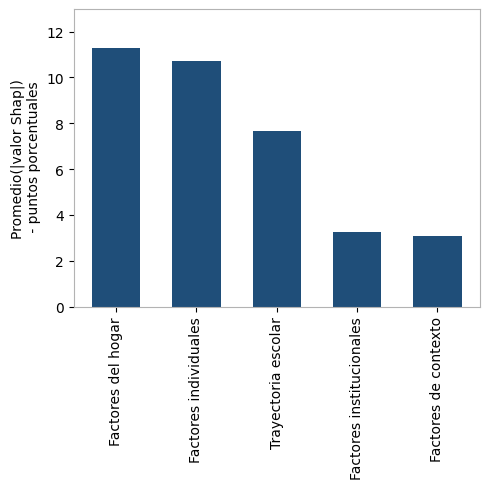

In [40]:
# === Paleta: un solo azul ===
COLOR_BLUE_MAIN = "#1F4E79" 
COLOR_SPINE = "#b3b3b3"

# === Figura: MISMA ALTURA que el resto del deck ===
fig, ax = plt.subplots(figsize=(5, 5))  # ancho más chico, misma altura

# Márgenes verticales idénticos a los otros gráficos
fig.subplots_adjust(left=0.12, right=0.98, top=0.92, bottom=0.36)

bars = ax.bar(
    df_barchart["categoria_shap"],
    df_barchart["importance"],
    color=COLOR_BLUE_MAIN,
    width=0.6
)

# --- Etiquetas de valores encima de las barras ---
#for i, v in enumerate(df_barchart["importance"]):
#    ax.text(i, v + 0.2, f"{v:.1f}", ha='center', va='bottom', fontsize=11)

# --- Estética coherente con tus otros gráficos ---
#ax.set_title("Importancia por categoría SHAP", loc="left", fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Promedio(|valor Shap|)\n - puntos porcentuales", fontsize=10)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_ylim(0, df_barchart["importance"].max() * 1.15)

# Spines grises finos
for s in ax.spines.values():
    s.set_color("#b3b3b3")
    s.set_linewidth(0.8)

ax.grid(False)
plt.tight_layout()
plt.show()

### 3.2 Distribución shaps vs valores de variables

##### 3.2.1 Factores de contexto

In [44]:
df_jurisdiccion = pd.DataFrame({
    "grupo": df["jurisdiccion"],
    "shap_value": df.apply(
        lambda row: row[f"jurisdiccion_{row['jurisdiccion']}_shap"], axis=1
    )
})
df_jurisdiccion["grupo"] = df_jurisdiccion["grupo"].replace({
    "Ciudad Autónoma de Buenos Aires": "CABA",
    "Tierra del Fuego, Antártida e Islas del Atlántico Sur": "Tierra del Fuego"
})


df_clima = pd.DataFrame({
    "grupo": df["clima_escolar"].astype(str),
    "shap_value": df.apply(
        lambda row: row[f"clima_escolar_{int(row['clima_escolar'])}_shap"], axis=1
    )
})
df_clima["grupo"] = pd.Categorical(df_clima["grupo"], categories=["1", "2", "3"], ordered=True)


df_sector = pd.DataFrame({
    "grupo": df["sector"].map({0: "Privado", 1: "Público"}),
    "shap_value": df["sector_shap"]
})

df_region = pd.DataFrame({
    "grupo": df["region"],
    "shap_value": df.apply(
        lambda row: row[f"region_{row['region']}_shap"], axis=1
    )
})

for df in [df_clima, df_jurisdiccion, df_sector, df_region]:
    df["shap_value"] = pd.to_numeric(df["shap_value"], errors="coerce")  # asegura tipo numérico
    df["shap_value"]*=100  # multiplica por 100



In [45]:
# Armamos tabla con medidas de resumn de los shap values segun variable/categoría. Esto es solo para luego describir en el trabajo final

resumen_shap = {}

# Iterar por cada DataFrame con su nombre
for name, df in zip(
    ["Clima Escolar", "Jurisdicción", "Sector", "Región"],
    [df_clima, df_jurisdiccion, df_sector, df_region]
):
    resumen_shap[name] = {
        "Mínimo": df["shap_value"].min(),
        "Máximo": df["shap_value"].max(),
       "Media": df["shap_value"].mean(),
        "Mediana": df["shap_value"].median()
    }

# Convertir a DataFrame para mostrar
df_resumen_shap = pd.DataFrame(resumen_shap).T.round(2)
df_resumen_shap

Mínimo  Máximo  Media  Mediana
Clima Escolar   -0.70    0.94  -0.00     0.01
Jurisdicción    -3.95   10.63   0.50     0.00
Sector          -1.50    3.23   0.02    -0.67
Región          -1.82    0.26  -0.00     0.03

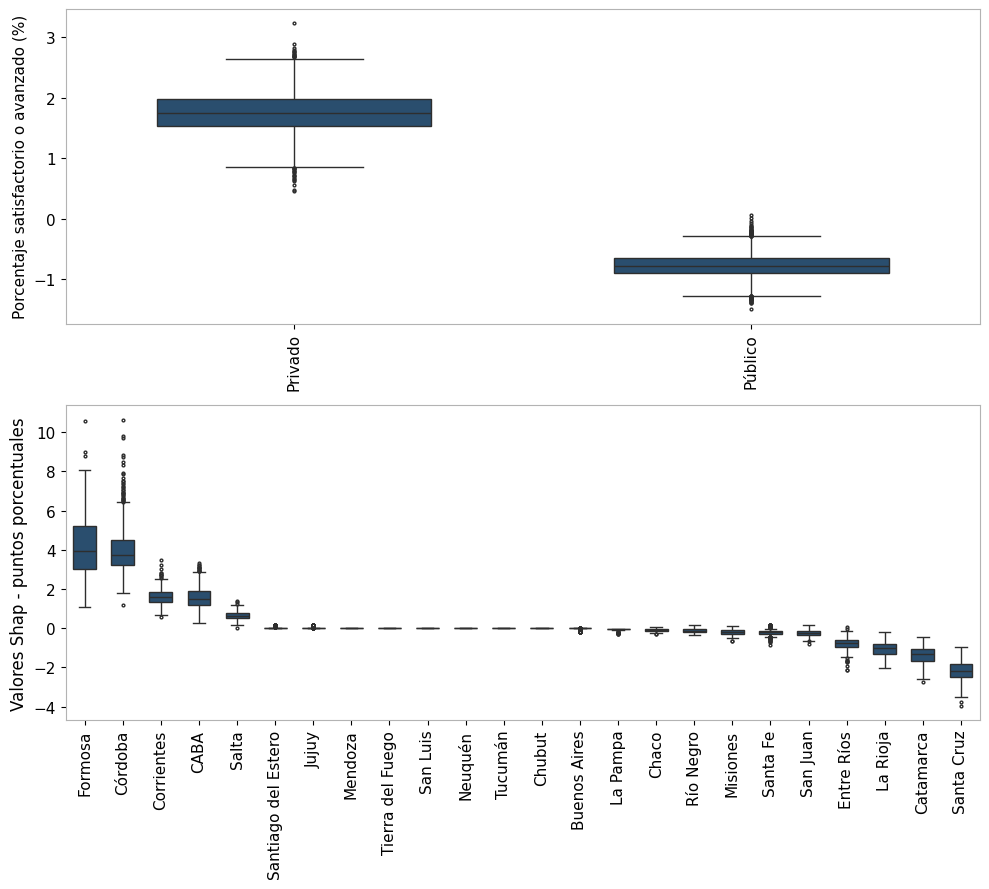

In [46]:
# Crear figura con 2 filas (apilados)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 9), sharex=False, sharey=False)

    
## --- 1) Boxplot por SECTOR ---
order_sector = (
    df_sector.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)
sns.boxplot(
    data=df_sector,
    x="grupo", y="shap_value",
    order=order_sector,
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax1,
    orient='v'
)
ax1.set_xlabel("")
ax1.set_ylabel("")
#ax1.set_title("Distribución por sector", loc="left", fontsize=12)
for s in ax1.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax1.tick_params(axis='x', rotation=90, labelsize=11)
ax1.tick_params(axis='y',labelsize=11)
ax1.set_ylabel("Porcentaje satisfactorio o avanzado (%)", fontsize=11)



# --- 2) Boxplot por PROVINCIA ---

order_prov = (
    df_jurisdiccion.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)


sns.boxplot(
    data=df_jurisdiccion,
    x="grupo", y="shap_value",
    order=order_prov,
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax2,
    orient='v'
)
ax2.set_xlabel("")
ax2.set_ylabel("Valores Shap - puntos porcentuales", fontsize=12)
#ax2.set_title("Distribución por provincia", loc="left", fontsize=12)

for s in ax2.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)

ax2.tick_params(axis='x', rotation=90, labelsize=11)
ax2.tick_params(axis='y', labelsize=11)


ax1.grid(False)
ax2.grid(False)
plt.tight_layout()

plt.show()



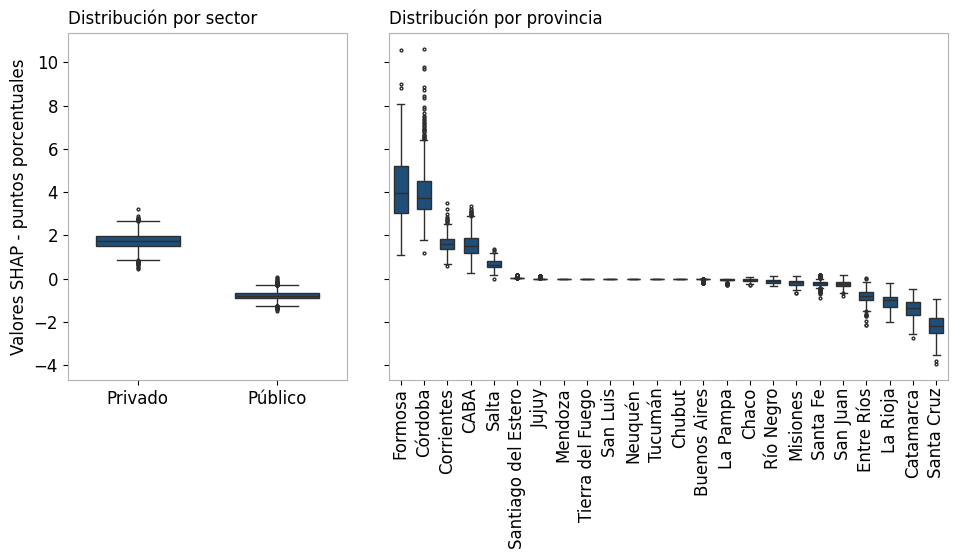

In [47]:
# --- FIGURA: 1 fila, 2 columnas, distinto ancho, mismo eje Y ---
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 6.2),
    sharey=True,
    gridspec_kw={"width_ratios": [2, 4]}  # <- sector angosto, provincia ancho
)

# Márgenes fijos (CLAVE: no usar tight_layout)
fig.subplots_adjust(left=0.10, right=0.98, top=0.92, bottom=0.36, wspace=0.10)

# --- 1) Boxplot por SECTOR ---
order_sector = (
    df_sector.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)

sns.boxplot(
    data=df_sector,
    x="grupo", y="shap_value",
    order=order_sector,
    color=COLOR_BLUE_MAIN,
    saturation=1,
    fliersize=2, width=0.6,
    ax=ax1,
    orient="v"
)

ax1.set_title("Distribución por sector", loc="left", fontsize=12)
ax1.set_xlabel("")
ax1.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=12)
ax1.tick_params(axis="x", rotation=0, labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax1.grid(False)

for s in ax1.spines.values():
    s.set_color("#b3b3b3")
    s.set_linewidth(0.8)

# --- 2) Boxplot por PROVINCIA ---
order_prov = (
    df_jurisdiccion.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)

sns.boxplot(
    data=df_jurisdiccion,
    x="grupo", y="shap_value",
    order=order_prov,
    color=COLOR_BLUE_MAIN,
    saturation=1,
    fliersize=2, width=0.6,
    ax=ax2,
    orient="v"
)

ax2.set_title("Distribución por provincia", loc="left", fontsize=12)
ax2.set_xlabel("")
ax2.set_ylabel("")  # sharey=True
ax2.tick_params(axis="x", rotation=90, labelsize=12, pad=2)
ax2.tick_params(axis="y", labelsize=12)
ax2.grid(False)

for s in ax2.spines.values():
    s.set_color("#b3b3b3")
    s.set_linewidth(0.8)

plt.show()


#### 3.2.2  Continuas

Primero usamos las más importantes que salen del análisis global de los Shaps y del feature importance clásico. Luego ploteamos las de interés

Esta es la lista de variables más relevantes (excluyendo categóricas) ['Computadora', 'Libros en el hogar',
      'Personas por habitación', 'Repitencia', 'Auto',
       'Nivel educativo madre', 
       'Nivel educativo Padre', 'Sobreedad',
        'Tiempo en llegar a la escuela',
       'Dónde dormís más días', 'Actividades: buscar leña',
       'Actividades: cultivar, cosechar, etc', 'Jardín de infantes',
       'Conexión a internet',
       'Estudiante recibió libros Aprender', 'Faltas al colegio',
       'Actividades: cuidar a familiar',
       'Opinión resolución problemas matemática',
       'Actividades:trabajar para no familiar',
       'Actividades: ayudar en trabajo a familiar',
       'Netflix + plataformas', 'Opinión resolución problemas Geometría']
       
Luego agregamos otras de interés

##### 3.2.2.1 Factores del hogar

Probamos las top 5: 'Computadora', 'Libros en el hogar', 'Personas por habitación', 'Nivel educativo madre' y 'Nivel educativo Padre'.

##### Computadora

In [48]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_computadora = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [49]:
vars=['NSE_puntaje','ap09i_1_pct_shap','ap09i_1_pct']
df_computadora=df_computadora[vars]

col_excluir = ['NSE_puntaje']
df_computadora.loc[:, ~df_computadora.columns.isin(col_excluir)] *= 100
df_computadora.head()


NSE_puntaje  ap09i_1_pct_shap  ap09i_1_pct
0    -0.304836         -1.615307    50.505051
1     0.693485          3.057896    91.666667
2     0.767152          2.559472    93.220339
3     0.782374          2.792978    86.138614
4     0.857615          3.934291    96.153846

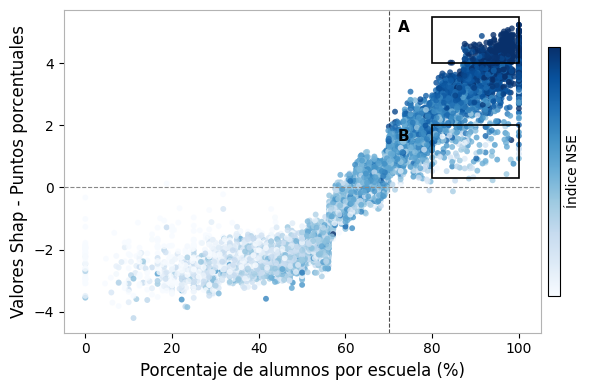

In [51]:
df=df_computadora.copy()
cmap = sns.color_palette("Blues", as_cmap=True)
vmin = np.percentile(df["NSE_puntaje"], 5)   # límite inferior = percentil 5
vmax = np.percentile(df["NSE_puntaje"], 95)  # límite superior = percentil 95
norm = plt.Normalize(vmin, vmax) 


fig, ax = plt.subplots(figsize=(6, 4))

sns.scatterplot(
    data=df,
    x="ap09i_1_pct", y="ap09i_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
ax.axvline(70, color="black", linestyle="--", linewidth=0.8, alpha=0.7, zorder=0)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))

# Colorbar para NSE
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.015)
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


    
###Esto es para armar los recuadros
def draw_box(ax, x0, x1, y0, y1, label, lw=1.2):
    # dibuja rectángulo
    rect = mpatches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                              fill=False, linewidth=lw, linestyle='-',
                              edgecolor='black')
    ax.add_patch(rect)
    # etiqueta: centrada
    ax.text((x0 + x1)/2.5, y1 - 0.6, label, ha='left', va='bottom',
            fontsize=11, fontweight='bold', color='black')

# ===== recuadros  =====

# a) x in [0.8, 1.0], y in [4.5, 6.0]
draw_box(ax, 80, 100, 4, 5.5, 'A')

# b)  x in [0.8, 1.0], y in [0.3, 2.0]
draw_box(ax, 80, 100, 0.3, 2, 'B')

    
    
fig.tight_layout()

In [52]:
df_computadora_stats=df_computadora[['ap09i_1_pct','ap09i_1_pct_shap']].copy()
x_col = "ap09i_1_pct"
y_col = "ap09i_1_pct_shap"

# Bins: [0,0.4], (0.4,0.8], (0.8,1.0]
labels = ["0–50%", "50–70%", "70–100%"]
df_computadora_stats["tramo"] = pd.cut(
    df_computadora_stats[x_col],
    bins=[0.0, 40, 70, 100],
    labels=labels,
    include_lowest=True,   
    right=True)

# Función de estadísticos por tramo
def _corr_stats(g):
    n = len(g)
    out = {
        "n": n,
        "x_mean": g[x_col].mean(),
        "y_mean": g[y_col].mean(),
        "pearson_r": np.nan,
        "spearman_rho": np.nan,
    }
    if n >= 2:
        out["pearson_r"]   = g[x_col].corr(g[y_col], method="pearson")
        out["spearman_rho"] = g[x_col].corr(g[y_col], method="spearman")
    return pd.Series(out)

corr_por_tramo = (
    df_computadora_stats.groupby("tramo", observed=True)
       .apply(_corr_stats)
       .reset_index()
)

# Orden agradable
corr_por_tramo = corr_por_tramo[
    ["tramo", "n", "x_mean", "y_mean", "pearson_r", "spearman_rho"]
].round(3)

corr_por_tramo



tramo       n  x_mean  y_mean  pearson_r  spearman_rho
0    0–50%  1301.0  29.999  -2.449      0.192         0.277
1   50–70%  4178.0  55.411  -1.166      0.908         0.893
2  70–100%  3606.0  85.374   2.701      0.829         0.836

##### Tenencia de libros

In [53]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_libros = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [54]:
variables.loc[variables['desc_variable']=='¿Cuántos libros hay donde vivís, aproximadamente?']['variable_a_nivel_colegio'].unique()

array(['ap10_1_pct', 'ap10_2_pct', 'ap10_3_pct', 'ap10_4_pct',
       'ap10_5_pct', 'ap10_6_pct'], dtype=object)

In [55]:
vars=['NSE_puntaje','ap10_1_pct', 'ap10_2_pct', 'ap10_3_pct', 'ap10_4_pct',
       'ap10_5_pct', 'ap10_6_pct', 'ap10_1_pct_shap', 'ap10_2_pct_shap', 'ap10_3_pct_shap', 'ap10_4_pct_shap',
       'ap10_5_pct_shap', 'ap10_6_pct_shap']
df_libros=df_libros[vars]

df_libros.loc[:, ~df_libros.columns.isin(col_excluir)] *= 100
df_libros.head()

NSE_puntaje  ap10_1_pct  ap10_2_pct  ap10_3_pct  ap10_4_pct  ap10_5_pct  \
0    -0.304836   14.141414   27.272727   22.222222   17.171717    4.040404   
1     0.693485    5.000000   18.333333   31.666667   23.333333    8.333333   
2     0.767152    3.389831   15.254237   23.728814   25.423729   15.254237   
3     0.782374    0.990099    4.950495   16.336634   28.712871   18.811881   
4     0.857615    0.000000   11.538462   23.076923   19.230769   19.230769   

   ap10_6_pct  ap10_1_pct_shap  ap10_2_pct_shap  ap10_3_pct_shap  \
0   15.151515        -0.588650        -0.780711        -0.065604   
1   13.333333         1.649438        -0.035501         0.101640   
2   16.949153         1.725994        -0.251306        -0.032433   
3   30.198020         2.231554         1.485036        -0.014216   
4   26.923077         2.308259         2.249832        -0.036185   

   ap10_4_pct_shap  ap10_5_pct_shap  ap10_6_pct_shap  
0         0.137675        -0.221890         0.050446  
1         0.310162         0.346279         0.076587  
2         0.257364         0.255807        -0.046421  
3         0.297715         0.543678        -0.030366  
4         0.317386         0.821438         0.028009

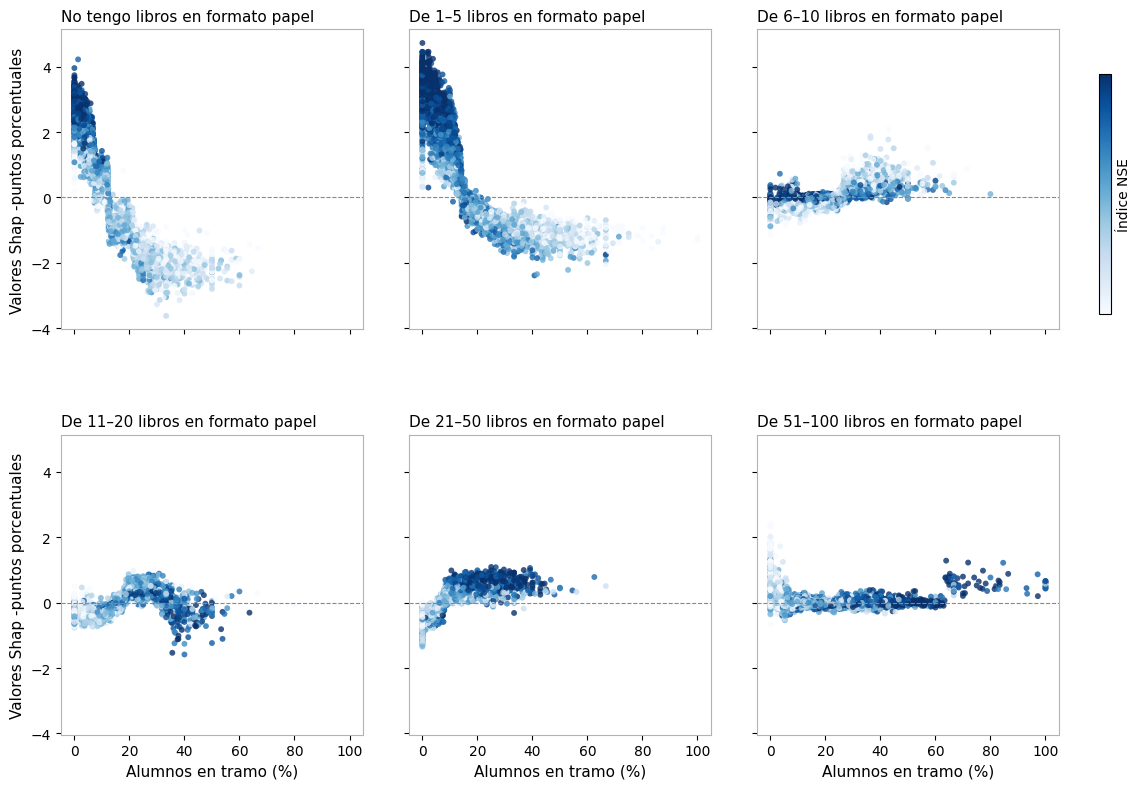

In [56]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap10_{i}_pct", f"ap10_{i}_pct_shap") for i in range(1,7)]
titulos = {
    1: "No tengo libros en formato papel",
    2: "De 1–5 libros en formato papel",
    3: "De 6–10 libros en formato papel",
    4: "De 11–20 libros en formato papel",
    5: "De 21–50 libros en formato papel",
    6: "De 51–100 libros en formato papel",
    7: "Más de 100 libros en formato papel"
}

# --- Figura y axes (2x3) ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_libros,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # Etiquetas de ejes solo en bordes para no sobrecargar
    if i > 3:  # fila de abajo
        ax.set_xlabel("Alumnos en tramo (%)", fontsize=11)
    else:
        ax.set_xlabel("")
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.92, 0.60, 0.01, 0.30])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])  # deja espacio para la barra a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [57]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_libros[ycol].mean(),
        "min_shap": df_libros[ycol].min(),
        "max_shap": df_libros[ycol].max(),
        "std_shap": df_libros[ycol].std()
    }
    for xcol, ycol in pares
])

resumen

categoria  promedio_shap  min_shap  max_shap  std_shap
0    ap10_1       0.299361 -3.620539  4.219733  1.572195
1    ap10_2      -0.000082 -2.385694  4.721496  1.327932
2    ap10_3       0.018645 -1.124639  2.083860  0.225433
3    ap10_4      -0.003761 -1.584808  0.994841  0.310154
4    ap10_5       0.038638 -1.344871  1.089616  0.432823
5    ap10_6       0.042007 -0.657006  2.408239  0.214309

Graficamos solo la opción ningún libro, dado que es la que mayores valores shaps presenta:

In [58]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_libros = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [59]:
vars=['NSE_puntaje','ap10_1_pct_shap','ap10_1_pct']
df_libros=df_libros[vars]

col_excluir = ['NSE_puntaje']
df_libros.loc[:, ~df_libros.columns.isin(col_excluir)] *= 100

df_libros.describe()

NSE_puntaje  ap10_1_pct_shap   ap10_1_pct
count  9085.000000      9085.000000  9085.000000
mean      0.160804         0.299361    12.568964
std       0.496514         1.572195    10.187608
min      -2.626484        -3.620539     0.000000
25%      -0.166123        -0.925705     4.597701
50%       0.132295         0.373515    11.111111
75%       0.512578         1.713382    18.309859
max       1.422577         4.219733    66.666667

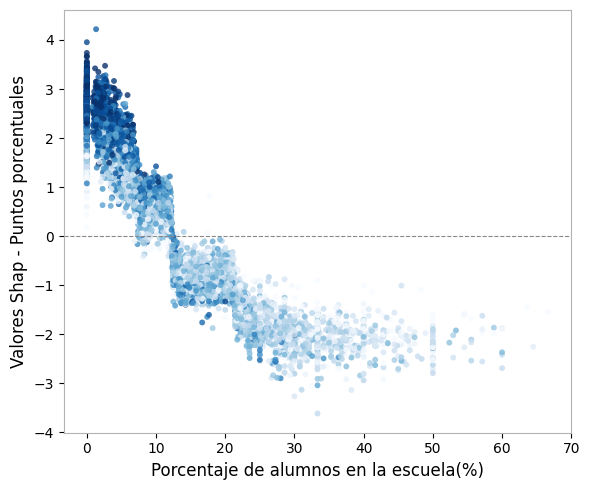

In [61]:
df=df_libros.copy()
cmap = sns.color_palette("Blues", as_cmap=True)

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="ap10_1_pct", y="ap10_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos en la escuela(%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


fig.tight_layout()

plt.show()

##### Educación Madre

In [62]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_educacion_madre = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [63]:
variables.loc[variables['desc_variable']=='Máximo nivel educativo madre o adulta responsable']['variable_a_nivel_colegio'].unique()

array(['Nivel_Ed_Madre_1.0_pct', 'Nivel_Ed_Madre_2.0_pct',
       'Nivel_Ed_Madre_3.0_pct', 'Nivel_Ed_Madre_4.0_pct',
       'Nivel_Ed_Madre_5.0_pct', 'Nivel_Ed_Madre_6.0_pct',
       'Nivel_Ed_Madre_7.0_pct'], dtype=object)

In [64]:
vars=['NSE_puntaje','Nivel_Ed_Madre_1.0_pct', 'Nivel_Ed_Madre_2.0_pct',
       'Nivel_Ed_Madre_3.0_pct', 'Nivel_Ed_Madre_4.0_pct',
       'Nivel_Ed_Madre_5.0_pct', 'Nivel_Ed_Madre_6.0_pct',
       'Nivel_Ed_Madre_7.0_pct','Nivel_Ed_Madre_1.0_pct_shap', 'Nivel_Ed_Madre_2.0_pct_shap',
       'Nivel_Ed_Madre_3.0_pct_shap', 'Nivel_Ed_Madre_4.0_pct_shap',
       'Nivel_Ed_Madre_5.0_pct_shap', 'Nivel_Ed_Madre_6.0_pct_shap',
       'Nivel_Ed_Madre_7.0_pct_shap']
df_educacion_madre=df_educacion_madre[vars]

df_educacion_madre.loc[:, ~df_educacion_madre.columns.isin(col_excluir)] *= 100
df_educacion_madre.head()

NSE_puntaje  Nivel_Ed_Madre_1.0_pct  Nivel_Ed_Madre_2.0_pct  \
0    -0.304836                4.040404               24.242424   
1     0.693485                0.000000                0.000000   
2     0.767152                0.000000                0.000000   
3     0.782374                0.000000                0.990099   
4     0.857615                0.000000                0.000000   

   Nivel_Ed_Madre_3.0_pct  Nivel_Ed_Madre_4.0_pct  Nivel_Ed_Madre_5.0_pct  \
0               11.111111               12.121212               29.292929   
1                1.666667               21.666667               20.000000   
2                1.694915               10.169492               23.728814   
3                1.485149               11.881188               19.801980   
4                0.000000                0.000000               11.538462   

   Nivel_Ed_Madre_6.0_pct  Nivel_Ed_Madre_7.0_pct  \
0                2.020202               17.171717   
1                5.000000               51.666667   
2               11.864407               52.542373   
3               16.336634               49.504950   
4               11.538462               76.923077   

   Nivel_Ed_Madre_1.0_pct_shap  Nivel_Ed_Madre_2.0_pct_shap  \
0                    -0.410446                    -0.680327   
1                     0.089783                     0.437342   
2                     0.061923                     0.208835   
3                     0.127360                     0.406772   
4                     0.096937                     0.371222   

   Nivel_Ed_Madre_3.0_pct_shap  Nivel_Ed_Madre_4.0_pct_shap  \
0                    -0.092473                     0.051151   
1                     0.050420                     0.048271   
2                     0.059995                    -0.007712   
3                     0.075106                    -0.040785   
4                     0.166527                     0.033069   

   Nivel_Ed_Madre_5.0_pct_shap  Nivel_Ed_Madre_6.0_pct_shap  \
0                     0.048515                    -0.074564   
1                     0.082745                    -0.005657   
2                     0.037311                     0.068141   
3                    -0.010132                     0.073107   
4                    -0.032171                     0.048465   

   Nivel_Ed_Madre_7.0_pct_shap  
0                    -0.349835  
1                     0.437407  
2                     0.146777  
3                     0.173191  
4                     0.752857

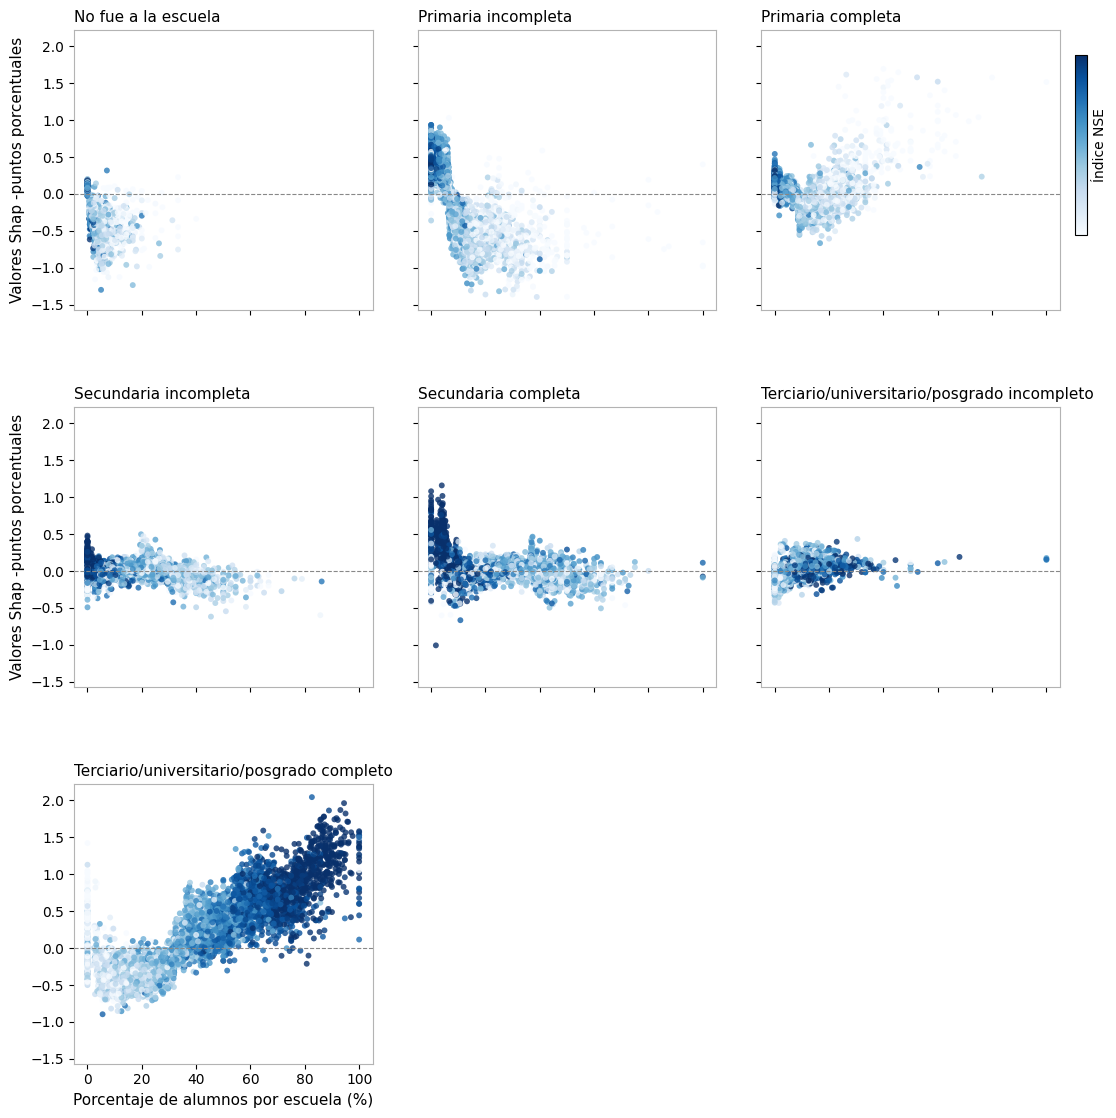

In [66]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_educacion_madre["NSE_puntaje"].min(), df_libros["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"Nivel_Ed_Madre_{i}.0_pct", f"Nivel_Ed_Madre_{i}.0_pct_shap") for i in range(1,8)]
titulos = {
    1: "No fue a la escuela",
    2: "Primaria incompleta",
    3: "Primaria completa",
    4: "Secundaria incompleta",
    5: "Secundaria completa",
    6: "Terciario/universitario/posgrado incompleto",
    7: "Terciario/universitario/posgrado completo"
}

# Figura y ejes
cols = 3
rows = math.ceil(len(pares) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_educacion_madre,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.8, 0.01,0.15])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [67]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_educacion_madre[ycol].mean(),
        "min_shap": df_educacion_madre[ycol].min(),
        "max_shap": df_educacion_madre[ycol].max(),
        "std_shap": df_educacion_madre[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0  Nivel_Ed_Madre_1.0         -0.030    -1.298     0.318     0.211  1.616
1  Nivel_Ed_Madre_2.0         -0.005    -1.394     1.031     0.473  2.424
2  Nivel_Ed_Madre_3.0          0.022    -0.665     1.694     0.164  2.359
3  Nivel_Ed_Madre_4.0          0.007    -0.617     0.498     0.081  1.115
4  Nivel_Ed_Madre_5.0          0.018    -1.006     1.159     0.126  2.166
5  Nivel_Ed_Madre_6.0          0.002    -0.433     0.434     0.096  0.867
6  Nivel_Ed_Madre_7.0          0.029    -0.896     2.044     0.469  2.940

Graficamos las opciones con más dispersión y menor/mayor shap: primaria incompleta y terciario/universitario/posgrado completo

In [68]:
vars=['NSE_puntaje','Nivel_Ed_Madre_2.0_pct','Nivel_Ed_Madre_2.0_pct_shap', 'Nivel_Ed_Madre_7.0_pct','Nivel_Ed_Madre_7.0_pct_shap']

df_educacion_madre=df_educacion_madre[vars]

col_excluir = ['NSE_puntaje']

df_educacion_madre.describe()

NSE_puntaje  Nivel_Ed_Madre_2.0_pct  Nivel_Ed_Madre_2.0_pct_shap  \
count  9085.000000             9085.000000                  9085.000000   
mean      0.160804                7.715784                    -0.004878   
std       0.496514                8.715867                     0.473179   
min      -2.626484                0.000000                    -1.393709   
25%      -0.166123                1.149425                    -0.435218   
50%       0.132295                5.555556                     0.182913   
75%       0.512578               11.111111                     0.399556   
max       1.422577              100.000000                     1.030594   

       Nivel_Ed_Madre_7.0_pct  Nivel_Ed_Madre_7.0_pct_shap  
count             9085.000000                  9085.000000  
mean                33.599690                     0.028796  
std                 21.316410                     0.468677  
min                  0.000000                    -0.895872  
25%                 17.857143                    -0.334640  
50%                 29.090909                    -0.139573  
75%                 45.714286                     0.330443  
max                100.000000                     2.043935

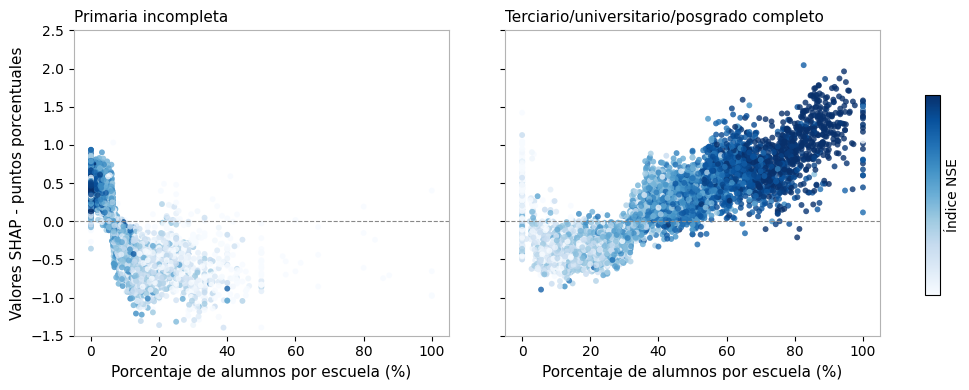

In [69]:
 #--- Figura con dos subplots, comparten eje Y ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    ("Nivel_Ed_Madre_2.0_pct", "Nivel_Ed_Madre_2.0_pct_shap", "Primaria incompleta"),
    ("Nivel_Ed_Madre_7.0_pct", "Nivel_Ed_Madre_7.0_pct_shap", "Terciario/universitario/posgrado completo")
]

for ax, (xcol, ycol, titulo) in zip(axes, pares):
    sns.scatterplot(
        data=df_educacion_madre,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_ylim(-1.5,2.5)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    if ax == axes[0]:
        ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Colorbar común a la derecha ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# Formato de ticks
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)
plt.show()

##### Educación Padre

In [70]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_educacion_padre = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [72]:
vars=['NSE_puntaje','Nivel_Ed_Padre_1.0_pct', 'Nivel_Ed_Padre_2.0_pct',
       'Nivel_Ed_Padre_3.0_pct', 'Nivel_Ed_Padre_4.0_pct',
       'Nivel_Ed_Padre_5.0_pct', 'Nivel_Ed_Padre_6.0_pct',
       'Nivel_Ed_Padre_7.0_pct', 'Nivel_Ed_Padre_1.0_pct_shap', 'Nivel_Ed_Padre_2.0_pct_shap',
       'Nivel_Ed_Padre_3.0_pct_shap', 'Nivel_Ed_Padre_4.0_pct_shap',
       'Nivel_Ed_Padre_5.0_pct_shap', 'Nivel_Ed_Padre_6.0_pct_shap',
       'Nivel_Ed_Padre_7.0_pct_shap']
df_educacion_padre=df_educacion_padre[vars]

df_educacion_padre.loc[:, ~df_educacion_padre.columns.isin(col_excluir)] *= 100
df_educacion_padre.head()

NSE_puntaje  Nivel_Ed_Padre_1.0_pct  Nivel_Ed_Padre_2.0_pct  \
0    -0.304836                6.060606               18.181818   
1     0.693485                0.000000                8.333333   
2     0.767152                0.000000                3.389831   
3     0.782374                0.000000                3.465347   
4     0.857615                0.000000                7.692308   

   Nivel_Ed_Padre_3.0_pct  Nivel_Ed_Padre_4.0_pct  Nivel_Ed_Padre_5.0_pct  \
0                7.070707               20.202020               26.262626   
1                0.000000               13.333333               31.666667   
2                8.474576               11.864407               20.338983   
3                0.495050               24.257426               26.237624   
4                0.000000               26.923077                3.846154   

   Nivel_Ed_Padre_6.0_pct  Nivel_Ed_Padre_7.0_pct  \
0                2.020202               20.202020   
1                5.000000               41.666667   
2               11.864407               44.067797   
3                8.415842               37.128713   
4                7.692308               53.846154   

   Nivel_Ed_Padre_1.0_pct_shap  Nivel_Ed_Padre_2.0_pct_shap  \
0                    -0.241155                    -0.273377   
1                     0.135135                    -0.001154   
2                     0.220016                     0.037785   
3                     0.118614                     0.094133   
4                     0.152870                     0.009224   

   Nivel_Ed_Padre_3.0_pct_shap  Nivel_Ed_Padre_4.0_pct_shap  \
0                    -0.014410                     0.052593   
1                     0.309782                    -0.069614   
2                    -0.093912                    -0.157012   
3                     0.294863                    -0.083486   
4                     0.215928                    -0.067517   

   Nivel_Ed_Padre_5.0_pct_shap  Nivel_Ed_Padre_6.0_pct_shap  \
0                     0.114371                     0.002115   
1                    -0.093424                     0.005967   
2                     0.017804                    -0.021402   
3                     0.027786                     0.038386   
4                     0.537149                     0.092941   

   Nivel_Ed_Padre_7.0_pct_shap  
0                    -0.147617  
1                     0.161373  
2                     0.136429  
3                    -0.010970  
4                     0.667153

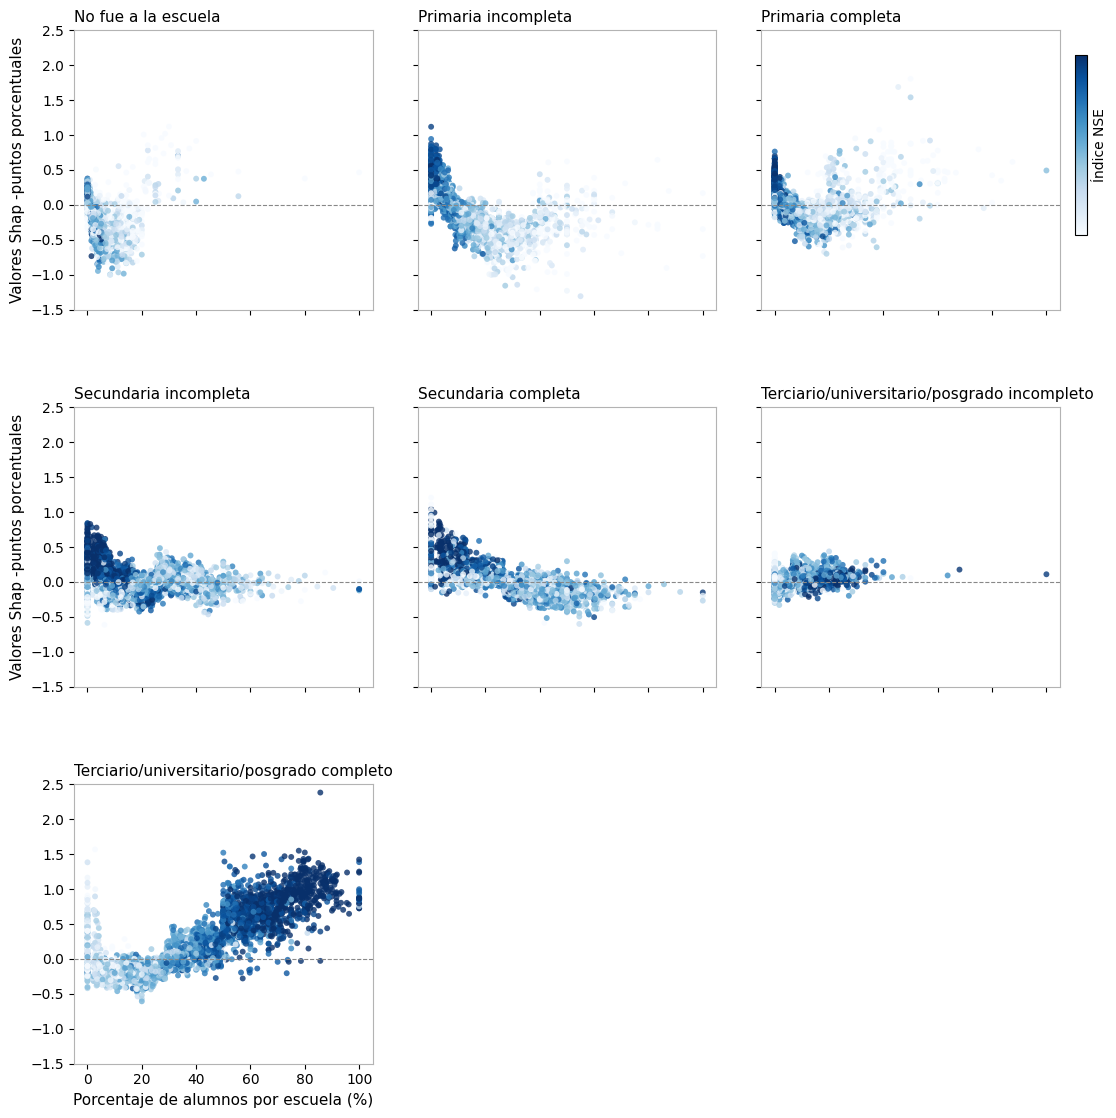

In [74]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_educacion_padre["NSE_puntaje"].min(), df_libros["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"Nivel_Ed_Padre_{i}.0_pct", f"Nivel_Ed_Padre_{i}.0_pct_shap") for i in range(1,8)]
titulos = {
    1: "No fue a la escuela",
    2: "Primaria incompleta",
    3: "Primaria completa",
    4: "Secundaria incompleta",
    5: "Secundaria completa",
    6: "Terciario/universitario/posgrado incompleto",
    7: "Terciario/universitario/posgrado completo"
}

# Figura y ejes
cols = 3
rows = math.ceil(len(pares) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_educacion_padre,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    ax.set_ylim(-1.5,2.5)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.8, 0.01,0.15])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [75]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_educacion_padre[ycol].mean(),
        "min_shap": df_educacion_padre[ycol].min(),
        "max_shap": df_educacion_padre[ycol].max(),
        "std_shap": df_educacion_padre[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0  Nivel_Ed_Padre_1.0         -0.011    -1.002     1.122     0.242  2.124
1  Nivel_Ed_Padre_2.0         -0.017    -1.308     1.119     0.283  2.427
2  Nivel_Ed_Padre_3.0          0.016    -0.700     1.805     0.180  2.505
3  Nivel_Ed_Padre_4.0         -0.008    -0.614     0.843     0.144  1.458
4  Nivel_Ed_Padre_5.0          0.028    -0.602     1.208     0.166  1.809
5  Nivel_Ed_Padre_6.0          0.006    -0.331     0.437     0.078  0.768
6  Nivel_Ed_Padre_7.0          0.024    -0.606     2.384     0.330  2.990

Graficamos las opciones con más dispersión y menor/mayor shap: primaria incompleta y terciario/universitario/posgrado completo

In [76]:
vars=['NSE_puntaje','Nivel_Ed_Padre_2.0_pct','Nivel_Ed_Padre_2.0_pct_shap', 'Nivel_Ed_Padre_7.0_pct','Nivel_Ed_Padre_7.0_pct_shap']

df_educacion_padre=df_educacion_padre[vars]

col_excluir = ['NSE_puntaje']

df_educacion_padre.describe()

NSE_puntaje  Nivel_Ed_Padre_2.0_pct  Nivel_Ed_Padre_2.0_pct_shap  \
count  9085.000000             9085.000000                  9085.000000   
mean      0.160804               10.684091                    -0.016960   
std       0.496514               10.202505                     0.282721   
min      -2.626484                0.000000                    -1.307824   
25%      -0.166123                3.225806                    -0.223570   
50%       0.132295                8.661417                    -0.032279   
75%       0.512578               15.384615                     0.182906   
max       1.422577              100.000000                     1.119055   

       Nivel_Ed_Padre_7.0_pct  Nivel_Ed_Padre_7.0_pct_shap  
count             9085.000000                  9085.000000  
mean                27.498989                     0.024087  
std                 19.368049                     0.329721  
min                  0.000000                    -0.606089  
25%                 13.924051                    -0.177201  
50%                 23.076923                    -0.103836  
75%                 36.842105                     0.109153  
max                100.000000                     2.383565

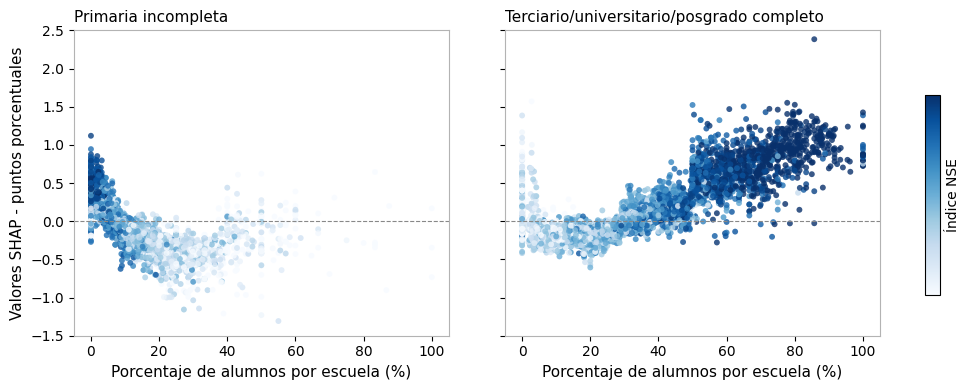

In [77]:
 #--- Figura con dos subplots, comparten eje Y ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    ("Nivel_Ed_Padre_2.0_pct", "Nivel_Ed_Padre_2.0_pct_shap", "Primaria incompleta"),
    ("Nivel_Ed_Padre_7.0_pct", "Nivel_Ed_Padre_7.0_pct_shap", "Terciario/universitario/posgrado completo")
]

for ax, (xcol, ycol, titulo) in zip(axes, pares):
    sns.scatterplot(
        data=df_educacion_padre,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)
    
    ax.set_ylim(-1.5,2.5)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    if ax == axes[0]:
        ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Colorbar común a la derecha ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# Formato de ticks
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)
plt.show()


##### Personas por habitación

In [78]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_personas_por_habitacion = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [79]:
variables.loc[variables['desc_variable']=='Personas por habitación']['variable_a_nivel_colegio'].unique()

array([], dtype=object)

In [80]:
vars=['NSE_puntaje','personas_por_habitacion','personas_por_habitacion_shap']
df_personas_por_habitacion=df_personas_por_habitacion[vars]

df_personas_por_habitacion['personas_por_habitacion_shap']*= 100
df_personas_por_habitacion.head()

NSE_puntaje  personas_por_habitacion  personas_por_habitacion_shap
0    -0.304836                 2.362734                     -1.690427
1     0.693485                 1.443866                      1.199223
2     0.767152                 1.266652                      1.466467
3     0.782374                 1.311107                      1.271150
4     0.857615                 1.146528                      2.226521

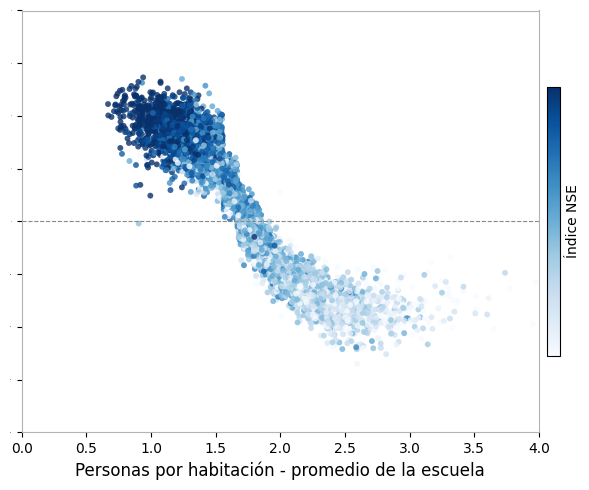

In [82]:
df=df_personas_por_habitacion.copy()
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df["NSE_puntaje"].min(), df["NSE_puntaje"].max())

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="personas_por_habitacion", y="personas_por_habitacion_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
ax.set_xlim(0,4)
# Ejes y formato
ax.set_xlabel("Personas por habitación - promedio de la escuela", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.set_ylim(-4,4)
ax.tick_params(axis="y", labelsize=0)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))

# Colorbar para NSE
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.015)
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


fig.tight_layout()

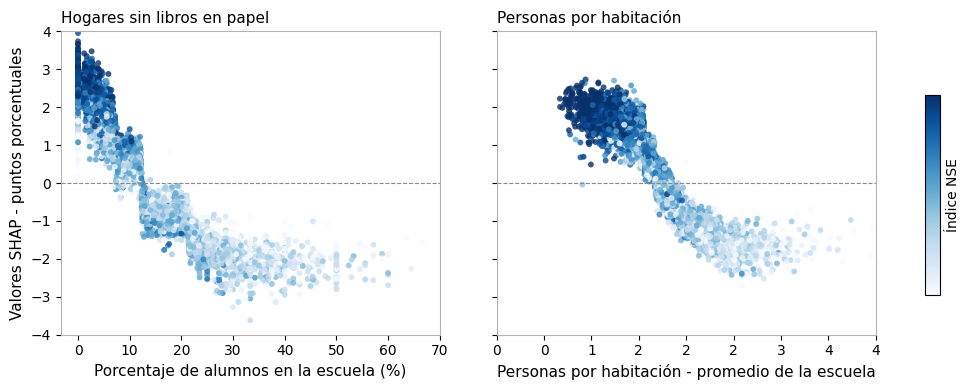

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    # (dataframe, xcol, ycol, titulo, xlabel)
    (df_libros, "ap10_1_pct", "ap10_1_pct_shap", "Hogares sin libros en papel", "Porcentaje de alumnos en la escuela (%)"),
    (df_personas_por_habitacion, "personas_por_habitacion", "personas_por_habitacion_shap", "Personas por habitación", "Personas por habitación - promedio de la escuela"),
]

for ax, (data, xcol, ycol, titulo, xlabel) in zip(axes, pares):
    sns.scatterplot(
        data=data,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )

    # Línea guía en 0
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

    # Spines iguales al otro panel
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE)
        sp.set_linewidth(0.8)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)

# --- Eje Y compartido (mismo 0, mismo rango) ---
# Elegí un rango común (ajustalo a lo que te sirva):
axes[0].set_ylim(-4, 4)

# Etiqueta Y solo en el primer subplot
axes[0].set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
axes[1].set_ylabel("")

# --- Formato de ticks X (como en tu panel de educación) ---
# Si tus X ya están en 0-100, esto está bien (sin *100).
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Si querés límites específicos por variable, ponelos acá:
# axes[0].set_xlim(0, 100)   # por ejemplo para porcentajes
# axes[1].set_xlim(0, 4)     # como venías usando
axes[1].set_xlim(0, 4)

# --- Colorbar común a la derecha (MISMO estilo/ancho que educación) ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])  # ancho 0.015 como en tu primer panel
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# --- Layout igual al otro panel ---
plt.tight_layout(rect=[0, 0, 0.9, 1])  # deja lugar para la colorbar
plt.subplots_adjust(wspace=0.15)

##### 3.2.2.2 Factores individuales

Probamos las top 6, dado que excluimos "Buscar leña o agua potable", 'Computadora', 'Libros en el hogar', 'Personas por habitación', 'Nivel educativo madre' y 'Nivel educativo Padre'.

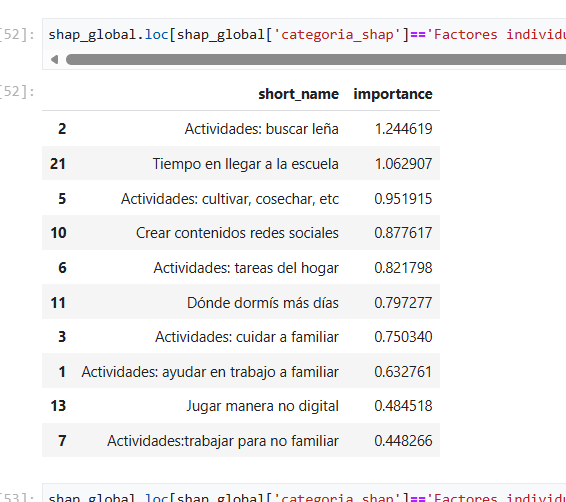

##### Buscar leña, agua potable, etc

In [84]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_lena_agua_potable = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [85]:
variables.loc[variables['desc_variable']=='La semana pasada, ¿hiciste lo siguiente? ¿por cuánto tiempo?  [Buscar agua o leña fuera de casa]']['variable_a_nivel_colegio'].unique()

array(['ap06d_1_pct', 'ap06d_2_pct', 'ap06d_3_pct', 'ap06d_4_pct'],
      dtype=object)

In [86]:
vars=['NSE_puntaje','ap06d_1_pct', 'ap06d_2_pct', 'ap06d_3_pct', 'ap06d_4_pct', 'ap06d_1_pct_shap', 'ap06d_2_pct_shap', 'ap06d_3_pct_shap', 'ap06d_4_pct_shap']
df_lena_agua_potable=df_lena_agua_potable[vars]

df_lena_agua_potable.loc[:, ~df_lena_agua_potable.columns.isin(col_excluir)] *= 100
df_lena_agua_potable.head()

NSE_puntaje  ap06d_1_pct  ap06d_2_pct  ap06d_3_pct  ap06d_4_pct  \
0    -0.304836    81.159420    10.144928     2.898551     5.797101   
1     0.693485    98.214286     1.785714     0.000000     0.000000   
2     0.767152    71.153846    25.000000     1.923077     1.923077   
3     0.782374    93.229167     4.166667     0.000000     2.604167   
4     0.857615    61.538462    38.461538     0.000000     0.000000   

   ap06d_1_pct_shap  ap06d_2_pct_shap  ap06d_3_pct_shap  ap06d_4_pct_shap  
0         -0.028119          0.023090          0.085280         -0.582680  
1          0.666563          0.211248          0.153203          0.390936  
2         -0.475750         -0.186245          0.093577          0.322983  
3          0.584505         -0.000564          0.132745         -0.069286  
4         -0.348820         -0.179279          0.102616          0.306114

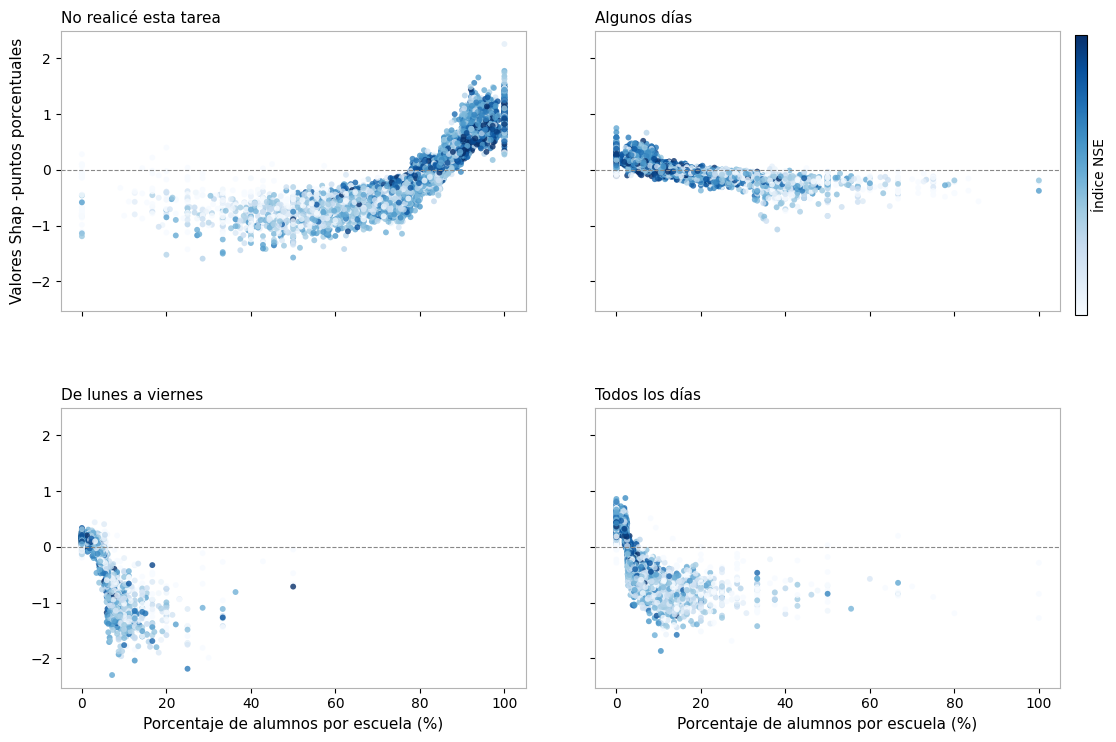

In [87]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap06d_{i}_pct", f"ap06d_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "No realicé esta tarea",
    2: "Algunos días",
    3: "De lunes a viernes",
    4: "Todos los días",
    }

# Figura y ejes
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_lena_agua_potable,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")


cax = fig.add_axes([0.90, 0.6, 0.01,0.35])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [88]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_lena_agua_potable[ycol].mean(),
        "min_shap": df_lena_agua_potable[ycol].min(),
        "max_shap": df_lena_agua_potable[ycol].max(),
        "std_shap": df_lena_agua_potable[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0   ap06d_1         -0.035    -1.594     2.258     0.577  3.852
1   ap06d_2          0.002    -1.070     0.749     0.142  1.819
2   ap06d_3          0.010    -2.299     0.442     0.324  2.741
3   ap06d_4         -0.042    -1.867     0.878     0.511  2.744

Graficamos las opciones con más dispersión y menor/mayor shap: No realicé esta tarea

In [89]:
vars=['NSE_puntaje','ap06d_1_pct','ap06d_1_pct_shap']

df_lena_agua_potable=df_lena_agua_potable[vars]

col_excluir = ['NSE_puntaje']

df_lena_agua_potable.describe()

NSE_puntaje  ap06d_1_pct  ap06d_1_pct_shap
count  9085.000000  9085.000000       9085.000000
mean      0.160804    78.067794         -0.034945
std       0.496514    15.884022          0.576889
min      -2.626484     0.000000         -1.593546
25%      -0.166123    70.370370         -0.496979
50%       0.132295    81.538462         -0.110056
75%       0.512578    89.285714          0.379258
max       1.422577   100.000000          2.258194

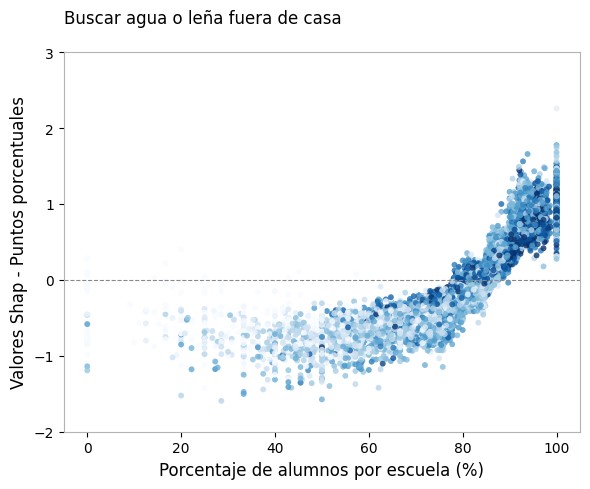

In [90]:
df=df_lena_agua_potable.copy()
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df["NSE_puntaje"].min(), df["NSE_puntaje"].max())

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="ap06d_1_pct", y="ap06d_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
ax.set_ylim(-2,3)
ax.set_title("Buscar agua o leña fuera de casa \n", loc="left")


for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


fig.tight_layout()

##### Cultivar, cosechar, etc

In [91]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_cultivar_cosechar_ordenar = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [92]:
vars=['NSE_puntaje','ap06e_1_pct', 'ap06e_2_pct', 'ap06e_3_pct', 'ap06e_4_pct','ap06e_1_pct_shap', 'ap06e_2_pct_shap', 'ap06e_3_pct_shap', 'ap06e_4_pct_shap']
df_cultivar_cosechar_ordenar=df_cultivar_cosechar_ordenar[vars]

df_cultivar_cosechar_ordenar.loc[:, ~df_cultivar_cosechar_ordenar.columns.isin(col_excluir)] *= 100
df_cultivar_cosechar_ordenar.head()

NSE_puntaje  ap06e_1_pct  ap06e_2_pct  ap06e_3_pct  ap06e_4_pct  \
0    -0.304836    73.913043    14.492754     2.898551     8.695652   
1     0.693485    89.285714     8.928571     0.000000     1.785714   
2     0.767152    79.245283    16.981132     1.886792     1.886792   
3     0.782374    91.666667     5.729167     0.520833     2.083333   
4     0.857615    65.384615    34.615385     0.000000     0.000000   

   ap06e_1_pct_shap  ap06e_2_pct_shap  ap06e_3_pct_shap  ap06e_4_pct_shap  
0         -0.263710          0.003659         -0.240347         -0.525363  
1          0.446419         -0.003629          0.307589          0.245807  
2          0.001595          0.099785         -0.076244          0.196174  
3          0.364826         -0.125217          0.140082          0.203202  
4         -0.637071         -0.110359          0.342962          0.358043

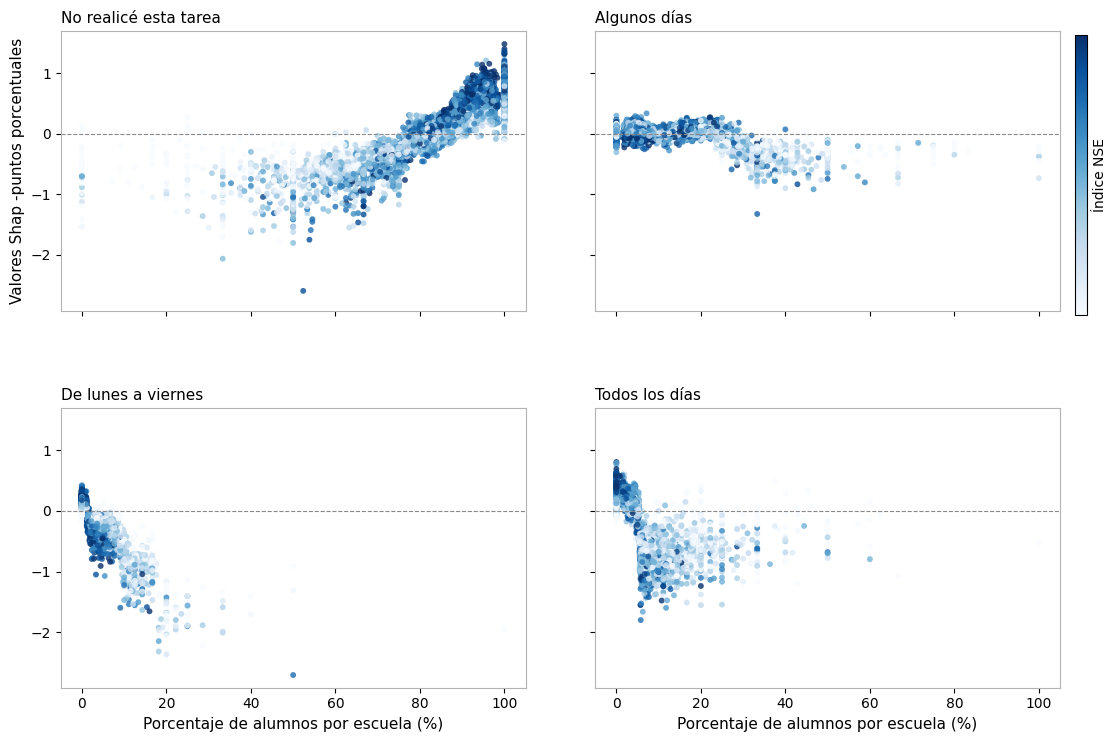

In [93]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_cultivar_cosechar_ordenar["NSE_puntaje"].min(), df_cultivar_cosechar_ordenar["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap06e_{i}_pct", f"ap06e_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "No realicé esta tarea",
    2: "Algunos días",
    3: "De lunes a viernes",
    4: "Todos los días",
    }

# Figura y ejes
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_cultivar_cosechar_ordenar,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.6, 0.01,0.35])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [94]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_cultivar_cosechar_ordenar[ycol].mean(),
        "min_shap": df_cultivar_cosechar_ordenar[ycol].min(),
        "max_shap": df_cultivar_cosechar_ordenar[ycol].max(),
        "std_shap": df_cultivar_cosechar_ordenar[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0   ap06e_1          0.019    -2.593     1.484     0.422  4.077
1   ap06e_2         -0.011    -1.323     0.339     0.107  1.662
2   ap06e_3         -0.036    -2.710     0.425     0.295  3.135
3   ap06e_4         -0.060    -1.802     0.809     0.442  2.611

Graficamos las opciones con más dispersión y menor/mayor shap: No realicé esta tarea

In [95]:
vars=['NSE_puntaje','ap06e_1_pct','ap06e_1_pct_shap']

df_cultivar_cosechar_ordenar=df_cultivar_cosechar_ordenar[vars]

col_excluir = ['NSE_puntaje']

df_cultivar_cosechar_ordenar.describe()

NSE_puntaje  ap06e_1_pct  ap06e_1_pct_shap
count  9085.000000  9085.000000       9085.000000
mean      0.160804    81.261484          0.019409
std       0.496514    13.697786          0.422231
min      -2.626484     0.000000         -2.592981
25%      -0.166123    75.000000         -0.234323
50%       0.132295    84.210526         -0.000821
75%       0.512578    90.322581          0.293469
max       1.422577   100.000000          1.484252

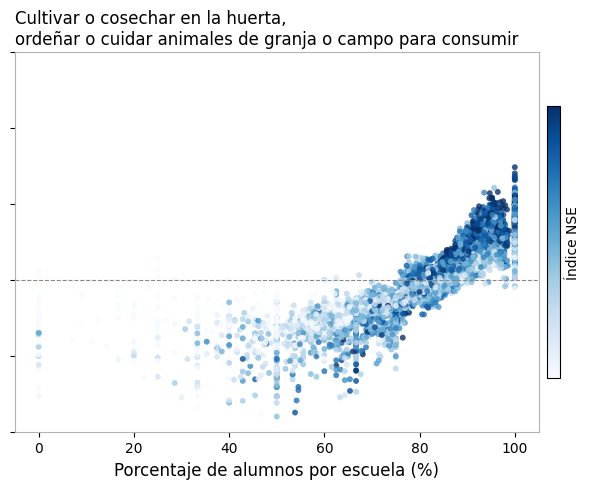

In [96]:
df=df_cultivar_cosechar_ordenar.copy()
cmap = sns.color_palette("Blues", as_cmap=True)

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="ap06e_1_pct", y="ap06e_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))
ax.set_ylim(-2,3)
ax.set_title("Cultivar o cosechar en la huerta,\nordeñar o cuidar animales de granja o campo para consumir", loc="left")
ax.set_yticklabels([])
# Colorbar para NSE
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.015)
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


fig.tight_layout()


In [97]:
bins = np.arange(0, 110, 10)  # crea los intervalos 0-10, 10-20, ..., 90-100
labels = [f"{i}-{i+10}" for i in range(0, 100, 10)]

df_cultivar_cosechar_ordenar["rango"] = pd.cut(df_cultivar_cosechar_ordenar["ap06e_1_pct"], bins=bins, labels=labels, include_lowest=True, right=False)

conteo = df_cultivar_cosechar_ordenar["rango"].value_counts().sort_index()
conteo

rango
0-10        32
10-20        9
20-30       34
30-40       50
40-50      111
50-60      367
60-70      818
70-80     1786
80-90     3410
90-100    2080
Name: count, dtype: int64

In [98]:
#Umbral a partir del cual son siempre positivos (antes sacamos los outliers que se ven en el gráfico)
outliers = df_cultivar_cosechar_ordenar.loc[
    (df_cultivar_cosechar_ordenar['ap06e_1_pct'] > df_cultivar_cosechar_ordenar['ap06e_1_pct'].quantile(0.90)) &
    (df_cultivar_cosechar_ordenar['ap06e_1_pct_shap'] < 0)
]

len(outliers)
outliers

df_clean = df_cultivar_cosechar_ordenar.drop(outliers.index)

umbral = (
    df_clean.sort_values('ap06e_1_pct', ascending=False)
    .assign(cmin=lambda d: d['ap06e_1_pct_shap'].cummin())
    .loc[lambda d: d['cmin'] > 0, 'ap06e_1_pct']
    .min()
)
print(umbral)

df_clean.loc[df_clean['ap06e_1_pct']>umbral]['ap06e_1_pct_shap'].min()

94.44444444444444


0.0117604189326812

##### Tareas domésticas: limpiar, lavar ropa, platos, etc

In [99]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_tareas_domesticas = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [100]:
variables.loc[variables['desc_variable']=='La semana pasada, ¿hiciste lo siguiente? ¿por cuánto tiempo?  [Realizar distintas tareas como limpiar, lavar platos o ropa, cocinar, hacer las compras, cuidar animales domésticos, etc.]']['variable_a_nivel_colegio'].unique()

array(['ap06c_1_pct', 'ap06c_2_pct', 'ap06c_3_pct', 'ap06c_4_pct'],
      dtype=object)

In [101]:
vars=['NSE_puntaje','ap06c_1_pct', 'ap06c_2_pct', 'ap06c_3_pct', 'ap06c_4_pct','ap06c_1_pct_shap', 'ap06c_2_pct_shap', 'ap06c_3_pct_shap', 'ap06c_4_pct_shap']
df_tareas_domesticas=df_tareas_domesticas[vars]

df_tareas_domesticas.loc[:, ~df_tareas_domesticas.columns.isin(col_excluir)] *= 100
df_tareas_domesticas.head()

NSE_puntaje  ap06c_1_pct  ap06c_2_pct  ap06c_3_pct  ap06c_4_pct  \
0    -0.304836    13.157895    44.736842     9.210526    32.894737   
1     0.693485    19.298246    52.631579    10.526316    17.543860   
2     0.767152    16.363636    54.545455    12.727273    16.363636   
3     0.782374    11.734694    59.183673     9.693878    19.387755   
4     0.857615     7.692308    65.384615    15.384615    11.538462   

   ap06c_1_pct_shap  ap06c_2_pct_shap  ap06c_3_pct_shap  ap06c_4_pct_shap  
0          0.373148         -0.042672          0.081064          0.033781  
1          0.148230          0.082127          0.006714          0.046024  
2          0.226317         -0.125113         -0.016395         -0.028207  
3          0.237550          0.375004         -0.009549         -0.203384  
4          1.233471          0.346250         -0.018757         -0.017706

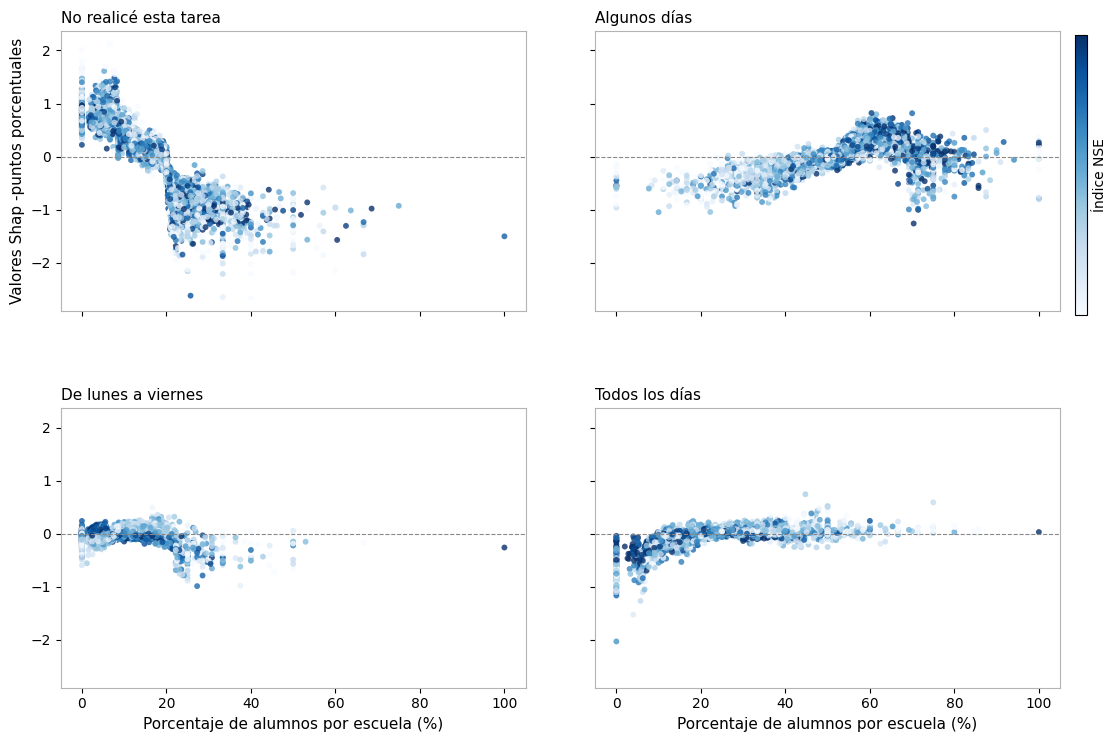

In [102]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_tareas_domesticas["NSE_puntaje"].min(), df_tareas_domesticas["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap06c_{i}_pct", f"ap06c_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "No realicé esta tarea",
    2: "Algunos días",
    3: "De lunes a viernes",
    4: "Todos los días",
    }

# Figura y ejes
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_tareas_domesticas,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.6, 0.01,0.35])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [103]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_tareas_domesticas[ycol].mean(),
        "min_shap": df_tareas_domesticas[ycol].min(),
        "max_shap": df_tareas_domesticas[ycol].max(),
        "std_shap": df_tareas_domesticas[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0   ap06c_1          0.122    -2.663     2.121     0.608  4.784
1   ap06c_2         -0.000    -1.260     0.821     0.243  2.081
2   ap06c_3         -0.002    -0.988     0.493     0.099  1.481
3   ap06c_4          0.002    -2.031     0.743     0.132  2.774

Graficamos las opciones con más dispersión y menor/mayor shap: No realicé esta tarea

In [104]:
vars=['NSE_puntaje','ap06c_1_pct','ap06c_1_pct_shap']

df_tareas_domesticas=df_tareas_domesticas[vars]

col_excluir = ['NSE_puntaje']

df_tareas_domesticas.describe()

NSE_puntaje  ap06c_1_pct  ap06c_1_pct_shap
count  9085.000000  9085.000000       9085.000000
mean      0.160804    14.651535          0.122476
std       0.496514     8.383042          0.607823
min      -2.626484     0.000000         -2.662833
25%      -0.166123     9.259259         -0.013746
50%       0.132295    13.888889          0.194467
75%       0.512578    18.918919          0.493079
max       1.422577   100.000000          2.121212

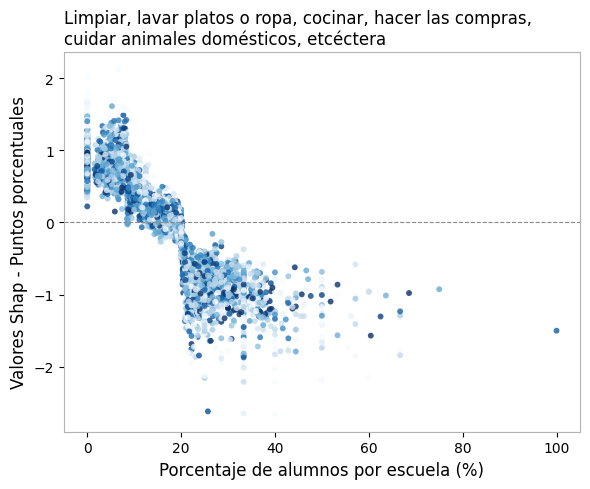

In [106]:
df=df_tareas_domesticas.copy()
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df["NSE_puntaje"].min(), df["NSE_puntaje"].max())

fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    data=df,
    x="ap06c_1_pct", y="ap06c_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))
ax.set_title("Limpiar, lavar platos o ropa, cocinar, hacer las compras, \ncuidar animales domésticos, etcéctera", loc="left")

# Colorbar para NSE
#sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#sm.set_array([])
#cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.015)
#cbar.set_ticks([])
#cbar.set_label("Índice NSE", fontsize=10)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)


fig.tight_layout()

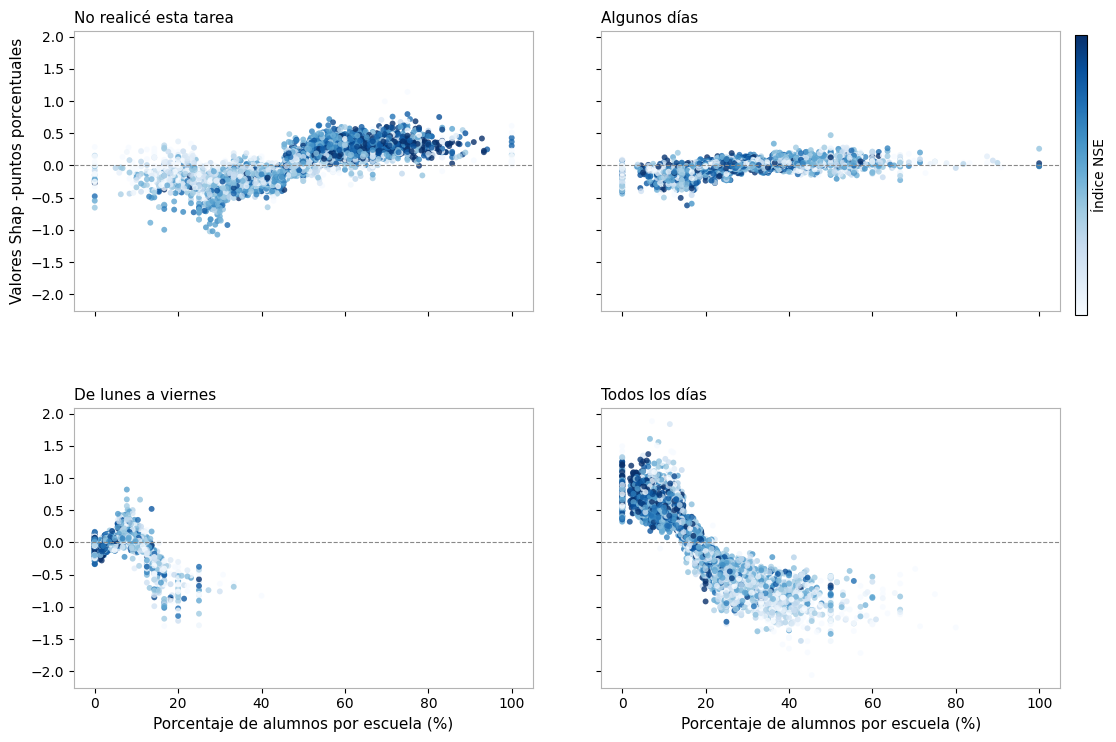

In [107]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_cuidar_a_familiar = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)


vars=['NSE_puntaje','ap06a_1_pct', 'ap06a_2_pct', 'ap06a_3_pct', 'ap06a_4_pct','ap06a_1_pct_shap', 'ap06a_2_pct_shap', 'ap06a_3_pct_shap', 'ap06a_4_pct_shap']
df_cuidar_a_familiar=df_cuidar_a_familiar[vars]

df_cuidar_a_familiar.loc[:, ~df_cuidar_a_familiar.columns.isin(col_excluir)] *= 100
df_cuidar_a_familiar.head()

COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_tareas_domesticas["NSE_puntaje"].min(), df_tareas_domesticas["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap06a_{i}_pct", f"ap06a_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "No realicé esta tarea",
    2: "Algunos días",
    3: "De lunes a viernes",
    4: "Todos los días",
    }

# Figura y ejes
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_cuidar_a_familiar,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.6, 0.01,0.35])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

##### Tiempo en llegar a la escuela

In [108]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_tiempo_en_llegar_a_la_escuela = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [109]:
vars=['NSE_puntaje','ap26_1_pct', 'ap26_2_pct', 'ap26_3_pct', 'ap26_4_pct','ap26_1_pct_shap', 'ap26_2_pct_shap', 'ap26_3_pct_shap', 'ap26_4_pct_shap']
df_tiempo_en_llegar_a_la_escuela=df_tiempo_en_llegar_a_la_escuela[vars]

df_tiempo_en_llegar_a_la_escuela.loc[:, ~df_tiempo_en_llegar_a_la_escuela.columns.isin(col_excluir)] *= 100
df_tiempo_en_llegar_a_la_escuela.head()

NSE_puntaje  ap26_1_pct  ap26_2_pct  ap26_3_pct  ap26_4_pct  \
0    -0.304836   82.500000    8.750000    2.500000        6.25   
1     0.693485   96.363636    1.818182    1.818182        0.00   
2     0.767152  100.000000    0.000000    0.000000        0.00   
3     0.782374   93.989071    6.010929    0.000000        0.00   
4     0.857615  100.000000    0.000000    0.000000        0.00   

   ap26_1_pct_shap  ap26_2_pct_shap  ap26_3_pct_shap  ap26_4_pct_shap  
0        -0.509936         0.032547         0.127382        -0.928211  
1         0.611705         0.156519         0.066594         0.204194  
2         0.811257        -0.001673         0.191943         0.177785  
3         0.063014         0.037635         0.076948         0.117706  
4         0.932415         0.008919         0.118467         0.141102

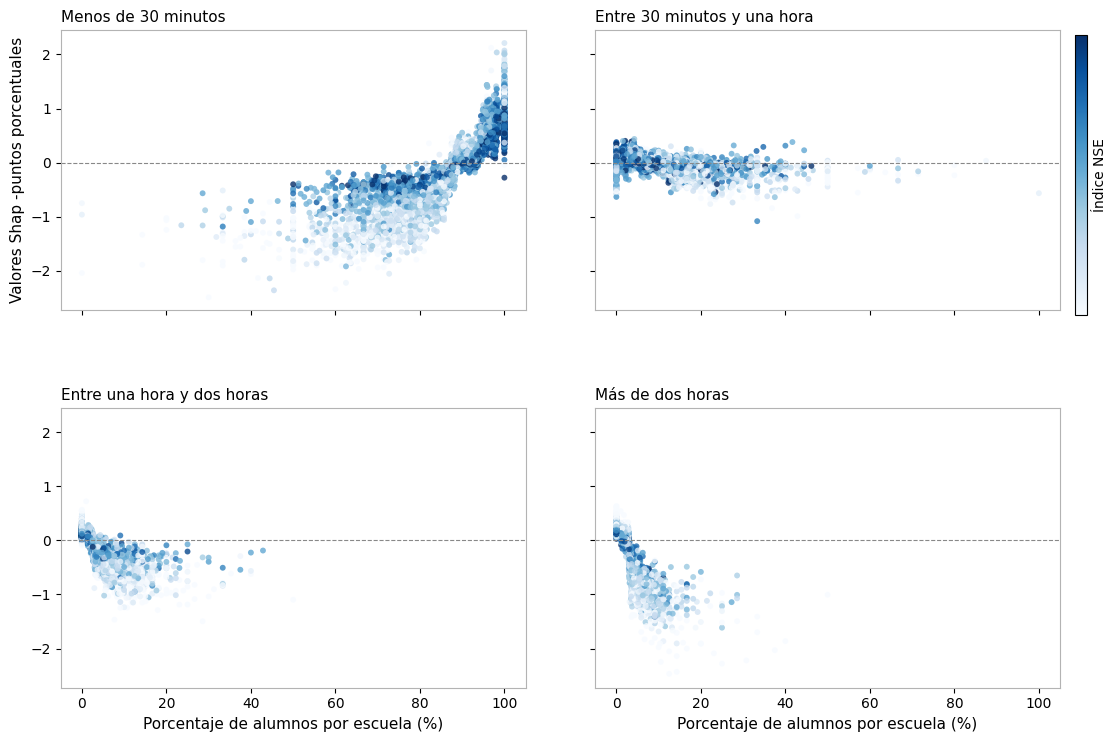

In [111]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_tiempo_en_llegar_a_la_escuela["NSE_puntaje"].min(), df_tiempo_en_llegar_a_la_escuela["NSE_puntaje"].max())

# Pares (x,y) y etiquetas ddf_tiempo_en_llegar_a_la_escuelae título (ajustalas si tus tramos son otros)
pares = [(f"ap26_{i}_pct", f"ap26_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "Menos de 30 minutos",
    2: "Entre 30 minutos y una hora",
    3: "Entre una hora y dos horas",
    4: "Más de dos horas",
    }

# Figura y ejes
cols = 2
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_tiempo_en_llegar_a_la_escuela,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.6, 0.01,0.35])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()


In [112]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_tiempo_en_llegar_a_la_escuela[ycol].mean(),
        "min_shap": df_tiempo_en_llegar_a_la_escuela[ycol].min(),
        "max_shap": df_tiempo_en_llegar_a_la_escuela[ycol].max(),
        "std_shap": df_tiempo_en_llegar_a_la_escuela[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0    ap26_1         -0.109    -2.489     2.209     0.639  4.698
1    ap26_2         -0.018    -1.082     0.437     0.127  1.519
2    ap26_3         -0.040    -1.497     0.721     0.249  2.217
3    ap26_4          0.015    -2.467     0.631     0.387  3.098

Graficamos las opciones con más dispersión y menor/mayor shap: No realicé esta tarea

In [113]:
vars=['NSE_puntaje','ap26_1_pct','ap26_1_pct_shap']

df_tiempo_en_llegar_a_la_escuela=df_tiempo_en_llegar_a_la_escuela[vars]

col_excluir = ['NSE_puntaje']

df_tiempo_en_llegar_a_la_escuela.describe()

NSE_puntaje   ap26_1_pct  ap26_1_pct_shap
count  9085.000000  9085.000000      9085.000000
mean      0.160804    86.780922        -0.108532
std       0.496514    10.413094         0.639296
min      -2.626484     0.000000        -2.489148
25%      -0.166123    82.022472        -0.507045
50%       0.132295    88.732394        -0.023104
75%       0.512578    93.877551         0.263685
max       1.422577   100.000000         2.209305

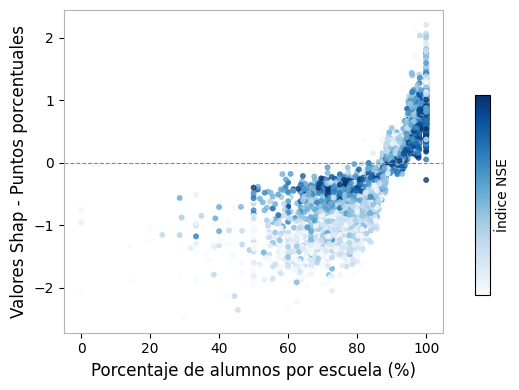

In [115]:
df = df_tiempo_en_llegar_a_la_escuela.copy()
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df["NSE_puntaje"].min(), df["NSE_puntaje"].max())


# === Figura con geometría de 2 paneles ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax = axes[0]


fig.delaxes(axes[1])

sns.scatterplot(
    data=df,
    x="ap26_1_pct", y="ap26_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))


for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)

    

# === Colorbar pegada EXACTAMENTE igual que en panel doble ===
cax = fig.add_axes([0.48, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# === Layout idéntico al panel doble ===
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)


In [117]:
# 1️⃣ Crear terciles del NSE_puntaje
df["tercil_NSE"] = pd.qcut(df["NSE_puntaje"], q=3, labels=["Bajo NSE", "Medio NSE", "Alto NSE"])

# 2️⃣ Crear rangos del porcentaje de alumnos (puedes ajustar los cortes)
bins = [0, 70, 90, 100]
labels = ["<=70%", "70–90%", ">90%"]
df["rango_pct"] = pd.cut(df["ap26_1_pct"], bins=bins, labels=labels, include_lowest=True)

# 3️⃣ Calcular el promedio del SHAP por tercil y rango
tabla_resumen = (
    df.groupby(["tercil_NSE", "rango_pct"])["ap26_1_pct_shap"]
      .mean()
      .reset_index()
      .pivot(index="rango_pct", columns="tercil_NSE", values="ap26_1_pct_shap")
      .round(3)
)

tabla_resumen


tercil_NSE  Bajo NSE  Medio NSE  Alto NSE
rango_pct                                
<=70%         -1.319     -0.781    -0.532
70–90%        -0.600     -0.367    -0.215
>90%           0.554      0.425     0.403

In [118]:
#correlaciones

df_tiempo_llegar_escuela_stats=df_tiempo_en_llegar_a_la_escuela[['ap26_1_pct','ap26_1_pct_shap']].copy()
x_col = "ap26_1_pct"
y_col = "ap26_1_pct_shap"

# Bins: [0,0.4], (0.4,0.8], (0.8,1.0]
labels = ["0–70%", "70–95%", "95–100%"]
df_tiempo_llegar_escuela_stats["tramo"] = pd.cut(
    df_tiempo_llegar_escuela_stats[x_col],
    bins=[0.0, 70, 95, 100],
    labels=labels,
    include_lowest=True,   
    right=True)

# Función de estadísticos por tramo
def _corr_stats(g):
    n = len(g)
    out = {
        "n": n,
        "x_mean": g[x_col].mean(),
        "y_mean": g[y_col].mean(),
        "pearson_r": np.nan,
        "spearman_rho": np.nan,
    }
    if n >= 2:
        out["pearson_r"]   = g[x_col].corr(g[y_col], method="pearson")
        out["spearman_rho"] = g[x_col].corr(g[y_col], method="spearman")
    return pd.Series(out)

corr_por_tramo = (
    df_tiempo_llegar_escuela_stats.groupby("tramo", observed=True)
       .apply(_corr_stats)
       .reset_index()
)

# Orden agradable
corr_por_tramo = corr_por_tramo[
    ["tramo", "n", "x_mean", "y_mean", "pearson_r", "spearman_rho"]
].round(3)

corr_por_tramo

tramo       n  x_mean  y_mean  pearson_r  spearman_rho
0    0–70%   589.0  60.128  -1.114      0.180         0.183
1   70–95%  6670.0  86.044  -0.256      0.867         0.897
2  95–100%  1826.0  98.070   0.754      0.539         0.574

##### Contenido redes sociales

En los bajos que no crean, el SHAP mes ás positivo?

In [119]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_contenido_redes = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [120]:
vars=['NSE_puntaje','ap05h_1_pct','ap05h_1_pct_shap']
df_contenido_redes=df_contenido_redes[vars]

col_excluir = ['NSE_puntaje']
df_contenido_redes.loc[:, ~df_contenido_redes.columns.isin(col_excluir)] *= 100
df_contenido_redes.head()


NSE_puntaje  ap05h_1_pct  ap05h_1_pct_shap
0    -0.304836    38.666667          0.164275
1     0.693485    37.037037          0.021294
2     0.767152    64.150943         -1.178462
3     0.782374    41.935484         -0.163130
4     0.857615    54.166667         -0.952187

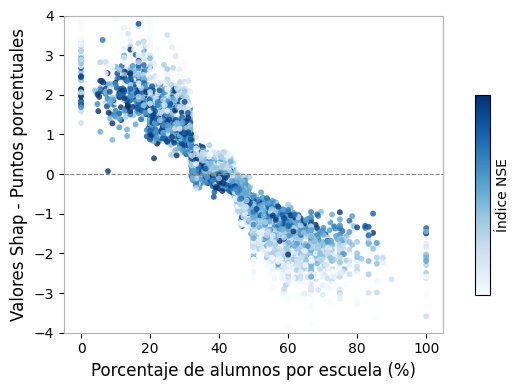

In [121]:
df=df_contenido_redes.copy()

map = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df["NSE_puntaje"].min(), df["NSE_puntaje"].max())


# === Figura con geometría de 2 paneles ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax = axes[0]


fig.delaxes(axes[1])

sns.scatterplot(
    data=df,
    x="ap05h_1_pct", y="ap05h_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)


# Línea guía en 0 (eje Y)
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Ejes y formato
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x*100:.0f}"))
ax.set_ylim(-4,4)

for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)

    

# === Colorbar pegada EXACTAMENTE igual que en panel doble ===
cax = fig.add_axes([0.48, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# === Layout idéntico al panel doble ===
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)


plt.show()
plt.close(fig)


In [122]:
#¿Cómo afecta según el NSE?

p33 = np.percentile(df["NSE_puntaje"], 33) 
p90 = np.percentile(df["NSE_puntaje"], 90)

# Función para clasificar según percentiles
def clasificar_nse(puntaje):
    if puntaje <= p33:
        return "bajo"
    elif puntaje >= p90:
        return "alto"
    else:
        return "medio"

# Aplicar al DataFrame
df["NSE_nivel_grupo"] = df["NSE_puntaje"].apply(clasificar_nse)

In [123]:
print("Shap promedio para colegios donde usan menos del 30%",df.loc[df['ap05h_1_pct']<30]['ap05h_1_pct_shap'].mean())
print("Cantidad de escuelas con menos del 30% de respuestas afirmativas", df_contenido_redes.loc[df_contenido_redes['ap05h_1_pct']<30].shape[0])


Shap promedio para colegios donde usan menos del 30% 1.7330349142285975
Cantidad de escuelas con menos del 30% de respuestas afirmativas 1678


In [124]:
print("Shap promedio para colegios donde usan mas del 50%",df.loc[df['ap05h_1_pct']>50]['ap05h_1_pct_shap'].mean())
print("Cantidad de escuelas con más del 50% de respuestas afirmativas", df_contenido_redes.loc[df_contenido_redes['ap05h_1_pct']>50].shape[0])


Shap promedio para colegios donde usan mas del 50% -1.5931956969715235
Cantidad de escuelas con más del 50% de respuestas afirmativas 1742


##### 3.2.2.3 Trayectoria escolar

##### Opinión resolución matemática

In [125]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_opinion_matematica = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [126]:
variables.loc[variables['desc_variable']=='Según tu opinión…  [¿Cómo resolvés los problemas que tienen cálculos matemáticos?]']['variable_a_nivel_colegio'].unique()

array(['ap27c_1_pct', 'ap27c_2_pct', 'ap27c_3_pct', 'ap27c_4_pct'],
      dtype=object)

In [127]:
vars=['NSE_puntaje','ap27c_1_pct', 'ap27c_2_pct', 'ap27c_3_pct', 'ap27c_4_pct','ap27c_1_pct_shap', 'ap27c_2_pct_shap', 'ap27c_3_pct_shap', 'ap27c_4_pct_shap']
df_opinion_matematica=df_opinion_matematica[vars]

df_opinion_matematica.loc[:, ~df_opinion_matematica.columns.isin(col_excluir)] *= 100
df_opinion_matematica.head()

NSE_puntaje  ap27c_1_pct  ap27c_2_pct  ap27c_3_pct  ap27c_4_pct  \
0    -0.304836    26.506024    34.939759    33.734940     4.819277   
1     0.693485    27.586207    53.448276    18.965517     0.000000   
2     0.767152    41.818182    38.181818    14.545455     5.454545   
3     0.782374    29.032258    41.935484    26.881720     2.150538   
4     0.857615    36.842105    57.894737     0.000000     5.263158   

   ap27c_1_pct_shap  ap27c_2_pct_shap  ap27c_3_pct_shap  ap27c_4_pct_shap  
0          0.049096          0.024891         -0.155833          0.371639  
1          0.066291          0.150155          0.238308          0.690416  
2          0.077507          0.169918          0.608508          0.234967  
3          0.100865          0.038340         -0.160754          0.475755  
4          0.089900          0.129562          1.453884          0.267593

Graficamos las opciones extremas: Muy bien y mal 

In [134]:
vars=['NSE_puntaje','ap27c_1_pct','ap27c_1_pct_shap','ap27c_4_pct','ap27c_4_pct_shap']

df_opinion_matematica=df_opinion_matematica[vars]

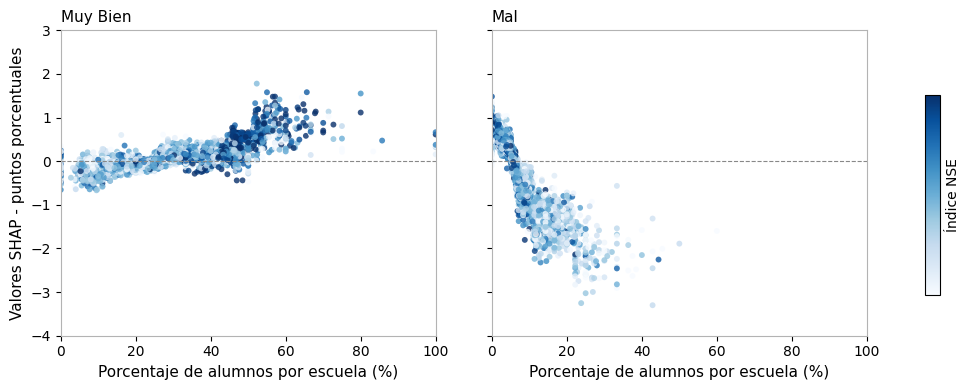

In [135]:
 #--- Figura con dos subplots, comparten eje Y ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    ('ap27c_1_pct','ap27c_1_pct_shap', 'Muy Bien'),('ap27c_4_pct','ap27c_4_pct_shap', 'Mal')]

for ax, (xcol, ycol, titulo) in zip(axes, pares):
    sns.scatterplot(
        data=df_opinion_matematica,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)
    
    ax.set_ylim(-4,3)
    ax.set_xlim(0,100)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    if ax == axes[0]:
        ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Colorbar común a la derecha ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# Formato de ticks
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)
plt.show()


##### Opinión resolución geometría

In [136]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_opinion_geometria = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [137]:
variables.loc[variables['desc_variable']=='Según tu opinión…  [¿Cómo resolvés los problemas de geometría (construir figuras, etc.)?]']['variable_a_nivel_colegio'].unique()

array(['ap27d_1_pct', 'ap27d_2_pct', 'ap27d_3_pct', 'ap27d_4_pct'],
      dtype=object)

In [138]:
vars=['NSE_puntaje','ap27d_1_pct', 'ap27d_2_pct', 'ap27d_3_pct', 'ap27d_4_pct','ap27d_1_pct_shap', 'ap27d_2_pct_shap', 'ap27d_3_pct_shap', 'ap27d_4_pct_shap']
df_opinion_geometria=df_opinion_geometria[vars]

df_opinion_geometria.loc[:, ~df_opinion_geometria.columns.isin(col_excluir)] *= 100
df_opinion_geometria.head()

NSE_puntaje  ap27d_1_pct  ap27d_2_pct  ap27d_3_pct  ap27d_4_pct  \
0    -0.304836    17.105263    38.157895    31.578947    13.157895   
1     0.693485    26.923077    38.461538    26.923077     7.692308   
2     0.767152    30.769231    34.615385    28.846154     5.769231   
3     0.782374    24.581006    44.134078    26.815642     4.469274   
4     0.857615    18.750000    68.750000    12.500000     0.000000   

   ap27d_1_pct_shap  ap27d_2_pct_shap  ap27d_3_pct_shap  ap27d_4_pct_shap  
0         -0.040235         -0.114457         -0.075101         -0.514236  
1          0.090336         -0.147200         -0.060726         -0.116424  
2         -0.115026         -0.441139         -0.087187          0.118780  
3         -0.069031         -0.175499         -0.078101          0.264674  
4         -0.110778          0.798679          0.246934          0.558419

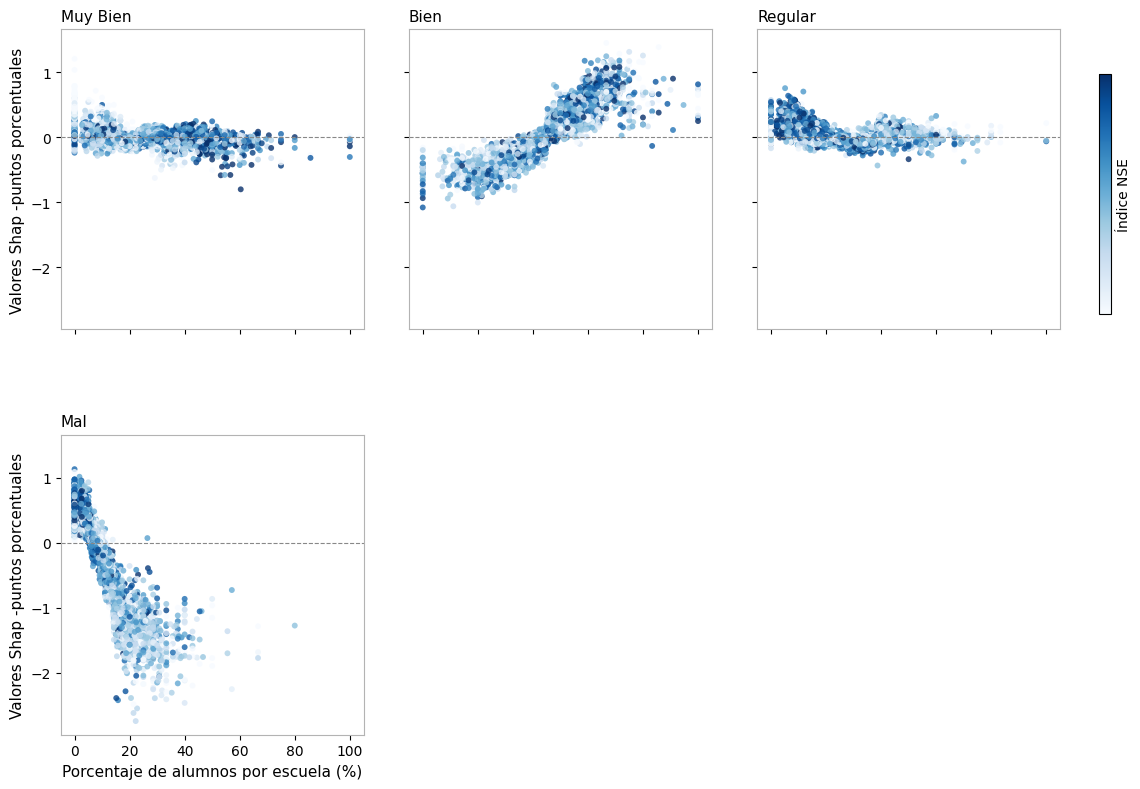

In [139]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_opinion_geometria["NSE_puntaje"].min(), df_libros["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap27d_{i}_pct", f"ap27d_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "Muy Bien",
    2: "Bien",
    3: "Regular",
    4: "Mal"}

# --- Figura y axes (2x3) ---
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_opinion_geometria,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # Etiquetas de ejes solo en bordes para no sobrecargar
    if i > 3:  # fila de abajo
        ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    else:
        ax.set_xlabel("")
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")


# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])
    
# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.92, 0.60, 0.01, 0.30])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])  # deja espacio para la barra a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()


In [140]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_opinion_geometria[ycol].mean(),
        "min_shap": df_opinion_geometria[ycol].min(),
        "max_shap": df_opinion_geometria[ycol].max(),
        "std_shap": df_opinion_geometria[ycol].std()
    }
    for xcol, ycol in pares
])

resumen

categoria  promedio_shap  min_shap  max_shap  std_shap
0   ap27d_1      -0.010690 -0.799104  1.207343  0.093615
1   ap27d_2      -0.008700 -1.077878  1.451211  0.329450
2   ap27d_3       0.016600 -0.432818  0.756418  0.109322
3   ap27d_4      -0.051407 -2.744843  1.128961  0.638025

In [141]:
vars=['NSE_puntaje','ap27d_1_pct','ap27d_1_pct_shap','ap27d_4_pct','ap27d_4_pct_shap']

df_opinion_geometria=df_opinion_geometria[vars]

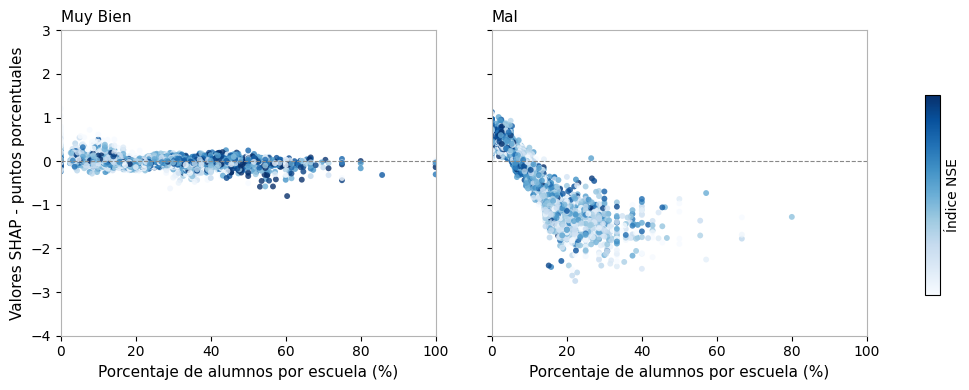

In [142]:
 #--- Figura con dos subplots, comparten eje Y ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    ('ap27d_1_pct','ap27d_1_pct_shap', 'Muy Bien'),('ap27d_4_pct','ap27d_4_pct_shap', 'Mal')]

for ax, (xcol, ycol, titulo) in zip(axes, pares):
    sns.scatterplot(
        data=df_opinion_geometria,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)
        
    ax.set_ylim(-4,3)
    ax.set_xlim(0,100)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    if ax == axes[0]:
        ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Colorbar común a la derecha ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# Formato de ticks
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)
plt.show()


##### Asistencia Jardín Infantes

In [143]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_jardin_infantes = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [144]:
variables.loc[variables['desc_variable']=='¿Fuiste al jardín de infantes?']['variable_a_nivel_colegio'].unique()

array(['ap21_1_pct', 'ap21_2_pct', 'ap21_3_pct', 'ap21_4_pct'],
      dtype=object)

In [145]:
vars=['NSE_puntaje','ap21_1_pct', 'ap21_2_pct', 'ap21_3_pct', 'ap21_4_pct', 'ap21_1_pct_shap', 'ap21_2_pct_shap', 'ap21_3_pct_shap', 'ap21_4_pct_shap']
df_jardin_infantes=df_jardin_infantes[vars]

df_jardin_infantes.loc[:, ~df_jardin_infantes.columns.isin(col_excluir)] *= 100
df_jardin_infantes.head()

NSE_puntaje  ap21_1_pct  ap21_2_pct  ap21_3_pct  ap21_4_pct  \
0    -0.304836   45.783133   19.277108   28.915663    6.024096   
1     0.693485   87.719298    7.017544    5.263158    0.000000   
2     0.767152   89.473684    3.508772    7.017544    0.000000   
3     0.782374   84.536082   13.402062    1.546392    0.515464   
4     0.857615   24.000000   76.000000    0.000000    0.000000   

   ap21_1_pct_shap  ap21_2_pct_shap  ap21_3_pct_shap  ap21_4_pct_shap  
0        -0.336310        -0.026986        -0.698560        -0.227668  
1         0.584524         0.047171         0.388562         0.060954  
2         0.372310         0.294892         0.194030         0.077912  
3         0.355447        -0.041521         0.836707         0.050894  
4        -0.682111         0.230953         0.877871         0.184624

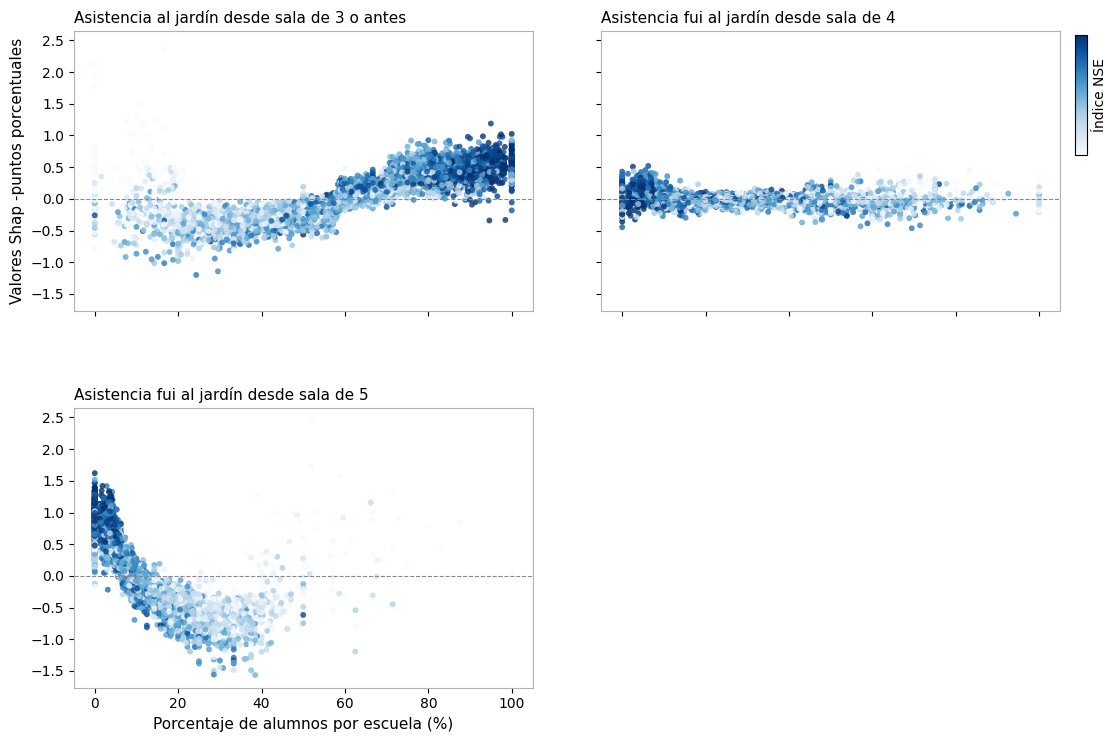

In [146]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_jardin_infantes["NSE_puntaje"].min(), df_jardin_infantes["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap21_{i}_pct", f"ap21_{i}_pct_shap") for i in range(1,4)]
titulos = {
    1: "Asistencia al jardín desde sala de 3 o antes",
    2: "Asistencia fui al jardín desde sala de 4",
    3: "Asistencia fui al jardín desde sala de 5",
    #4: "No fui al jardín"
}

# Figura y ejes
cols = 2
rows =2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_jardin_infantes,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.8, 0.01,0.15])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

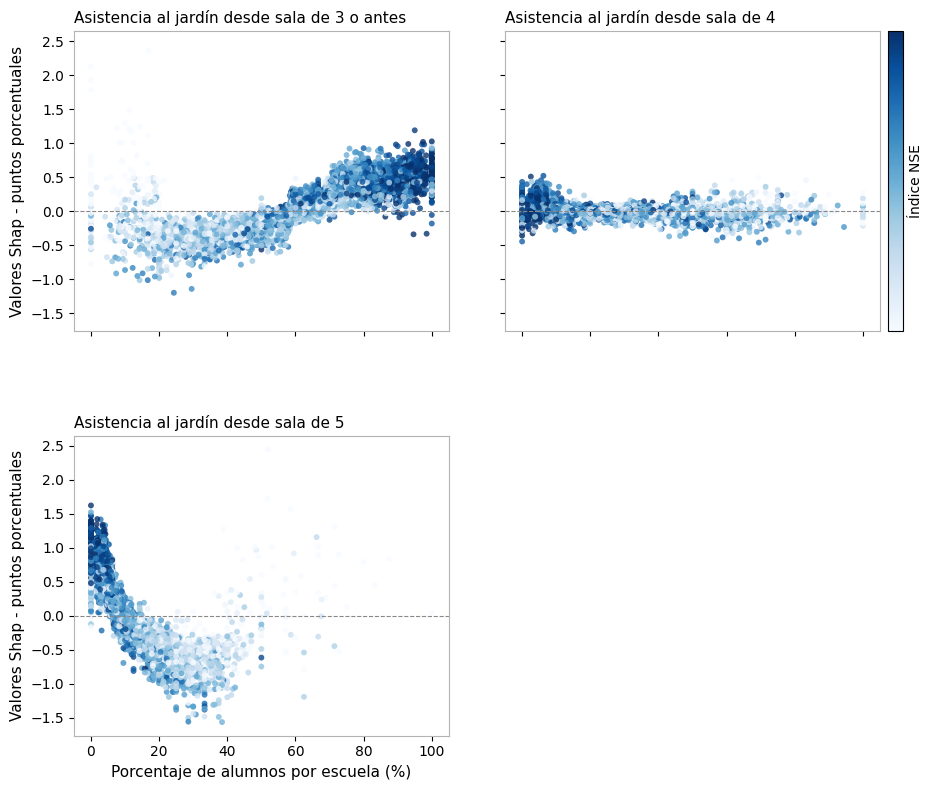

In [147]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
# norm = plt.Normalize(df_jardin_infantes["NSE_puntaje"].min(), df_jardin_infantes["NSE_puntaje"].max())

pares = [(f"ap21_{i}_pct", f"ap21_{i}_pct_shap") for i in range(1, 4)]
titulos = {
    1: "Asistencia al jardín desde sala de 3 o antes",
    2: "Asistencia al jardín desde sala de 4",
    3: "Asistencia al jardín desde sala de 5",
}

rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharex=True, sharey=True)
axes = np.array(axes).ravel()

# --- Scatter panels ---
for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_jardin_infantes,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )

    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE)
        sp.set_linewidth(0.8)

    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    # Y label solo primera columna
    if ax in (axes[0], axes[2]):
        ax.set_ylabel("Valores Shap - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Eliminar subplot vacío (4to) ---
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])

# --- Formato ticks X (solo ejes de datos) ---
for ax in [axes[0], axes[1], axes[2]]:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# --- Layout primero, para que posiciones sean finales ---
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15, hspace=0.35)

# =========================
# Colorbar pegada al eje (fila 1, col 2) -> axes[1]
# =========================
ref_ax = axes[1]  # arriba derecha
pos = ref_ax.get_position()  # bbox en coords de figura

bar_w = 0.015          # MISMO ancho que antes
gap = 0.008            # separación pequeña respecto al eje
bar_h = pos.height     # MISMA altura que ese panel
bar_y = pos.y0         # alineada a ese panel
bar_x = pos.x1 + gap   # pegada a la derecha del panel

cax = fig.add_axes([bar_x, bar_y, bar_w, bar_h])

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)


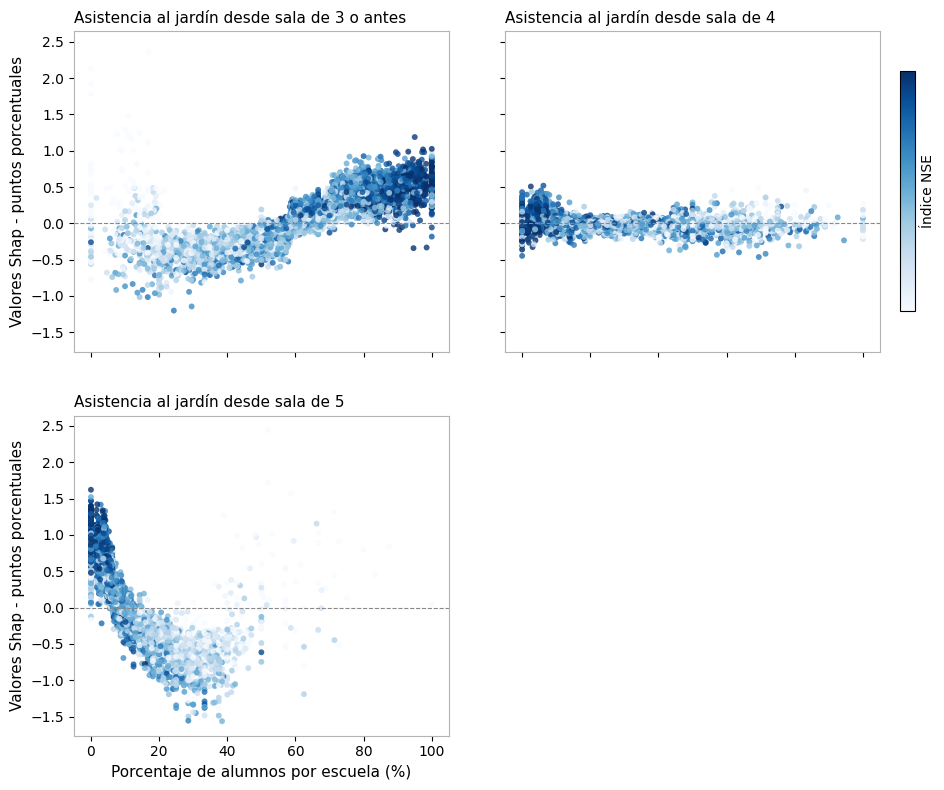

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# =========================
# Estilo
# =========================
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
# norm = plt.Normalize(df_jardin_infantes["NSE_puntaje"].min(),
#                      df_jardin_infantes["NSE_puntaje"].max())

# =========================
# Variables
# =========================
pares = [(f"ap21_{i}_pct", f"ap21_{i}_pct_shap") for i in range(1, 4)]
titulos = {
    1: "Asistencia al jardín desde sala de 3 o antes",
    2: "Asistencia al jardín desde sala de 4",
    3: "Asistencia al jardín desde sala de 5",
}

# =========================
# Figura: misma geometría que educación madre
# (2 filas -> el doble de alto)
# =========================
rows, cols = 2, 2
fig, axes = plt.subplots(
    rows, cols,
    figsize=(10, 8),        # <- CLAVE
    sharex=True, sharey=True
)
axes = np.array(axes).ravel()

# =========================
# Scatter plots
# =========================
for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_jardin_infantes,
        x=xcol, y=ycol,
        hue="NSE_puntaje",
        palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8,
        legend=False, ax=ax
    )

    # Línea en cero
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

    # Spines
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE)
        sp.set_linewidth(0.8)

    # Títulos y labels
    ax.set_title(titulos[i], loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    if ax in (axes[0], axes[2]):  # primera columna
        ax.set_ylabel("Valores Shap - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# =========================
# Eliminar panel vacío (4to)
# =========================
fig.delaxes(axes[3])

# =========================
# Formato ticks X
# =========================
for ax in [axes[0], axes[1], axes[2]]:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# =========================
# Layout (ANTES de la barra)
# =========================
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15, hspace=0.2)

# =========================
# Colorbar NSE — CORTA y PEGADA
# (igual que tus figuras de 2 paneles)
# =========================
ref_ax = axes[1]                 # panel superior derecho
pos = ref_ax.get_position()

bar_w = 0.015                    # mismo ancho de siempre
gap = 0.02                      # distancia al panel
frac_h = 0.75                    # altura relativa (CLAVE)

bar_h = pos.height * frac_h
bar_y = pos.y0 + (pos.height - bar_h) / 2
bar_x = pos.x1 + gap

cax = fig.add_axes([bar_x, bar_y, bar_w, bar_h])

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)


In [149]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_jardin_infantes[ycol].mean(),
        "min_shap": df_jardin_infantes[ycol].min(),
        "max_shap": df_jardin_infantes[ycol].max(),
        "std_shap": df_jardin_infantes[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0    ap21_1          0.029    -1.201     2.357     0.339  3.558
1    ap21_2         -0.007    -0.463     0.519     0.081  0.982
2    ap21_3          0.048    -1.564     2.442     0.530  4.006

In [150]:
#¿Cómo afecta según el NSE?

df=df_jardin_infantes.copy()
p33 = np.percentile(df["NSE_puntaje"], 33) 
p90 = np.percentile(df["NSE_puntaje"], 90)

# Función para clasificar según percentiles
def clasificar_nse(puntaje):
    if puntaje <= p33:
        return "bajo"
    elif puntaje >= p90:
        return "alto"
    else:
        return "medio"

# Aplicar al DataFrame
df["NSE_nivel_grupo"] = df["NSE_puntaje"].apply(clasificar_nse)

In [151]:
df.groupby('NSE_nivel_grupo')['ap21_1_pct'].mean().reset_index()

NSE_nivel_grupo  ap21_1_pct
0            alto   85.740455
1            bajo   47.101396
2           medio   62.370455

In [152]:
df.groupby('NSE_nivel_grupo')['ap21_3_pct'].mean().reset_index()

NSE_nivel_grupo  ap21_3_pct
0            alto    2.908481
1            bajo   17.538637
2           medio   10.042580

In [153]:
df.groupby('NSE_nivel_grupo')['ap21_2_pct'].mean().reset_index()

NSE_nivel_grupo  ap21_2_pct
0            alto   10.948063
1            bajo   32.971059
2           medio   26.605676

##### Repitencia

In [154]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_repitencia = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [155]:
variables.loc[variables['desc_variable']=='¿Repetiste de grado alguna vez?']['variable_a_nivel_colegio'].unique()

array(['ap22_1_pct', 'ap22_2_pct', 'ap22_3_pct', 'ap22_4_pct'],
      dtype=object)

In [156]:
vars=['NSE_puntaje','ap22_1_pct', 'ap22_2_pct', 'ap22_3_pct', 'ap22_4_pct','ap22_1_pct_shap', 'ap22_2_pct_shap', 'ap22_3_pct_shap', 'ap22_4_pct_shap']
df_repitencia=df_repitencia[vars]

df_repitencia.loc[:, ~df_repitencia.columns.isin(col_excluir)] *= 100
df_repitencia.head()

NSE_puntaje  ap22_1_pct  ap22_2_pct  ap22_3_pct  ap22_4_pct  \
0    -0.304836   79.797980    5.050505   15.151515         0.0   
1     0.693485   96.666667    3.333333    0.000000         0.0   
2     0.767152  100.000000    0.000000    0.000000         0.0   
3     0.782374   99.504950    0.495050    0.000000         0.0   
4     0.857615  100.000000    0.000000    0.000000         0.0   

   ap22_1_pct_shap  ap22_2_pct_shap  ap22_3_pct_shap  ap22_4_pct_shap  
0        -1.612475         0.048228        -0.455412         0.060489  
1         0.586578        -0.213846         0.356135         0.124382  
2         1.805402        -0.033079         0.575648         0.166127  
3         1.661242        -0.171221         0.240644         0.079906  
4         2.389839        -0.173718         0.355806         0.168633

In [ ]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_repitencia["NSE_puntaje"].min(), df_repitencia["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap22_{i}_pct", f"ap22_{i}_pct_shap") for i in range(1,5)]
titulos = {
    1: "No repitió nunca",
    2: "Repitió una vez",
    3: "Repitió dos veces",
    4: "Repitió tres veces o más"
}

# Figura y ejes
cols = 2
rows =2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_repitencia,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.8, 0.01,0.15])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [158]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_repitencia[ycol].mean(),
        "min_shap": df_repitencia[ycol].min(),
        "max_shap": df_repitencia[ycol].max(),
        "std_shap": df_repitencia[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0    ap22_1          0.031    -3.440     4.368     1.523  7.808
1    ap22_2         -0.007    -0.592     0.607     0.134  1.199
2    ap22_3          0.016    -1.878     0.624     0.364  2.502
3    ap22_4         -0.040    -2.403     0.351     0.360  2.755

In [159]:
#¿Cómo afecta según el NSE?

df=df_repitencia.copy()
p33 = np.percentile(df["NSE_puntaje"], 33) 
p90 = np.percentile(df["NSE_puntaje"], 90)

# Función para clasificar según percentiles
def clasificar_nse(puntaje):
    if puntaje <= p33:
        return "bajo"
    elif puntaje >= p90:
        return "alto"
    else:
        return "medio"

# Aplicar al DataFrame
df["NSE_nivel_grupo"] = df["NSE_puntaje"].apply(clasificar_nse)

In [160]:
df.groupby('NSE_nivel_grupo')['ap22_1_pct'].mean().reset_index()

NSE_nivel_grupo  ap22_1_pct
0            alto   96.939540
1            bajo   78.995874
2           medio   90.523969

In [161]:
df.groupby('NSE_nivel_grupo')['ap22_2_pct'].mean().reset_index()

NSE_nivel_grupo  ap22_2_pct
0            alto    2.061140
1            bajo   13.636694
2           medio    6.651509

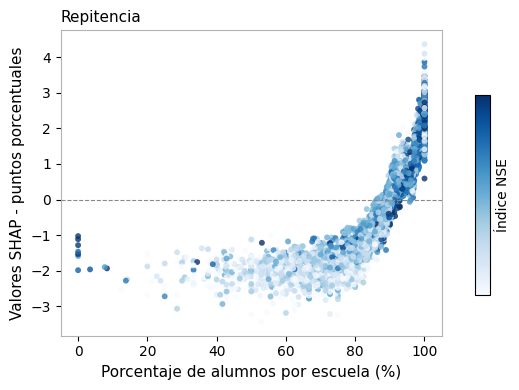

In [162]:

cmap = sns.color_palette("Blues", as_cmap=True)

# === Figura con geometría de 2 paneles ===
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax = axes[0]


fig.delaxes(axes[1])

sns.scatterplot(
    data=df,
    x="ap22_1_pct", y="ap22_1_pct_shap",
    hue="NSE_puntaje",
    palette=cmap, hue_norm=norm,
    s=18, linewidth=0, alpha=0.8,
    ax=ax, legend=False
)

# Línea guía en 0
ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Estilo
ax.set_title("Repitencia", loc="left", fontsize=11)
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

for sp in ax.spines.values():
    sp.set_color(COLOR_SPINE)
    sp.set_linewidth(0.8)

# === Colorbar pegada EXACTAMENTE igual que en panel doble ===
cax = fig.add_axes([0.48, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# === Layout idéntico al panel doble ===
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)

In [163]:
df_repitencia_stats=df_repitencia[['ap22_1_pct','ap22_1_pct_shap']].copy()
x_col = "ap22_1_pct"
y_col = "ap22_1_pct_shap"

# Bins: [0,0.4], (0.4,0.8], (0.8,1.0]
labels = ["0––80%", "80–100%"]
df_repitencia_stats["tramo"] = pd.cut(
    df_repitencia_stats[x_col],
    bins=[0.0, 80, 100],
    labels=labels,
    include_lowest=True,   
    right=True)

# Función de estadísticos por tramo
def _corr_stats(g):
    n = len(g)
    out = {
        "n": n,
        "x_mean": g[x_col].mean(),
        "y_mean": g[y_col].mean(),
        "pearson_r": np.nan,
        "spearman_rho": np.nan,
    }
    if n >= 2:
        out["pearson_r"]   = g[x_col].corr(g[y_col], method="pearson")
        out["spearman_rho"] = g[x_col].corr(g[y_col], method="spearman")
    return pd.Series(out)

corr_por_tramo = (
    df_repitencia_stats.groupby("tramo", observed=True)
       .apply(_corr_stats)
       .reset_index()
)

# Orden agradable
corr_por_tramo = corr_por_tramo[
    ["tramo", "n", "x_mean", "y_mean", "pearson_r", "spearman_rho"]
].round(3)

corr_por_tramo



tramo       n  x_mean  y_mean  pearson_r  spearman_rho
0   0––80%  2135.0  69.018  -1.891      0.272         0.369
1  80–100%  6950.0  92.997   0.621      0.954         0.961

##### Faltas

In [164]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_faltas = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [165]:
variables.loc[variables['desc_variable']=='En lo que va de este año, ¿cuántas veces faltaste?']['variable_a_nivel_colegio'].unique()

array(['ap23_1_pct', 'ap23_2_pct', 'ap23_3_pct', 'ap23_4_pct',
       'ap23_5_pct', 'ap23_6_pct'], dtype=object)

In [166]:
vars=['NSE_puntaje','ap23_1_pct', 'ap23_2_pct', 'ap23_3_pct', 'ap23_4_pct',
       'ap23_5_pct', 'ap23_6_pct', 
     'ap23_1_pct_shap', 'ap23_2_pct_shap', 'ap23_3_pct_shap', 'ap23_4_pct_shap',
       'ap23_5_pct_shap', 'ap23_6_pct_shap']
df_faltas=df_faltas[vars]

df_faltas.loc[:, ~df_faltas.columns.isin(col_excluir)] *= 100
df_faltas.head()

NSE_puntaje  ap23_1_pct  ap23_2_pct  ap23_3_pct  ap23_4_pct  ap23_5_pct  \
0    -0.304836   13.333333   34.444444   17.777778   16.666667    2.222222   
1     0.693485    5.263158   33.333333   15.789474   22.807018   10.526316   
2     0.767152   15.517241   51.724138   18.965517    6.896552    3.448276   
3     0.782374    2.162162   28.648649   25.945946   21.081081   11.891892   
4     0.857615    9.090909   63.636364   18.181818    0.000000    9.090909   

   ap23_6_pct  ap23_1_pct_shap  ap23_2_pct_shap  ap23_3_pct_shap  \
0   15.555556         0.011903        -0.033761         0.002701   
1   12.280702         0.525422        -0.065481        -0.031093   
2    3.448276        -0.373746         0.005238        -0.003761   
3   10.270270         0.491105        -0.059907         0.011975   
4    0.000000         0.232568         0.068518         0.013873   

   ap23_4_pct_shap  ap23_5_pct_shap  ap23_6_pct_shap  
0        -0.079232        -0.002288        -0.098741  
1         0.208262         0.013701        -0.116867  
2        -0.221960         0.049696        -0.002743  
3         0.111424        -0.024267        -0.044117  
4        -0.479589         0.052299         0.205013

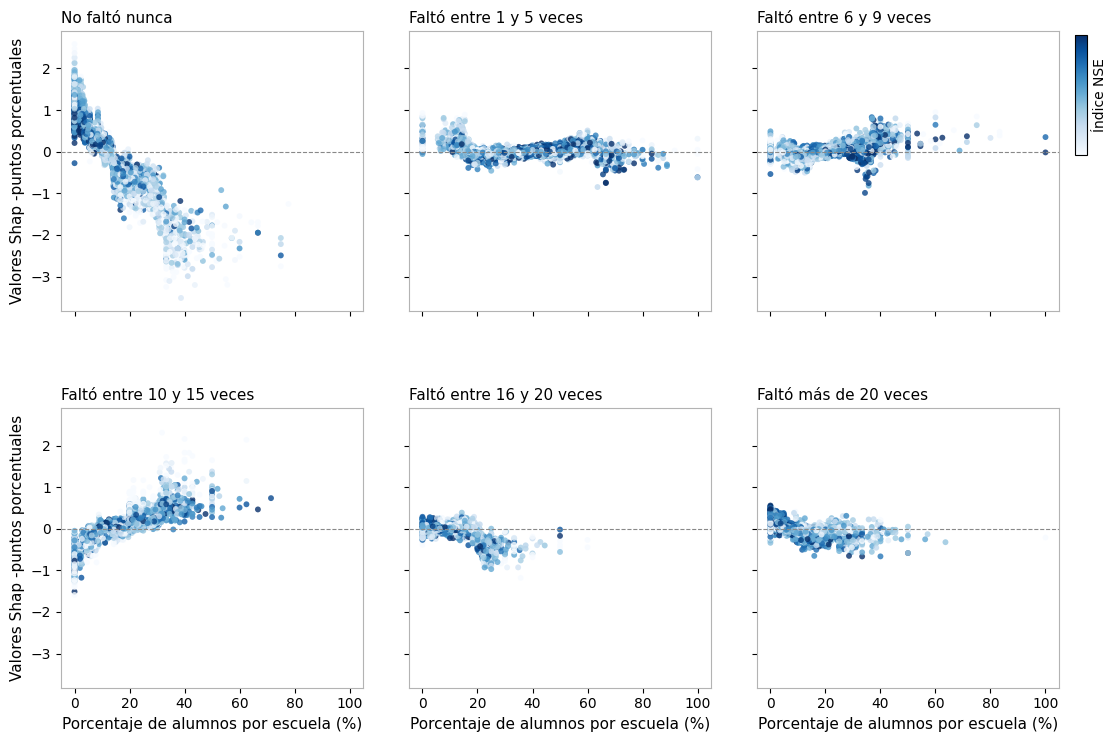

In [167]:
COLOR_SPINE = "#b3b3b3"
cmap = sns.color_palette("Blues", as_cmap=True)
#norm = plt.Normalize(df_faltas["NSE_puntaje"].min(), df_faltas["NSE_puntaje"].max())

# Pares (x,y) y etiquetas de título (ajustalas si tus tramos son otros)
pares = [(f"ap23_{i}_pct", f"ap23_{i}_pct_shap") for i in range(1,7)]
titulos = {
    1: "No faltó nunca",
    2: "Faltó entre 1 y 5 veces",
    3: "Faltó entre 6 y 9 veces",
    4: "Faltó entre 10 y 15 veces",
    5: "Faltó entre 16 y 20 veces",
    6: "Faltó más de 20 veces"
}

# Figura y ejes
cols = 3
rows =2
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True, sharey=True)
axes = np.array(axes).ravel()

for i, (ax, (xcol, ycol)) in enumerate(zip(axes, pares), start=1):
    sns.scatterplot(
        data=df_faltas,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    # Línea guía y spines
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    # Título por panel
    ax.set_title(titulos.get(i, f"Tramo {i}"), loc="left", fontsize=11)

    # ✅ Etiqueta X en TODOS los subplots
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)

    
    if i in (1,4):  # primera columna
        ax.set_ylabel("Valores Shap -puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# === Colorbar personalizada (arriba a la derecha) ===
# Coordenadas: [x0, y0, ancho, alto] (valores relativos al lienzo)
cax = fig.add_axes([0.90, 0.8, 0.01,0.15])  # ajustá valores para moverla
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# Eliminar subplots vacíos (última fila col 2 y 3)
for j in range(len(pares), len(axes)):
    fig.delaxes(axes[j])


# Formato de ticks del eje X
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Márgenes: dejamos más espacio para que se vean bien todas las etiquetas X
plt.tight_layout(rect=[0, 0.06, 0.9, 1])   # ↑ más espacio abajo y a la derecha
plt.subplots_adjust(hspace=0.35, wspace=0.15)
plt.show()

In [168]:
resumen = pd.DataFrame([
    {
        "categoria": xcol.replace("_pct", ""),  # nombre base de la variable
        "promedio_shap": df_faltas[ycol].mean(),
        "min_shap": df_faltas[ycol].min(),
        "max_shap": df_faltas[ycol].max(),
        "std_shap": df_faltas[ycol].std()
    }
    for xcol, ycol in pares
])

resumen['rango']=resumen['max_shap']-resumen['min_shap']
resumen.round(3)

categoria  promedio_shap  min_shap  max_shap  std_shap  rango
0    ap23_1          0.075    -3.515     2.588     0.759  6.103
1    ap23_2         -0.002    -0.849     0.930     0.097  1.779
2    ap23_3         -0.000    -0.990     0.948     0.119  1.938
3    ap23_4          0.002    -1.591     2.311     0.268  3.901
4    ap23_5          0.010    -1.181     0.387     0.101  1.568
5    ap23_6          0.002    -0.665     0.559     0.130  1.224

In [169]:
#¿Cómo afecta según el NSE?

df=df_faltas.copy()
p33 = np.percentile(df["NSE_puntaje"], 33) 
p90 = np.percentile(df["NSE_puntaje"], 90)

# Función para clasificar según percentiles
def clasificar_nse(puntaje):
    if puntaje <= p33:
        return "bajo"
    elif puntaje >= p90:
        return "alto"
    else:
        return "medio"

# Aplicar al DataFrame
df["NSE_nivel_grupo"] = df["NSE_puntaje"].apply(clasificar_nse)

In [170]:
# Calculamos los promedios (%)
faltas_table = pd.DataFrame({
    'No falté nunca': df.groupby('NSE_nivel_grupo')['ap23_1_pct'].mean(),
    'Entre 1 y 5 veces': df.groupby('NSE_nivel_grupo')['ap23_2_pct'].mean(),
    'Entre 6 y 9 veces': df.groupby('NSE_nivel_grupo')['ap23_3_pct'].mean(),
    'Entre 10 y 15 veces': df.groupby('NSE_nivel_grupo')['ap23_4_pct'].mean(),
    'Entre 16 y 20 veces': df.groupby('NSE_nivel_grupo')['ap23_5_pct'].mean(),
    'Más de 20 veces': df.groupby('NSE_nivel_grupo')['ap23_6_pct'].mean()
}).round(2)


print('% de alumnos por colegio segun cantidad de faltas y NSE')
faltas_table


% de alumnos por colegio segun cantidad de faltas y NSE


No falté nunca  Entre 1 y 5 veces  Entre 6 y 9 veces  \
NSE_nivel_grupo                                                         
alto                       6.92              42.61              24.04   
bajo                      15.31              37.86              17.34   
medio                      9.81              37.82              20.37   

                 Entre 10 y 15 veces  Entre 16 y 20 veces  Más de 20 veces  
NSE_nivel_grupo                                                             
alto                           15.16                 5.97             5.29  
bajo                           13.09                 7.08             9.32  
medio                          15.29                 7.68             9.05

Graficamos las opciones con más dispersión y menor/mayor shap: no faltó nunca y entre 10 y 15 faltas

In [171]:
vars=['NSE_puntaje','ap23_1_pct','ap23_1_pct_shap','ap23_4_pct','ap23_4_pct_shap']

df_faltas=df_faltas[vars]

col_excluir = ['NSE_puntaje']

df_faltas.describe()

NSE_puntaje   ap23_1_pct  ap23_1_pct_shap   ap23_4_pct  ap23_4_pct_shap
count  9085.000000  9085.000000      9085.000000  9085.000000      9085.000000
mean      0.160804    11.335642         0.075303    14.550514         0.001656
std       0.496514     9.023134         0.758869     8.256966         0.267524
min      -2.626484     0.000000        -3.515073     0.000000        -1.590578
25%      -0.166123     5.128205        -0.454316     9.090909        -0.086126
50%       0.132295     9.615385         0.203123    14.000000         0.010570
75%       0.512578    15.625000         0.520131    19.354839         0.109668
max       1.422577    77.777778         2.587570    71.428571         2.310886

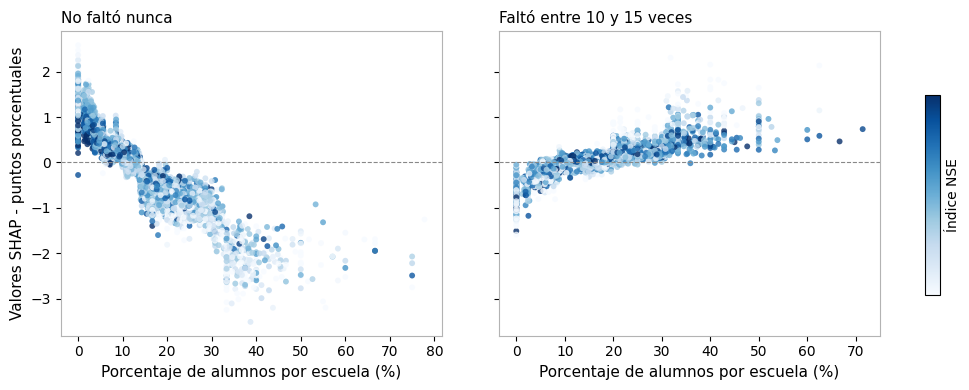

In [172]:
 #--- Figura con dos subplots, comparten eje Y ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes = axes.ravel()

pares = [
    ("ap23_1_pct","ap23_1_pct_shap", "No faltó nunca"),
    ("ap23_4_pct", "ap23_4_pct_shap", "Faltó entre 10 y 15 veces")
]

for ax, (xcol, ycol, titulo) in zip(axes, pares):
    sns.scatterplot(
        data=df_faltas,
        x=xcol, y=ycol,
        hue="NSE_puntaje", palette=cmap, hue_norm=norm,
        s=18, linewidth=0, alpha=0.8, legend=False, ax=ax
    )
    ax.axhline(0, color="#888", linestyle="--", linewidth=0.8)
    for sp in ax.spines.values():
        sp.set_color(COLOR_SPINE); sp.set_linewidth(0.8)

    ax.set_title(titulo, loc="left", fontsize=11)
    ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
    if ax == axes[0]:
        ax.set_ylabel("Valores SHAP - puntos porcentuales", fontsize=11)
    else:
        ax.set_ylabel("")

# --- Colorbar común a la derecha ---
cax = fig.add_axes([0.93, 0.25, 0.015, 0.5])
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_ticks([])
cbar.set_label("Índice NSE", fontsize=10)

# Formato de ticks
for ax in axes:
    ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0.15)
plt.show()

#### 3.2.2.4 Factores institucionales

Problemas de convivencia, Horas de trabajo docente, Clima escolar, Antigüedad en el cargo, Acceso al cargo

##### Problemas convivencia

In [173]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_problemas_convivencia = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [174]:
vars=['ID1','NSE_puntaje','dp48e_1.0','dp48e_1.0_shap','dp48e_2.0','dp48e_2.0_shap','dp48e_3.0','dp48e_3.0_shap']
df_problemas_convivencia=df_problemas_convivencia[vars]

col_excluir = ['NSE_puntaje', 'dp48e_1.0','dp48e_2.0','dp48e_3.0']
df_problemas_convivencia.loc[:, ~df_problemas_convivencia.columns.isin(col_excluir)] *= 100
df_problemas_convivencia.head()


ID1  NSE_puntaje  dp48e_1.0  dp48e_1.0_shap  dp48e_2.0  \
0  42345002740054200    -0.304836          0        0.171427          0   
1  11396001332101100     0.693485          1       -0.300198          0   
2  33920098112339200     0.767152          0        0.113863          0   
3  37800018183037800     0.782374          1       -0.448950          0   
4  88320040320008800     0.857615          0        0.327731          0   

   dp48e_2.0_shap  dp48e_3.0  dp48e_3.0_shap  
0       -0.009235          0       -0.002787  
1       -0.012876          0       -0.002787  
2       -0.031555          1        0.010264  
3       -0.013611          0       -0.001882  
4       -0.010467          1        0.010264

In [175]:
#Chequeamos que los valores de las variables sean o 0 o 1
print(df_problemas_convivencia['dp48e_1.0'].unique())
print(df_problemas_convivencia['dp48e_2.0'].unique())
print(df_problemas_convivencia['dp48e_3.0'].unique())


[0 1]
[0 1]
[0 1]


In [176]:
#Acá estamos viendo cuantos no contestar o es NA. De esta manera excluimos al colegio del gráfico
df_problemas_convivencia['sum_check']=df_problemas_convivencia['dp48e_1.0']+df_problemas_convivencia['dp48e_2.0']+df_problemas_convivencia['dp48e_3.0']
df_problemas_convivencia.loc[df_problemas_convivencia['sum_check']==0].shape

(741, 9)

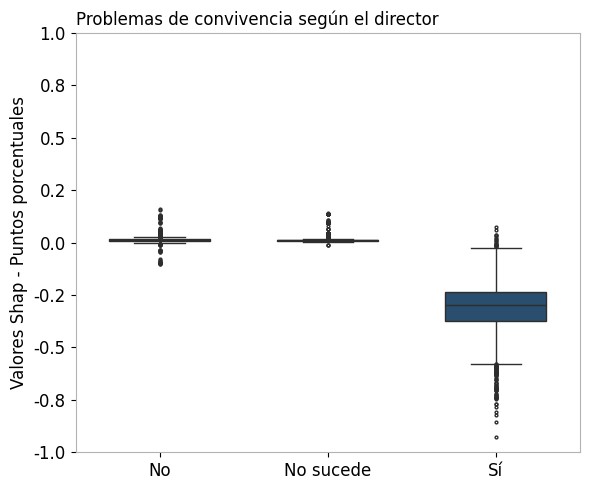

In [178]:
from matplotlib.ticker import FormatStrFormatter
df_plot = pd.concat([
    df_problemas_convivencia.loc[df_problemas_convivencia['dp48e_1.0'] == 1, ['dp48e_1.0_shap']].assign(grupo='Sí', shap_value=lambda d: d['dp48e_1.0_shap']),
    df_problemas_convivencia.loc[df_problemas_convivencia['dp48e_2.0'] == 1, ['dp48e_2.0_shap']].assign(grupo='No', shap_value=lambda d: d['dp48e_2.0_shap']),
    df_problemas_convivencia.loc[df_problemas_convivencia['dp48e_3.0'] == 1, ['dp48e_3.0_shap']].assign(grupo='No sucede', shap_value=lambda d: d['dp48e_3.0_shap'])
])

# Orden según mediana
order_resp = (
    df_plot.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)

# --- Boxplot ---
fig, ax = plt.subplots(figsize=(6, 5))



sns.boxplot(
    data=df_plot,
    x="grupo", y="shap_value",
    order=order_resp,
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax,
    orient='v'
)

ax.set_title("Problemas de convivencia según el director", loc='left')
ax.set_xlabel("")
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
ax.set_ylim(-1,1)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f')) 
ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
for s in ax.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax.grid(False)

plt.tight_layout()
plt.show()


##### Horas que trabaja el docente en la escuela

Como el colegio puede tener casos en los que no contestó nigún docente? las filas suman 0%, eliminamos estas observaciones para promediar. Además, promediamos el shap solo en las categorías activas para el colegio. Es decir, si un colegio tiene todos los docentes trabajando menos de 15 horas, en la categoria de mas de 30 horas, para hacer el boxplot, no sumamos a ese colegio

In [179]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_horas_docente_escuela = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [180]:
variables.loc[variables['variable']=='mp07a']['variable_a_nivel_colegio'].unique()

array(['mp07a_1.0', 'mp07a_2.0', 'mp07a_3.0', 'mp07a_4.0', 'mp07a_5.0',
       'mp07a_6.0'], dtype=object)

In [181]:
variables.loc[variables['variable']=='mp07a']['desc_variable'].unique()

array(['¿Cuántas horas (reloj) trabaja habitualmente por semana? [En esta escuela]'],
      dtype=object)

In [182]:
vars=['ID1','NSE_puntaje','mp07a_1.0', 'mp07a_2.0', 'mp07a_3.0', 'mp07a_4.0', 'mp07a_5.0',
       'mp07a_6.0', 'mp07a_1.0_shap', 'mp07a_2.0_shap', 'mp07a_3.0_shap', 'mp07a_4.0_shap', 'mp07a_5.0_shap',
       'mp07a_6.0_shap']
df_horas_docente_escuela=df_horas_docente_escuela[vars]

df_horas_docente_escuela.loc[:, ~df_horas_docente_escuela.columns.isin(col_excluir)] *= 100
print(df_horas_docente_escuela.shape)
df_horas_docente_escuela.head()

(9085, 14)


ID1  NSE_puntaje  mp07a_1.0  mp07a_2.0  mp07a_3.0  mp07a_4.0  \
0  42345002740054200    -0.304836        0.0       25.0        0.0        0.0   
1  11396001332101100     0.693485        0.0        0.0        0.0        0.0   
2  33920098112339200     0.767152        0.0      100.0        0.0        0.0   
3  37800018183037800     0.782374        0.0        0.0      100.0        0.0   
4  88320040320008800     0.857615        0.0      100.0        0.0        0.0   

   mp07a_5.0  mp07a_6.0  mp07a_1.0_shap  mp07a_2.0_shap  mp07a_3.0_shap  \
0        0.0       50.0        0.008817        0.025006       -0.007484   
1      100.0        0.0        0.006223        0.053218       -0.024948   
2        0.0        0.0        0.003036       -0.027075       -0.017223   
3        0.0        0.0       -0.004399        0.036941        0.011950   
4        0.0        0.0        0.004159       -0.005982       -0.027765   

   mp07a_4.0_shap  mp07a_5.0_shap  mp07a_6.0_shap  
0       -0.000697       -0.023273       -0.507833  
1        0.000824        0.108717        0.003135  
2        0.000455       -0.071789        0.000835  
3       -0.003021       -0.045448        0.001776  
4        0.033309        0.009852        0.004477

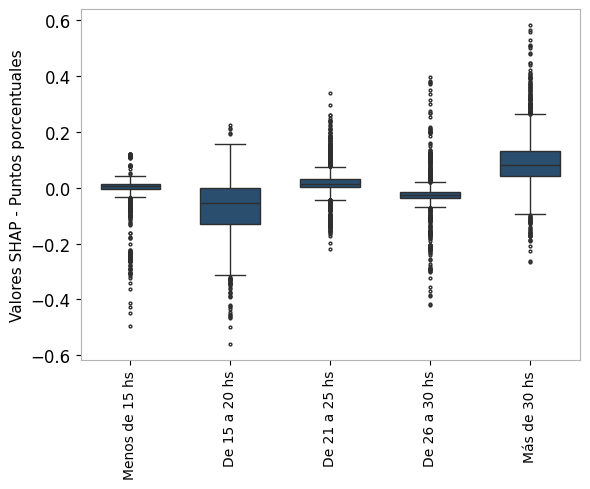

In [185]:
# --- columnas de respuesta y de SHAP ---
resp_cols = [f"mp07a_{i}.0" for i in range(1, 6)]
shap_cols = [f"mp07a_{i}.0_shap" for i in range(1, 6)]

# Filtrar filas sin ninguna respuesta (todas 0 o NaN)
df_ = df_horas_docente_escuela.copy()
valid_mask = df_[resp_cols].fillna(0).sum(axis=1) > 0
df_ = df_.loc[valid_mask].reset_index(drop=True)

# Construir df_plot: SHAP solo donde la categoría tiene proporción > 0
parts = []
labels = {1:"Menos de 15 hs", 2:"De 15 a 20 hs", 3:"De 21 a 25 hs", 4:"De 26 a 30 hs", 5:"Más de 30 hs"}


for i in range(1,6):
    rcol = f"mp07a_{i}.0"
    scol = f"mp07a_{i}.0_shap"
    tmp = df_.loc[df_[rcol].fillna(0) > 0, [scol]].copy()
    tmp["grupo"] = labels[i]       
    tmp["shap_value"] = tmp[scol]   
    parts.append(tmp[["grupo", "shap_value"]])

df_plot = pd.concat(parts, axis=0, ignore_index=True)

# Orden según mediana
#order_resp = (
#    df_plot.groupby("grupo")["shap_value"]
#      .median()
#      .sort_values(ascending=False)
#      .index
#)

# --- Boxplot ---
fig, ax = plt.subplots(figsize=(6, 5))



sns.boxplot(
    data=df_plot,
    x="grupo", y="shap_value",
#    order=order_resp,
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax, orient='v'
)

ax.set_xlabel("")
ax.set_ylabel("Valores SHAP - Puntos porcentuales", fontsize=11)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=12)
for s in ax.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax.grid(False)

plt.tight_layout()
plt.show()

In [186]:
df_plot['shap_abs']=df_plot['shap_value'].abs()
df_plot.groupby('grupo')['shap_abs'].describe().reset_index().round(3)

grupo   count   mean    std  min    25%    50%    75%    max
0   De 15 a 20 hs  3470.0  0.081  0.078  0.0  0.014  0.060  0.129  0.561
1   De 21 a 25 hs  4328.0  0.028  0.033  0.0  0.008  0.016  0.036  0.340
2   De 26 a 30 hs  1092.0  0.060  0.067  0.0  0.023  0.032  0.067  0.420
3  Menos de 15 hs  1419.0  0.037  0.064  0.0  0.005  0.013  0.038  0.496
4    Más de 30 hs  2941.0  0.099  0.076  0.0  0.045  0.083  0.132  0.582

##### Clima escolar

In [187]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_clima_escolar = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [188]:
vars=['ID1','NSE_puntaje', 'clima_escolar','clima_escolar_1_shap','clima_escolar_2_shap','clima_escolar_3_shap']
df_clima_escolar=df_clima_escolar[vars]

col_excluir = ['ID1','NSE_puntaje', 'clima_escolar']
df_clima_escolar.loc[:, ~df_clima_escolar.columns.isin(col_excluir)] *= 100
df_clima_escolar.head()


ID1  NSE_puntaje  clima_escolar  clima_escolar_1_shap  \
0  423450027400542    -0.304836              2              0.119523   
1  113960013321011     0.693485              2              0.039073   
2  339200981123392     0.767152              2              0.051570   
3  378000181830378     0.782374              2              0.031454   
4  883200403200088     0.857615              3              0.020211   

   clima_escolar_2_shap  clima_escolar_3_shap  
0              0.011866             -0.049582  
1              0.010866             -0.017573  
2              0.010393             -0.018030  
3              0.020084             -0.022311  
4             -0.024240              0.133597

In [189]:
#Chequeamos que no haya nans
print(df_clima_escolar['clima_escolar'].unique())


[2 3 1]


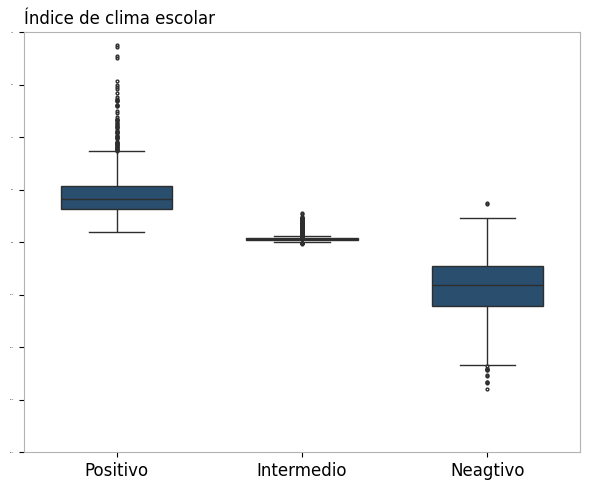

In [190]:
df_plot = pd.concat([
    df_clima_escolar.loc[df_clima_escolar['clima_escolar'] == 1, ['clima_escolar_1_shap']].assign(grupo='Neagtivo', shap_value=lambda d: d['clima_escolar_1_shap']),
    df_clima_escolar.loc[df_clima_escolar['clima_escolar'] == 2, ['clima_escolar_2_shap']].assign(grupo='Intermedio', shap_value=lambda d: d['clima_escolar_2_shap']),
    df_clima_escolar.loc[df_clima_escolar['clima_escolar'] == 3, ['clima_escolar_3_shap']].assign(grupo='Positivo', shap_value=lambda d: d['clima_escolar_3_shap'])
])

# Orden según mediana
order_resp = (
    df_plot.groupby("grupo")["shap_value"]
      .median()
      .sort_values(ascending=False)
      .index
)

# --- Boxplot ---
fig, ax = plt.subplots(figsize=(6, 5))


sns.boxplot(
    data=df_plot,
    x="grupo", y="shap_value",
    order=order_resp,
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax,
    orient='v'
)

ax.set_xlabel("")
ax.set_ylabel("", fontsize=12)
ax.set_ylim(-1,1)
ax.set_title("Índice de clima escolar", loc='left')

ax.tick_params(axis='x', rotation=0, labelsize=12)
ax.tick_params(axis='y', labelsize=0)
for s in ax.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax.grid(False)

plt.tight_layout()
plt.show()

##### Antigüedad director en el cargo

In [193]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_antiguedad_director_cargo = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [194]:
variables.loc[variables['variable']=='dp06b']['variable_a_nivel_colegio'].unique()

array(['dp06b_1.0', 'dp06b_2.0', 'dp06b_3.0', 'dp06b_4.0', 'dp06b_5.0'],
      dtype=object)

In [195]:
vars=['ID1','NSE_puntaje','dp06b_1.0', 'dp06b_2.0', 'dp06b_3.0', 'dp06b_4.0', 'dp06b_5.0', 'dp06b_1.0_shap', 'dp06b_2.0_shap', 'dp06b_3.0_shap', 'dp06b_4.0_shap', 'dp06b_5.0_shap']
df_antiguedad_director_cargo=df_antiguedad_director_cargo[vars]

col_excluir = ['NSE_puntaje', 'dp06b_1.0', 'dp06b_2.0', 'dp06b_3.0', 'dp06b_4.0', 'dp06b_5.0',]
df_antiguedad_director_cargo.loc[:, ~df_antiguedad_director_cargo.columns.isin(col_excluir)] *= 100
df_antiguedad_director_cargo.head()


ID1  NSE_puntaje  dp06b_1.0  dp06b_2.0  dp06b_3.0  dp06b_4.0  \
0  42345002740054200    -0.304836          0          0          0          0   
1  11396001332101100     0.693485          0          0          1          0   
2  33920098112339200     0.767152          0          0          1          0   
3  37800018183037800     0.782374          0          1          0          0   
4  88320040320008800     0.857615          0          0          1          0   

   dp06b_5.0  dp06b_1.0_shap  dp06b_2.0_shap  dp06b_3.0_shap  dp06b_4.0_shap  \
0          0        0.031504        0.001685       -0.003846       -0.001410   
1          0        0.030325        0.014358        0.011609       -0.005594   
2          0        0.021161       -0.004273        0.015153       -0.004890   
3          0        0.023382       -0.006337       -0.003864       -0.004525   
4          0        0.045012        0.097185        0.012574       -0.018677   

   dp06b_5.0_shap  
0       -0.039680  
1       -0.026174  
2       -0.041750  
3       -0.031741  
4       -0.059317

In [196]:
#Chequeamos que los valores de las variables sean o 0 o 1
print(df_antiguedad_director_cargo['dp06b_1.0'].unique())
print(df_antiguedad_director_cargo['dp06b_2.0'].unique())
print(df_antiguedad_director_cargo['dp06b_3.0'].unique())
print(df_antiguedad_director_cargo['dp06b_4.0'].unique())
print(df_antiguedad_director_cargo['dp06b_5.0'].unique())

[0 1]
[0 1]
[0 1]
[0 1]
[0 1]


In [197]:
#Acá estamos viendo cuantos no contestar o es NA. De esta manera excluimos al colegio del gráfico
df_antiguedad_director_cargo['sum_check']=df_antiguedad_director_cargo['dp06b_1.0']+df_antiguedad_director_cargo['dp06b_2.0']+df_antiguedad_director_cargo['dp06b_3.0']+df_antiguedad_director_cargo['dp06b_4.0']+df_antiguedad_director_cargo['dp06b_5.0']

df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['sum_check']==0].shape

(392, 13)

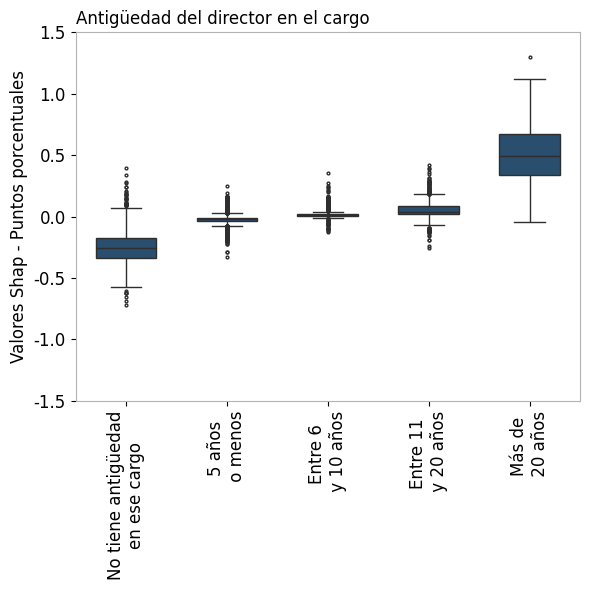

In [198]:
df_plot = pd.concat([
    df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['dp06b_1.0'] == 1, ['dp06b_1.0_shap']].assign(grupo='No tiene antigüedad\nen ese cargo', shap_value=lambda d: d['dp06b_1.0_shap']),
    df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['dp06b_2.0'] == 1, ['dp06b_2.0_shap']].assign(grupo='5 años\n o menos', shap_value=lambda d: d['dp06b_2.0_shap']),
    df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['dp06b_3.0'] == 1, ['dp06b_3.0_shap']].assign(grupo='Entre 6\n y 10 años', shap_value=lambda d: d['dp06b_3.0_shap']),
    df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['dp06b_4.0'] == 1, ['dp06b_4.0_shap']].assign(grupo='Entre 11\n y 20 años', shap_value=lambda d: d['dp06b_4.0_shap']),
    df_antiguedad_director_cargo.loc[df_antiguedad_director_cargo['dp06b_5.0'] == 1, ['dp06b_5.0_shap']].assign(grupo='Más de\n 20 años', shap_value=lambda d: d['dp06b_5.0_shap'])



])


# --- Boxplot ---
fig, ax = plt.subplots(figsize=(6, 6))

sns.boxplot(
    data=df_plot,
    x="grupo", y="shap_value",
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax,
    orient='v'
)

ax.set_xlabel("")
ax.set_title("Antigüedad del director en el cargo", loc='left')
ax.set_ylabel("Valores Shap - Puntos porcentuales", fontsize=12)
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(-1.5, 1.5) 
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f')) 

for s in ax.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax.grid(False)

plt.tight_layout()
plt.show()

##### Acceso del director al cargo

In [199]:
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']
#mergear los dos df
df_acceso_director_cargo = shap_values.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)

In [200]:
variables.loc[variables['variable']=='dp07']['variable_a_nivel_colegio'].unique()

array(['dp07_1.0', 'dp07_2.0', 'dp07_3.0', 'dp07_4.0', 'dp07_5.0'],
      dtype=object)

In [201]:
vars=['ID1','NSE_puntaje','dp07_1.0', 'dp07_2.0', 'dp07_3.0', 'dp07_4.0', 'dp07_5.0', 'dp07_1.0_shap', 'dp07_2.0_shap', 'dp07_3.0_shap', 'dp07_4.0_shap', 'dp07_5.0_shap']
df_acceso_director_cargo=df_acceso_director_cargo[vars]

col_excluir = ['NSE_puntaje', 'dp07_1.0', 'dp07_2.0', 'dp07_3.0', 'dp07_4.0', 'dp07_5.0']
df_acceso_director_cargo.loc[:, ~df_acceso_director_cargo.columns.isin(col_excluir)] *= 100
df_acceso_director_cargo.head()


ID1  NSE_puntaje  dp07_1.0  dp07_2.0  dp07_3.0  dp07_4.0  \
0  42345002740054200    -0.304836         0         0         0         0   
1  11396001332101100     0.693485         0         0         0         1   
2  33920098112339200     0.767152         0         0         1         0   
3  37800018183037800     0.782374         0         0         0         1   
4  88320040320008800     0.857615         0         0         0         1   

   dp07_5.0  dp07_1.0_shap  dp07_2.0_shap  dp07_3.0_shap  dp07_4.0_shap  \
0         0              0              0       0.005887      -0.053308   
1         0              0              0       0.033051       0.195315   
2         0              0              0      -0.034765      -0.034384   
3         0              0              0       0.010153       0.119263   
4         0              0              0       0.017209       0.095196   

   dp07_5.0_shap  
0      -0.000816  
1      -0.001238  
2      -0.002114  
3      -0.001750  
4      -0.004018

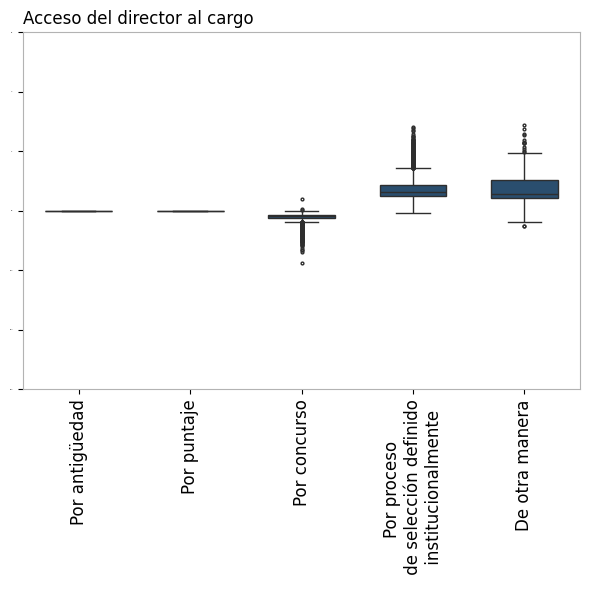

In [203]:
df_plot = pd.concat([
    df_acceso_director_cargo.loc[df_acceso_director_cargo['dp07_1.0'] == 1, ['dp07_1.0_shap']].assign(grupo='Por antigüedad', shap_value=lambda d: d['dp07_1.0_shap']),
    df_acceso_director_cargo.loc[df_acceso_director_cargo['dp07_2.0'] == 1, ['dp07_2.0_shap']].assign(grupo='Por puntaje', shap_value=lambda d: d['dp07_2.0_shap']),
    df_acceso_director_cargo.loc[df_acceso_director_cargo['dp07_3.0'] == 1, ['dp07_3.0_shap']].assign(grupo='Por concurso', shap_value=lambda d: d['dp07_3.0_shap']),
    df_acceso_director_cargo.loc[df_acceso_director_cargo['dp07_4.0'] == 1, ['dp07_4.0_shap']].assign(grupo='Por proceso\n de selección definido\n institucionalmente', shap_value=lambda d: d['dp07_4.0_shap']),
    df_acceso_director_cargo.loc[df_acceso_director_cargo['dp07_5.0'] == 1, ['dp07_5.0_shap']].assign(grupo='De otra manera', shap_value=lambda d: d['dp07_5.0_shap'])



])


# --- Boxplot ---
fig, ax = plt.subplots(figsize=(6,6))

sns.boxplot(
    data=df_plot,
    x="grupo", y="shap_value",
    color=COLOR_BLUE_MAIN,
    fliersize=2, width=0.6,
    ax=ax,
    orient='v'
)


ax.set_title("Acceso del director al cargo", loc='left')
ax.set_xlabel("")
ax.set_ylabel("", fontsize=12)
ax.set_ylim(-1, 1) 
#ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))  
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.tick_params(axis='y', labelsize=0)
ax.set_ylim(-1.5, 1.5) 

for s in ax.spines.values():
    s.set_color("#b3b3b3"); s.set_linewidth(0.8)
ax.grid(False)

plt.tight_layout()
plt.show()

In [204]:
print(df_acceso_director_cargo['dp07_1.0'].sum())
print(df_acceso_director_cargo['dp07_2.0'].sum())
print(df_acceso_director_cargo['dp07_3.0'].sum())
print(df_acceso_director_cargo['dp07_4.0'].sum())
print(df_acceso_director_cargo['dp07_5.0'].sum())


440
1486
3884
2423
376


### 3.3 Diferencias entre colegios de NSE bajo con alto y bajo rendimiento

En esta sección realizamos todos los gráficos y cálculos que corresponden al ejercicio que busca determinar los principales factores que explican la diferencia en el rendimiento entre colegios de NSE bajo

#### P1. ¿dónde están las principales diferencias: factores del hogar, de contexto, individuales, institucionales o trayectoria escolar?

In [205]:
#Filtramos outliers --> NSE menor que -1
df_diferencias=shap_values.loc[shap_values['NSE_puntaje']>-1].copy()

In [206]:
# Armamos categorias NSE y de desempeño
p33 = np.percentile(df_diferencias["NSE_puntaje"], 33) 
p90 = np.percentile(df_diferencias["NSE_puntaje"], 90)

# Función para clasificar según percentiles
def clasificar_nse(puntaje):
    if puntaje <= p33:
        return "bajo"
    elif puntaje >= p90:
        return "alto"
    else:
        return "medio"

# Aplicar al DataFrame
df_diferencias["NSE_nivel_grupo"] = df_diferencias["NSE_puntaje"].apply(clasificar_nse)

In [207]:
#Segmentamos por desempeño
# Crear la nueva columna con categorías
def clasificar_percentil(valor):
    if valor < 0.33:
        return "bajo"
    elif valor > 0.55:
        return "alto"
    else:
        return "medio"

df_diferencias["categoria_satisfactorio"] = df_diferencias["porcentaje_satisfactorio"].apply(clasificar_percentil)
df_diferencias.groupby(['categoria_satisfactorio','NSE_nivel_grupo'])['porcentaje_satisfactorio'].describe().round(2).reset_index()

categoria_satisfactorio NSE_nivel_grupo   count  mean   std   min   25%  \
0                    alto            alto   840.0  0.79  0.10  0.55  0.72   
1                    alto            bajo   185.0  0.69  0.13  0.55  0.59   
2                    alto           medio  2113.0  0.68  0.09  0.55  0.60   
3                    bajo            alto    12.0  0.11  0.10  0.00  0.03   
4                    bajo            bajo  1874.0  0.20  0.08  0.00  0.15   
5                    bajo           medio   879.0  0.24  0.08  0.00  0.20   
6                   medio            alto    45.0  0.46  0.07  0.33  0.43   
7                   medio            bajo   898.0  0.41  0.06  0.33  0.36   
8                   medio           medio  2115.0  0.44  0.06  0.33  0.39   

    50%   75%   max  
0  0.80  0.86  1.00  
1  0.64  0.76  1.00  
2  0.67  0.74  1.00  
3  0.12  0.17  0.31  
4  0.22  0.27  0.33  
5  0.26  0.30  0.33  
6  0.47  0.52  0.55  
7  0.40  0.45  0.55  
8  0.44  0.50  0.55

In [208]:
df_vars = variables.copy()

# columnas que NO querés incluir
excluir = ["ID1", "porcentaje_satisfactorio", "numero_alumnos", "NSE_puntaje"]

cols_shap = [
    c for c in df_diferencias.columns
    if c.endswith("_shap") and c not in excluir
]

map_cols = pd.DataFrame({
    "col_shap": cols_shap,
    "variable_a_nivel_colegio": [c.replace("_shap", "") for c in cols_shap]
})

map_cols = map_cols.merge(
    df_vars[["variable_a_nivel_colegio", "categoria_shap", "Nombre reducido"]],
    on="variable_a_nivel_colegio",
    how="left"
)

map_cols["categoria_shap"] = map_cols["categoria_shap"].fillna("Factores de contexto")

In [209]:
map_cols.loc[
    map_cols["Nombre reducido"].isna() & 
    map_cols["variable_a_nivel_colegio"].str.startswith("jurisdiccion_"),
    "Nombre reducido"
] = "Jurisdicción"

map_cols.loc[
    map_cols["Nombre reducido"].isna() & 
    map_cols["variable_a_nivel_colegio"].str.startswith("region_"),
    "Nombre reducido"
] = "Región"

map_cols.loc[
    map_cols["Nombre reducido"].isna() & 
    map_cols["variable_a_nivel_colegio"].str.startswith("clima_escolar_"),
    "Nombre reducido"
] = "Clima escolar"

# Resto de los NaN → "Otros"
map_cols.loc[
    map_cols["Nombre reducido"].isna(),
    "Nombre reducido"
] = "Otros"


In [210]:
factores_contexto=map_cols.loc[map_cols['categoria_shap']=='Factores de contexto']['col_shap'].unique()
factores_institucionales=map_cols.loc[map_cols['categoria_shap']=='Factores institucionales']['col_shap'].unique()
factores_del_hogar=map_cols.loc[map_cols['categoria_shap']=='Factores del hogar']['col_shap'].unique()
factores_individuales=map_cols.loc[map_cols['categoria_shap']=='Factores individuales']['col_shap'].unique()
trayectoria_escolar=map_cols.loc[map_cols['categoria_shap']=='Trayectoria escolar']['col_shap'].unique()

In [211]:
# tabla
tabla_1 = df_diferencias.copy()

tabla_1['factores_contexto']    = tabla_1[factores_contexto].sum(axis=1)*100
tabla_1['factores_institucionales']    = tabla_1[factores_institucionales].sum(axis=1)*100
tabla_1['fatores_hogar']  = tabla_1[factores_del_hogar].sum(axis=1)*100
tabla_1['factores_individuales'] = tabla_1[factores_individuales].sum(axis=1)*100
tabla_1['trayectoria_escolar']     = tabla_1[trayectoria_escolar].sum(axis=1)*100

cols_keep = [
    'NSE_nivel_grupo', 'categoria_satisfactorio',
    'factores_contexto','factores_institucionales','fatores_hogar','factores_individuales','trayectoria_escolar'
]
tabla_1 = tabla_1[cols_keep]
tabla_1 = (
    tabla_1
    .groupby(['NSE_nivel_grupo','categoria_satisfactorio'], dropna=False)
    [['factores_contexto','factores_institucionales','fatores_hogar','factores_individuales','trayectoria_escolar']]
    .mean()
    .reset_index()
)



valor_real = 'porcentaje_satisfactorio' 
porcentaje_satisfactorio = (
    df_diferencias
    .groupby(['NSE_nivel_grupo','categoria_satisfactorio'], dropna=False)[valor_real]
    .mean()
    .rename('porcentaje_satisfactorio')
    .reset_index()
)

tabla_1 = tabla_1.merge(porcentaje_satisfactorio, on=['NSE_nivel_grupo','categoria_satisfactorio'], how='left')


tabla_1.loc[tabla_1['NSE_nivel_grupo']=='bajo'].round(2)

NSE_nivel_grupo categoria_satisfactorio  factores_contexto  \
3            bajo                    alto               1.02   
4            bajo                    bajo              -1.84   
5            bajo                   medio              -0.94   

   factores_institucionales  fatores_hogar  factores_individuales  \
3                      1.03          -1.54                   2.22   
4                     -0.61          -8.19                  -6.19   
5                     -0.10          -5.36                  -1.26   

   trayectoria_escolar  porcentaje_satisfactorio  
3                 2.45                      0.69  
4                -4.21                      0.20  
5                -1.21                      0.41

In [212]:
tabla_1["Total"] = tabla_1[
    ['factores_contexto', 'factores_institucionales', 'fatores_hogar',
     'factores_individuales', 'trayectoria_escolar']
].sum(axis=1)

tabla_1.loc[tabla_1['NSE_nivel_grupo']=='bajo'].round(2)

NSE_nivel_grupo categoria_satisfactorio  factores_contexto  \
3            bajo                    alto               1.02   
4            bajo                    bajo              -1.84   
5            bajo                   medio              -0.94   

   factores_institucionales  fatores_hogar  factores_individuales  \
3                      1.03          -1.54                   2.22   
4                     -0.61          -8.19                  -6.19   
5                     -0.10          -5.36                  -1.26   

   trayectoria_escolar  porcentaje_satisfactorio  Total  
3                 2.45                      0.69   5.18  
4                -4.21                      0.20 -21.04  
5                -1.21                      0.41  -8.88

#### P2. ¿Cuáles son las variables importantes para explicar el buen desempeño predicho para las escuelas de NSE bajo y rendimiento alto, es decir, con valores Shap positivos más elevados?

In [213]:
#Agregamos los valores de las variables
columnas_excluidas=['porcentaje_satisfactorio','jurisdiccion','numero_alumnos','NSE_puntaje','not_missing_matematica_ni_lengua']

#mergear los dos df
df_diferencias = df_diferencias.merge(
    data_colegios.drop(columns=columnas_excluidas),
    on='ID1',
    how='left'
)


In [214]:
desempeño_alto=df_diferencias.loc[(df_diferencias['NSE_nivel_grupo']=='bajo')&(df_diferencias['categoria_satisfactorio']=='alto')]
desempeño_bajo=df_diferencias.loc[(df_diferencias['NSE_nivel_grupo']=='bajo')&(df_diferencias['categoria_satisfactorio']=='bajo')]

In [215]:
map_cols.rename(columns={'Nombre reducido':'short_name'}, inplace=True)

In [216]:
shap_cols = [col for col in desempeño_alto.columns if "shap" in col.lower() and desempeño_alto[col].dtype != 'object']

# 1) Stats de ALTO: calculamos promedio, minimo y máximo por variable
desempeño_alto_stats = ((desempeño_alto[shap_cols].agg(['mean','max','min']).T).round(3) * 100)

# Pasar nombres de variables (índice) a columna y quitar sufijo _shap
desempeño_alto_stats = (desempeño_alto_stats
    .reset_index()
    .rename(columns={'index':'variable_a_nivel_colegio'}))
desempeño_alto_stats['variable_a_nivel_colegio'] = (
    desempeño_alto_stats['variable_a_nivel_colegio'].str.replace('_shap$', '', regex=True)
)

# Merge con short_name
desempeño_alto_stats = desempeño_alto_stats.merge(
    map_cols[['variable_a_nivel_colegio','short_name']], 
    how='left', 
    on='variable_a_nivel_colegio'
)

# Ordenar columnas
desempeño_alto_stats = desempeño_alto_stats[['variable_a_nivel_colegio','short_name','mean','max','min']]

In [217]:
desempeño_alto_stats.sort_values(by='mean', ascending=False).head(10)

variable_a_nivel_colegio                       short_name  mean   max  min
6       jurisdiccion_Córdoba                     Jurisdicción   0.8  10.6 -1.5
165              ap05h_1_pct  Crear contenidos redes sociales   0.7   5.8 -3.3
8       jurisdiccion_Formosa                     Jurisdicción   0.6  10.6 -0.2
109              ap09k_1_pct                           Tablet   0.4   1.9 -1.4
151               ap10_6_pct               Libros en el hogar   0.4   2.0 -0.2
80                ap22_1_pct                       Repitencia   0.3   4.4 -2.6
66               ap27b_1_pct          Opinión escritura texto   0.3   1.9 -1.2
60               ap06c_1_pct    Actividades: tareas del hogar   0.3   2.1 -1.8
44               ap27a_1_pct            Opinión lectura texto   0.2   1.4 -0.9
46               ap27a_3_pct            Opinión lectura texto   0.2   1.9 -0.4

##### Variables más influenyes NSE bajo desempeño alto, en promedio

Vemos que dos jurisdicciones salen como importantes. No obstante, como está promediando todos los colegios (independientemente de su jurisdicción, filtramos por jurisdicción)

In [218]:
rows = []
for jur in desempeño_alto['jurisdiccion'].dropna().unique():
    col = f'jurisdiccion_{jur}_shap'
    if col in desempeño_alto.columns:
        val = desempeño_alto.loc[desempeño_alto['jurisdiccion'] == jur, col].mean() * 100
        rows.append({"jurisdiccion": jur, "mean_shap_%": val})

out = (pd.DataFrame(rows)
         .sort_values("mean_shap_%", ascending=False)
         .reset_index(drop=True))
out.sort_values(by='mean_shap_%', ascending=False).head()

jurisdiccion  mean_shap_%
0                          Formosa     6.755979
1                          Córdoba     6.594405
2                       Corrientes     2.163248
3  Ciudad Autónoma de Buenos Aires     1.892374
4                            Salta     0.805915

¿Qué pasa con el contenido en redes sociales? La correlación es muy negativa. ¿y por qué a estos colegios les aporta positivamente y a bajo-bajo, no? Vemos como se distribuye la variable en cada uno de estos segmentos

**Promedios de respuesta afirmativa por escuelas según categorías**

Las de NSE bajo y alto desempeño usan en promedio 38% mientras que el 45% de las bajo bajo

In [219]:
df_diferencias.groupby(['NSE_nivel_grupo','categoria_satisfactorio'])['ap05h_1_pct'].mean().reset_index().round(3)

NSE_nivel_grupo categoria_satisfactorio  ap05h_1_pct
0            alto                    alto        0.351
1            alto                    bajo        0.379
2            alto                   medio        0.366
3            bajo                    alto        0.377
4            bajo                    bajo        0.454
5            bajo                   medio        0.405
6           medio                    alto        0.379
7           medio                    bajo        0.453
8           medio                   medio        0.408

In [220]:
# ====== RANGO Y COMÚN ======
y_all = pd.concat([
    desempeño_alto["ap05h_1_pct_shap"],
    desempeño_bajo["ap05h_1_pct_shap"]
], axis=0).apply(pd.to_numeric, errors="coerce")

# pasar a porcentaje
y_all = y_all * 100

y_min = y_all.min()
y_max = y_all.max()

# margen visual (5%)
pad = 0.05 * (y_max - y_min)
y_lim = (y_min - pad, y_max + pad)

print(y_lim)


(-4.505148337496257, 6.317053884076676)


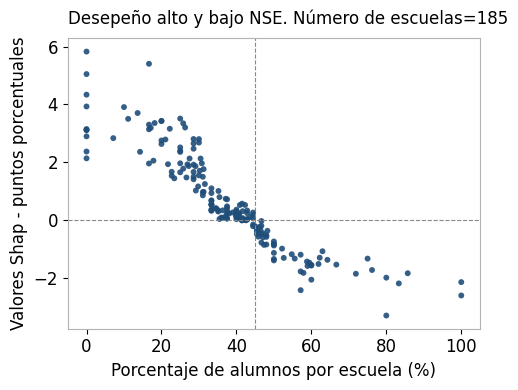

In [221]:
# ====== DATA ======
cols = ["ap05h_1_pct", "ap05h_1_pct_shap"]

tmp = (desempeño_alto[cols]
       .apply(pd.to_numeric, errors="coerce")
       .dropna())

# Pasar a porcentajes
tmp["ap05h_1_pct"] *= 100
tmp["ap05h_1_pct_shap"] *= 100  # si querés dejar en puntos p.p.

# ====== FIGURA ======
fig, ax = plt.subplots(figsize=(5, 4))

sns.scatterplot(
    data=tmp,
    x="ap05h_1_pct",
    y="ap05h_1_pct_shap",
    s=18,
    alpha=0.9,
    color=COLOR_BLUE_MAIN,
    edgecolor="none",
    ax=ax
)

# Líneas guía
ax.axhline(0, linestyle="--", linewidth=0.8, color="#888")
ax.axvline(45, linestyle="--", linewidth=0.8, color="#888")

# Ejes y etiquetas
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=12)
ax.set_ylabel("Valores Shap - puntos porcentuales", fontsize=12)

# Formato de eje X en enteros
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Estilo de spines y ticks
for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.grid(False)

# Título (si lo querés mantener)
ax.set_title(
    "Desepeño alto y bajo NSE. Número de escuelas=185",
    loc="left",
    fontsize=12,
    pad=10
)

plt.tight_layout()


In [222]:
## Punto quiebre
aux=desempeño_alto.copy()

aux["pct"] = aux["ap05h_1_pct"] * 100
aux["shap"] = aux["ap05h_1_pct_shap"] * 100

aux = aux.sort_values("pct")

for v in aux["pct"].unique():
    subset = aux.loc[aux["pct"] >= v, "shap"]
    if (subset < 0).all():
        quiebre = v
        break

print("Punto de quiebre (todos negativos):", quiebre)


Punto de quiebre (todos negativos): 45.0


In [223]:
#Check
print('check:', desempeño_alto.loc[desempeño_alto['ap05h_1_pct']>0.45]['ap05h_1_pct_shap'].max())

pct = (desempeño_alto["ap05h_1_pct"] > 0.45).mean() * 100
pct_shap = (desempeño_alto["ap05h_1_pct_shap"] < 0).mean() * 100

print(f"Porcentaje de colegios con variable >45%: {pct:.2f}%")

check: -0.000391402222267061
Porcentaje de colegios con variable >45%: 28.65%


Calculamos lo mismo pero para desempeño bajo

In [224]:
shap_cols = [col for col in desempeño_bajo.columns if "shap" in col.lower() and desempeño_bajo[col].dtype != 'object']

# 1) Stats de bajo: calculamos promedio, minimo y máximo por variable
desempeño_bajo_stats = ((desempeño_bajo[shap_cols].agg(['mean','max','min']).T).round(3) * 100)

# Pasar nombres de variables (índice) a columna y quitar sufijo _shap
desempeño_bajo_stats = (desempeño_bajo_stats
    .reset_index()
    .rename(columns={'index':'variable_a_nivel_colegio'}))
desempeño_bajo_stats['variable_a_nivel_colegio'] = (
    desempeño_bajo_stats['variable_a_nivel_colegio'].str.replace('_shap$', '', regex=True)
)

# Merge con short_name
desempeño_bajo_stats = desempeño_bajo_stats.merge(
    map_cols[['variable_a_nivel_colegio','short_name']], 
    how='left', 
    on='variable_a_nivel_colegio'
)

# Ordenar columnas
desempeño_bajo_stats = desempeño_bajo_stats[['variable_a_nivel_colegio','short_name','mean','max','min']]

In [225]:
desempeño_bajo.shape

(1874, 644)

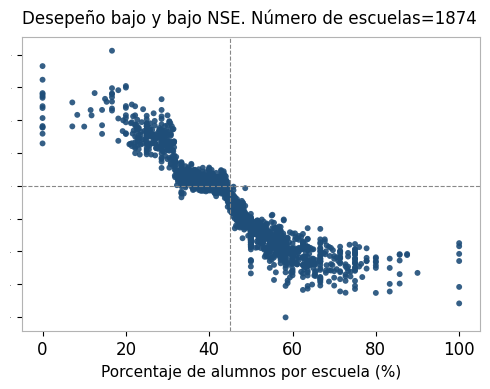

In [226]:
# ====== DATA ======
cols = ["ap05h_1_pct", "ap05h_1_pct_shap"]

tmp = (desempeño_bajo[cols]
       .apply(pd.to_numeric, errors="coerce")
       .dropna())

# Pasar a porcentajes
tmp["ap05h_1_pct"] *= 100
tmp["ap05h_1_pct_shap"] *= 100  # si querés dejar en puntos p.p.

# ====== FIGURA ======
fig, ax = plt.subplots(figsize=(5, 4))

sns.scatterplot(
    data=tmp,
    x="ap05h_1_pct",
    y="ap05h_1_pct_shap",
    s=18,
    alpha=0.9,
    color=COLOR_BLUE_MAIN,
    edgecolor="none",
    ax=ax
)

# Líneas guía
ax.axhline(0, linestyle="--", linewidth=0.8, color="#888")
ax.axvline(45, linestyle="--", linewidth=0.8, color="#888")

# Ejes y etiquetas
ax.set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
ax.set_ylabel("", fontsize=11)

# Formato de eje X en enteros
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Estilo de spines y ticks
for spine in ax.spines.values():
    spine.set_color(COLOR_SPINE)
    spine.set_linewidth(0.8)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=0)

ax.grid(False)

# Título (si lo querés mantener)
ax.set_title(
    "Desepeño bajo y bajo NSE. Número de escuelas=1874",
    loc="left",
    fontsize=12,
    pad=10
)

plt.tight_layout()

In [227]:
## Punto quiebre
aux=desempeño_bajo.copy()

aux["pct"] = aux["ap05h_1_pct"] * 100
aux["shap"] = aux["ap05h_1_pct_shap"] * 100

aux = aux.sort_values("pct")

for v in aux["pct"].unique():
    subset = aux.loc[aux["pct"] >= v, "shap"]
    if (subset < 0).all():
        quiebre = v
        break

print("Punto de quiebre (todos negativos):", quiebre)


Punto de quiebre (todos negativos): 44.57831325301205


In [228]:
#Check
print('check:', desempeño_bajo.loc[desempeño_bajo['ap05h_1_pct']>0.45]['ap05h_1_pct_shap'].max())

pct = (desempeño_bajo["ap05h_1_pct"] > 0.45).mean() * 100
pct_shap = (desempeño_bajo["ap05h_1_pct_shap"] < 0).mean() * 100

print(f"Porcentaje de colegios con variable >45%: {pct:.2f}%")

check: -0.0002867638299267128
Porcentaje de colegios con variable >45%: 49.31%


##### Box córdoba

**Córdoba**

In [231]:
desempeño_alto_cordoba=desempeño_alto.loc[desempeño_alto['jurisdiccion']=='Córdoba']
print('Cantidad de colegios:', desempeño_alto_cordoba.shape[0])

Cantidad de colegios: 41


In [232]:
#Colegios con jornada de 6 horas
desempeño_alto_cordoba=desempeño_alto.loc[(desempeño_alto['jurisdiccion']=='Córdoba')&(desempeño_alto['dp47_4.0']==1)]
print('Cantidad de colegios:', desempeño_alto_cordoba.shape[0])

Cantidad de colegios: 40


In [233]:
# 1) Stats de ALTO: calculamos promedio, minimo y máximo por variable
desempeño_alto_cordoba_stats = ((desempeño_alto_cordoba[shap_cols].agg(['mean','max','min']).T).round(4) * 100)

# Pasar nombres de variables (índice) a columna y quitar sufijo _shap
desempeño_alto_cordoba_stats = (desempeño_alto_cordoba_stats
    .reset_index()
    .rename(columns={'index':'variable_a_nivel_colegio'}))
desempeño_alto_cordoba_stats['variable_a_nivel_colegio'] = (
    desempeño_alto_cordoba_stats['variable_a_nivel_colegio'].str.replace('_shap$', '', regex=True)
)
desempeño_alto_cordoba_stats.sort_values(by='mean', ascending=False).head()

variable_a_nivel_colegio  mean    max   min
6       jurisdiccion_Córdoba  6.62  10.63  3.49
80                ap22_1_pct  1.03   4.37 -2.41
182                 dp47_4.0  0.77   1.40  0.28
151               ap10_6_pct  0.46   1.39 -0.12
148               ap10_3_pct  0.44   1.87 -0.28

In [234]:
desempeño_alto_cordoba.shape

(40, 644)

In [235]:
desempeño_alto_cordoba.loc[desempeño_alto_cordoba['dp47_4.0_shap']>=0.00951].shape

(10, 644)

¿Cuál es el aporte en el resto de lo grupos?

-- NSE bajo bajo desempeño

-- Todos los desempeños pero según NSE

In [236]:
desempeño_bajo_cordoba=desempeño_bajo.loc[desempeño_bajo['jurisdiccion']=='Córdoba']
print('Cantidad de colegios:', desempeño_bajo_cordoba.shape[0])

Cantidad de colegios: 79


In [237]:
#Colegios con jornada de 6 horas
desempeño_bajo_cordoba=desempeño_bajo.loc[(desempeño_bajo['jurisdiccion']=='Córdoba')&(desempeño_bajo['dp47_4.0']==1)]
print('Cantidad de colegios:', desempeño_bajo_cordoba.shape[0])

Cantidad de colegios: 74


In [238]:
# 1) Stats de bajo: calculamos promedio, minimo y máximo por variable
desempeño_bajo_cordoba_stats = ((desempeño_bajo_cordoba[shap_cols].agg(['mean','max','min']).T).round(4) * 100)

# Pasar nombres de variables (índice) a columna y quitar sufijo _shap
desempeño_bajo_cordoba_stats = (desempeño_bajo_cordoba_stats
    .reset_index()
    .rename(columns={'index':'variable_a_nivel_colegio'}))
desempeño_bajo_cordoba_stats['variable_a_nivel_colegio'] = (
    desempeño_bajo_cordoba_stats['variable_a_nivel_colegio'].str.replace('_shap$', '', regex=True)
)
desempeño_bajo_cordoba_stats.sort_values(by='mean', ascending=False).head(5)

variable_a_nivel_colegio  mean   max   min
6       jurisdiccion_Córdoba  4.01  7.38  1.83
182                 dp47_4.0  0.49  1.22  0.10
109              ap09k_1_pct  0.06  0.87 -1.30
76               ap27c_1_pct  0.06  0.77 -0.28
7    jurisdiccion_Entre Ríos  0.05  0.07  0.02

In [239]:
cordoba_completo=df_diferencias.loc[(df_diferencias['jurisdiccion']=='Córdoba')&(df_diferencias['dp47_4.0']==1)]
cordoba_completo.groupby('NSE_nivel_grupo')['ID1'].nunique().reset_index()

NSE_nivel_grupo  ID1
0            alto    9
1            bajo  202
2           medio  319

In [240]:
cordoba_completo.groupby('NSE_nivel_grupo')['dp47_4.0_shap'].mean().reset_index()

NSE_nivel_grupo  dp47_4.0_shap
0            alto       0.002733
1            bajo       0.005983
2           medio       0.005347

b. Análisis de las 6 hs de clase. ¿Cuántos colegios, por fuera de Córdoba tienen 6 horas de clase?



In [241]:
print('Total colegios con 6 hs de clase:',  df_diferencias['dp47_4.0'].sum(), 'y porcentaje de colegios con 6 hs de clase:' , df_diferencias['dp47_4.0'].sum()/df_diferencias.shape[0]*100)
print('Porcentaje de colegios con 6 hs de clase, Córdoba/Total:' , df_diferencias.loc[df_diferencias['jurisdiccion']=='Córdoba']['dp47_4.0'].sum()/df_diferencias['dp47_4.0'].sum())

print('Número de colegios de Cdba con 6 hs:', df_diferencias.loc[df_diferencias['jurisdiccion']=='Córdoba']['dp47_4.0'].sum())

Total colegios con 6 hs de clase: 810 y porcentaje de colegios con 6 hs de clase: 9.039169735520588
Porcentaje de colegios con 6 hs de clase, Córdoba/Total: 0.654320987654321
Número de colegios de Cdba con 6 hs: 530


In [244]:
print('Escuelas de gestión estatal Córdoba:', df_diferencias.loc[(df_diferencias['jurisdiccion']=='Córdoba')&(df_diferencias['sector']==1)].shape[0])
print('Escuelas de gestión estatal Córdoba con 6 horas:',df_diferencias.loc[(df_diferencias['jurisdiccion']=='Córdoba')&(df_diferencias['sector']==1)&(df_diferencias['dp47_4.0']==1)].shape[0])
print('Proporción escuelas de gestión estatal Córdoba con 6 horas:',513/579*100)

Escuelas de gestión estatal Córdoba: 579
Escuelas de gestión estatal Córdoba con 6 horas: 513
Proporción escuelas de gestión estatal Córdoba con 6 horas: 88.60103626943005


In [245]:
print('Escuelas de gestión estatal resto del país:', df_diferencias.loc[(df_diferencias['jurisdiccion']!='Córdoba')&(df_diferencias['sector']==1)].shape[0])
print('Escuelas de gestión estatal Córdoba con 6 horas:',df_diferencias.loc[(df_diferencias['jurisdiccion']!='Córdoba')&(df_diferencias['sector']==1)&(df_diferencias['dp47_4.0']==1)].shape[0])
print('Proporción escuelas de gestión estatal Córdoba con 6 horas:',162/5506*100)

Escuelas de gestión estatal resto del país: 5506
Escuelas de gestión estatal Córdoba con 6 horas: 162
Proporción escuelas de gestión estatal Córdoba con 6 horas: 2.942244823828551


In [246]:
#Test de diferencia de medias

In [247]:
grupo_alto = df_diferencias.loc[
    (df_diferencias['jurisdiccion'] == 'Córdoba') &
    (df_diferencias['dp47_4.0'] == 1) &
    (df_diferencias['NSE_nivel_grupo'] == 'bajo') &
    (df_diferencias['categoria_satisfactorio'] == 'alto')
]['dp47_4.0_shap']

grupo_alto.shape

(40,)

In [248]:
grupo_bajo = df_diferencias.loc[
    (df_diferencias['jurisdiccion'] == 'Córdoba') &
    (df_diferencias['dp47_4.0'] == 1) &
    (df_diferencias['NSE_nivel_grupo'] == 'bajo') &
    (df_diferencias['categoria_satisfactorio'] == 'bajo')
]['dp47_4.0_shap']

grupo_bajo.shape

(74,)

In [249]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(
    grupo_alto,
    grupo_bajo,
    equal_var=False,   # Welch test
    nan_policy="omit"
)

t_stat, p_value

(5.654987457855357, 3.22835547253252e-07)

#### P3. ¿Qué factores contribuyen de manera negativa a la predicción en las escuelas de NSE bajo y bajo desempeño?

In [250]:
#desempeño_bajo
#desempeño_bajo_stats

In [251]:
desempeño_bajo_stats.sort_values(by='mean', ascending=True).head(10) 

variable_a_nivel_colegio                       short_name  mean  max  min
158              ap09i_1_pct                      Computadora  -2.0  2.3 -3.8
80                ap22_1_pct                       Repitencia  -1.3  3.4 -3.4
34   personas_por_habitacion          Personas por habitación  -1.0  1.8 -2.7
146               ap10_1_pct               Libros en el hogar  -0.9  2.7 -3.6
32                    sector                Sector de gestión  -0.8  2.3 -1.4
147               ap10_2_pct               Libros en el hogar  -0.8  1.8 -2.1
6       jurisdiccion_Córdoba                     Jurisdicción  -0.7  7.4 -1.6
167               ap26_1_pct    Tiempo en llegar a la escuela  -0.6  2.0 -2.4
165              ap05h_1_pct  Crear contenidos redes sociales  -0.5  4.1 -4.0
141              ap05f_1_pct          Jugar manera no digital  -0.5  1.1 -2.1

In [252]:
##### Diferencias tenencia computadora

((df_diferencias.groupby(['NSE_nivel_grupo','categoria_satisfactorio'])[['ap09i_1_pct','ap09i_1_pct_shap']].mean())*100).reset_index()

NSE_nivel_grupo categoria_satisfactorio  ap09i_1_pct  ap09i_1_pct_shap
0            alto                    alto    94.683658          4.025050
1            alto                    bajo    94.998813          3.126714
2            alto                   medio    91.013156          3.284702
3            bajo                    alto    44.797507         -1.329125
4            bajo                    bajo    43.558214         -2.019189
5            bajo                   medio    47.656260         -1.632510
6           medio                    alto    78.667325          1.996547
7           medio                    bajo    59.524402         -0.773594
8           medio                   medio    65.914099          0.150313

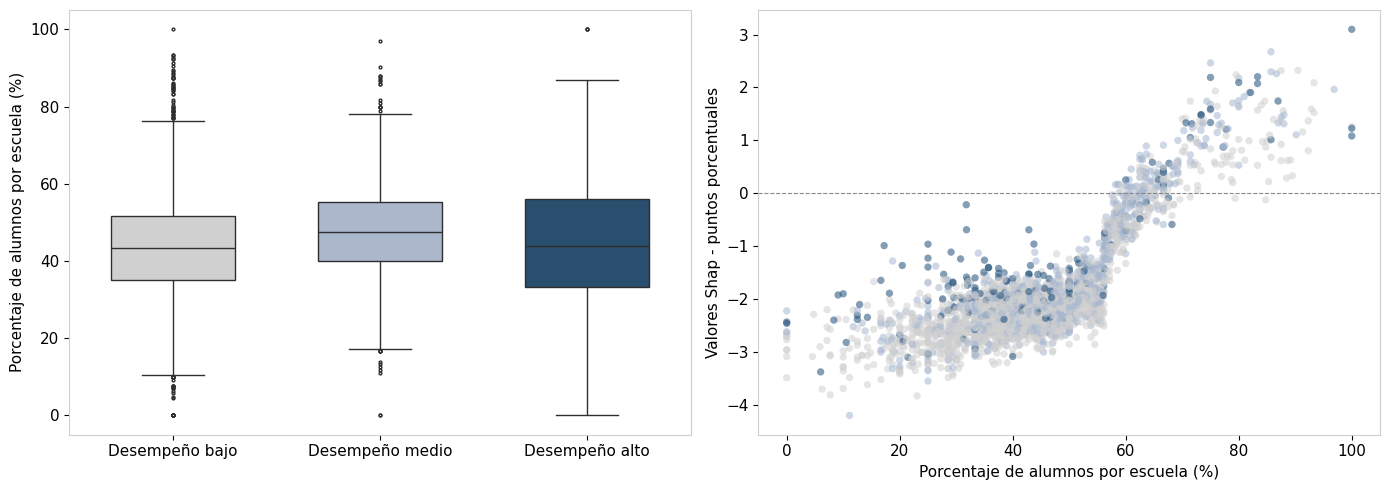

In [254]:
COLOR_BLUE_DARK  = "#1F4E79"
COLOR_BLUE_LIGHT = "#A6B7D0"
COLOR_GRAY_LIGHT       = "#D0D0D0"

palette_custom = [ COLOR_GRAY_LIGHT,COLOR_BLUE_LIGHT, COLOR_BLUE_DARK]

# ===== Diccionario de etiquetas =====
label_map = {
    "bajo": "Desempeño bajo",
    "medio": "Desempeño medio",
    "alto": "Desempeño alto"
}

df_bajo = df_diferencias[df_diferencias["NSE_nivel_grupo"] == "bajo"].copy()
df_bajo["ap09i_1_pct"]=df_bajo["ap09i_1_pct"]*100
df_bajo["ap09i_1_pct_shap"]=df_bajo["ap09i_1_pct_shap"]*100


df_bajo["categoria_satisfactorio_label"] = df_bajo["categoria_satisfactorio"].map(label_map)

# ===== Figura =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

sns.boxplot(
    data=df_bajo,
    x="categoria_satisfactorio_label",
    y="ap09i_1_pct",
    palette=palette_custom,
    fliersize=2,
    width=0.6,
    ax=axes[0]
)

#axes[0].set_title("Alumnos con computadora (NSE bajo)", loc="left", fontsize=11)
axes[0].set_xlabel("")
axes[0].set_ylabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
axes[0].tick_params(axis="x", rotation=0, labelsize=11)
axes[0].tick_params(axis="y", labelsize=11)

# Spines
for spine in axes[0].spines.values():
    spine.set_color(COLOR_GRAY_LIGHT)
    spine.set_linewidth(0.8)

axes[0].grid(False)

# =========================================================
# 2) SCATTER PLOT — MISMA ESTÉTICA QUE TUS SCATTERS SHAP
# =========================================================

sns.scatterplot(
    data=df_bajo,
    x="ap09i_1_pct",
    y="ap09i_1_pct_shap",
    hue="categoria_satisfactorio_label",
    palette=palette_custom,
    s=28,
    alpha=0.55,
    ax=axes[1],
    edgecolor="none"
)

#axes[1].set_title("Valor SHAP según % de alumnos con computadora", loc="left", fontsize=13)
axes[1].set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
axes[1].set_ylabel("Valores Shap - puntos porcentuales", fontsize=11)

axes[1].tick_params(axis="x", labelsize=11)
axes[1].tick_params(axis="y", labelsize=11)

# Línea guía SHAP = 0
axes[1].axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Formato del eje X (porcentajes enteros)
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Estilo de spines
for spine in axes[1].spines.values():
    spine.set_color(COLOR_GRAY_LIGHT)
    spine.set_linewidth(0.8)

axes[1].grid(False)

# Leyenda sin recuadro
axes[1].legend_.remove()
# Ajustes finales
plt.tight_layout()
plt.show()


In [255]:
##### Diferencias tenencia repitencia

((df_diferencias.groupby(['NSE_nivel_grupo','categoria_satisfactorio'])[['ap22_1_pct','ap22_1_pct_shap']].mean())*100).reset_index()

NSE_nivel_grupo categoria_satisfactorio  ap22_1_pct  ap22_1_pct_shap
0            alto                    alto   97.046735         1.697092
1            alto                    bajo   96.869649         0.950435
2            alto                   medio   95.194865         0.896768
3            bajo                    alto   86.228197         0.268826
4            bajo                    bajo   77.103588        -1.282896
5            bajo                   medio   82.600179        -0.653267
6           medio                    alto   94.516895         1.007609
7           medio                    bajo   84.148624        -0.593067
8           medio                   medio   89.449898         0.129220

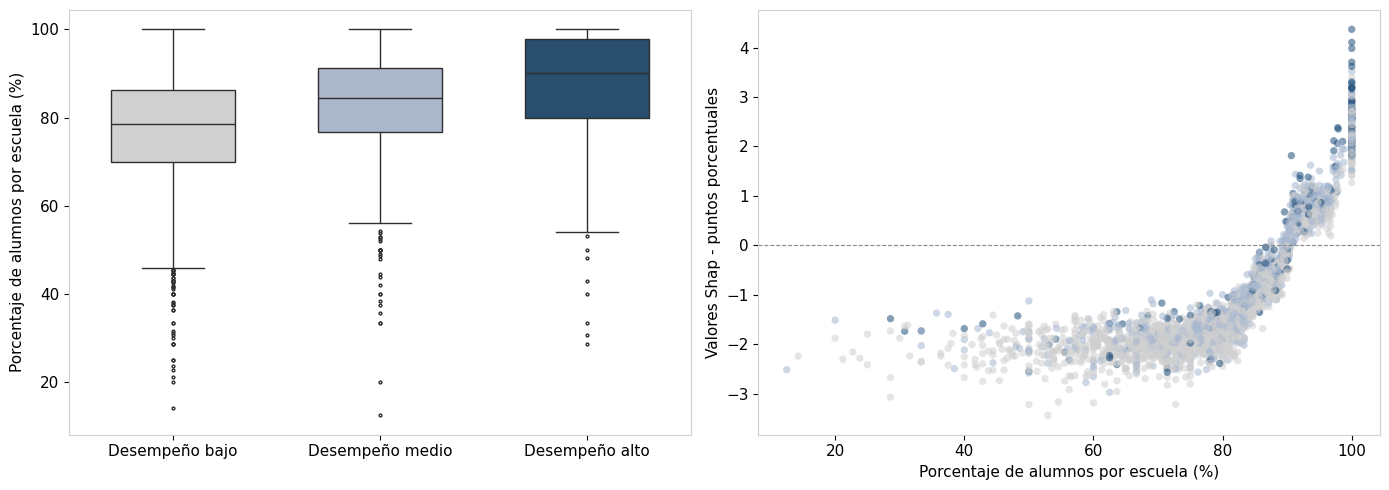

In [257]:
COLOR_BLUE_DARK  = "#1F4E79"
COLOR_BLUE_LIGHT = "#A6B7D0"
COLOR_GRAY_LIGHT       = "#D0D0D0"

palette_custom = [ COLOR_GRAY_LIGHT,COLOR_BLUE_LIGHT, COLOR_BLUE_DARK]

# ===== Diccionario de etiquetas =====
label_map = {
    "bajo": "Desempeño bajo",
    "medio": "Desempeño medio",
    "alto": "Desempeño alto"
}

df_bajo = df_diferencias[df_diferencias["NSE_nivel_grupo"] == "bajo"].copy()
df_bajo["ap22_1_pct"]=df_bajo["ap22_1_pct"]*100
df_bajo["ap22_1_pct_shap"]=df_bajo["ap22_1_pct_shap"]*100


df_bajo["categoria_satisfactorio_label"] = df_bajo["categoria_satisfactorio"].map(label_map)

# ===== Figura =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

sns.boxplot(
    data=df_bajo,
    x="categoria_satisfactorio_label",
    y="ap22_1_pct",
    palette=palette_custom,
    fliersize=2,
    width=0.6,
    ax=axes[0]
)

#axes[0].set_title("Alumnos con computadora (NSE bajo)", loc="left", fontsize=11)
axes[0].set_xlabel("")
axes[0].set_ylabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
axes[0].tick_params(axis="x", rotation=0, labelsize=11)
axes[0].tick_params(axis="y", labelsize=11)

# Spines
for spine in axes[0].spines.values():
    spine.set_color(COLOR_GRAY_LIGHT)
    spine.set_linewidth(0.8)

axes[0].grid(False)

# =========================================================
# 2) SCATTER PLOT — MISMA ESTÉTICA QUE TUS SCATTERS SHAP
# =========================================================

sns.scatterplot(
    data=df_bajo,
    x="ap22_1_pct",
    y="ap22_1_pct_shap",
    hue="categoria_satisfactorio_label",
    palette=palette_custom,
    s=28,
    alpha=0.55,
    ax=axes[1],
    edgecolor="none"
)

#axes[1].set_title("Valor SHAP según % de alumnos con computadora", loc="left", fontsize=13)
axes[1].set_xlabel("Porcentaje de alumnos por escuela (%)", fontsize=11)
axes[1].set_ylabel("Valores Shap - puntos porcentuales", fontsize=11)

axes[1].tick_params(axis="x", labelsize=11)
axes[1].tick_params(axis="y", labelsize=11)

# Línea guía SHAP = 0
axes[1].axhline(0, color="#888", linestyle="--", linewidth=0.8)

# Formato del eje X (porcentajes enteros)
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}"))

# Estilo de spines
for spine in axes[1].spines.values():
    spine.set_color(COLOR_GRAY_LIGHT)
    spine.set_linewidth(0.8)

axes[1].grid(False)

# Leyenda sin recuadro
axes[1].legend_.remove()
# Ajustes finales
plt.tight_layout()
plt.show()

In [258]:
# test de medias para loas principales 10 variables mas negativas


vars_list = [
    "ap09i_1_pct",
    "ap22_1_pct",
    "personas_por_habitacion",
    "ap10_1_pct",
    "sector",
    "ap10_2_pct",
    "ap26_1_pct",
    "ap05h_1_pct",
    "ap05f_1_pct",
    # si tenés dummies de jurisdicción en el df:
    "jurisdiccion_Córdoba",
]

df_bajo = df_diferencias.loc[df_diferencias["NSE_nivel_grupo"] == "bajo"].copy()

rows = []

for v in vars_list:

    if v not in df_bajo.columns:
        rows.append({"variable": v, "note": "column not found"})
        continue

    g_alto = df_bajo.loc[df_bajo["categoria_satisfactorio"] == "alto", v]
    g_bajo = df_bajo.loc[df_bajo["categoria_satisfactorio"] == "bajo", v]

    # convertir a numérico si aplica
    g_alto = pd.to_numeric(g_alto, errors="coerce").dropna()
    g_bajo = pd.to_numeric(g_bajo, errors="coerce").dropna()

    if (len(g_alto) == 0) or (len(g_bajo) == 0):
        rows.append({
            "variable": v,
            "n_alto": len(g_alto),
            "n_bajo": len(g_bajo),
            "note": "empty group"
        })
        continue

    t_stat, p_value = ttest_ind(g_alto, g_bajo, equal_var=False, nan_policy="omit")

    rows.append({
        "variable": v,
        "n_alto": len(g_alto),
        "n_bajo": len(g_bajo),
        "mean_alto": round(g_alto.mean(), 3),
        "mean_bajo": round(g_bajo.mean(), 3),
        "diff_alto_menos_bajo": round(g_alto.mean() - g_bajo.mean(), 3),
        "t_stat": t_stat,
        "p_value": p_value
    })

df_tests_X = pd.DataFrame(rows).sort_values("p_value", ascending=True).reset_index(drop=True)
df_tests_X


variable  n_alto  n_bajo  mean_alto  mean_bajo  \
0               ap22_1_pct   185.0  1874.0      0.862      0.771   
1              ap05h_1_pct   185.0  1874.0      0.377      0.454   
2               ap10_1_pct   185.0  1874.0      0.163      0.203   
3               ap26_1_pct   185.0  1874.0      0.847      0.804   
4  personas_por_habitacion   185.0  1874.0      2.054      2.146   
5                   sector   185.0  1874.0      0.908      0.976   
6               ap10_2_pct   185.0  1874.0      0.328      0.318   
7              ap09i_1_pct   185.0  1874.0      0.448      0.436   
8              ap05f_1_pct   185.0  1874.0      0.578      0.577   
9     jurisdiccion_Córdoba     NaN     NaN        NaN        NaN   

   diff_alto_menos_bajo    t_stat       p_value              note  
0                 0.091  8.123709  3.545788e-14               NaN  
1                -0.077 -5.726632  3.580665e-08               NaN  
2                -0.040 -4.115161  5.566735e-05               NaN  
3                 0.043  3.902774  1.290115e-04               NaN  
4                -0.092 -3.179920  1.688657e-03               NaN  
5                -0.068 -3.144326  1.926001e-03               NaN  
6                 0.010  0.966688  3.348320e-01               NaN  
7                 0.012  0.876556  3.817528e-01               NaN  
8                 0.001  0.063134  9.497223e-01               NaN  
9                   NaN       NaN           NaN  column not found

#### P4. ¿Cuáles son las 20 variables con mayores diferencias entre ambos grupos?

In [259]:
# =================== Parámetros ===================
TOP_N = 100
SCALE_SHAP_TO_PP = True          # multiplicar SHAP por 100 (si querés verlo en p.p.)
SCALE_PCT_VARS_TO_PP = True      # multiplicar a p.p. las variables *_pct

# =================== 1) Filtrar NSE bajo ===================
df_bajo = df_diferencias.loc[df_diferencias["NSE_nivel_grupo"] == "bajo"].copy()

# =================== 2) Columnas SHAP numéricas ===================
shap_cols = [c for c in df_bajo.columns if c.endswith("_shap") and pd.api.types.is_numeric_dtype(df_bajo[c])]
if "jurisdiccion_shap" in shap_cols:
    shap_cols.remove("jurisdiccion_shap")

# =================== 3) Medias SHAP por categoría y Δ SHAP ===================
means_shap = df_bajo.groupby("categoria_satisfactorio")[shap_cols].mean()
cats = [c for c in ["bajo", "alto"] if c in means_shap.index]
means_shap = means_shap.reindex(cats)

summary = means_shap.T.rename(columns={"bajo": "mean_shap_cat_bajo", "alto": "mean_shap_cat_alto"})
summary["diff_shap_alto_bajo"] = summary.get("mean_shap_cat_alto", 0) - summary.get("mean_shap_cat_bajo", 0)

# Promedio SHAP total dentro de NSE bajo (independiente de la categoría de satisfactorio)
mean_shap_total_bajo = df_bajo[shap_cols].mean()
summary["mean_shap_total_bajo"] = summary.index.map(mean_shap_total_bajo)

# Escalar SHAP a p.p. si corresponde
if SCALE_SHAP_TO_PP:
    cols_shap = ["mean_shap_cat_bajo", "mean_shap_cat_alto", "diff_shap_alto_bajo", "mean_shap_total_bajo"]
    summary[cols_shap] = summary[cols_shap] * 100

# =================== 4) Agregar short_name ===================
summary = summary.reset_index().rename(columns={"index": "variable_shap"})
summary["variable"] = summary["variable_shap"].str.replace("_shap$", "", regex=True)

short_map = {}
if 'map_cols' in globals() and {'variable_a_nivel_colegio','short_name'}.issubset(map_cols.columns):
    short_map = (
        map_cols[['variable_a_nivel_colegio','short_name']]
        .assign(variable_a_nivel_colegio=lambda d: d['variable_a_nivel_colegio'].str.replace('_shap$', '', regex=True))
        .drop_duplicates('variable_a_nivel_colegio')
        .set_index('variable_a_nivel_colegio')['short_name']
        .to_dict()
    )
summary["short_name"] = summary["variable"].map(short_map).fillna(summary["variable"])

# Ordenar por Δ SHAP
summary_out = (
    summary[["short_name", "variable", "mean_shap_cat_bajo", "mean_shap_cat_alto",
             "diff_shap_alto_bajo", "mean_shap_total_bajo"]]
    .sort_values("diff_shap_alto_bajo", ascending=False)
    .reset_index(drop=True)
    .round(3)
)

# =================== 5) “Distribución” reducida: SOLO promedios de variables originales ===================
top_vars = summary_out["variable"].head(TOP_N).tolist()

# Variables originales disponibles y numéricas
base_vars = [v for v in top_vars if v in df_bajo.columns and pd.api.types.is_numeric_dtype(df_bajo[v])]

# Promedios de variables originales por categoría
means_val = df_bajo.groupby("categoria_satisfactorio")[base_vars].mean()
means_val = means_val.reindex([c for c in ["bajo", "alto"] if c in means_val.index])

val_summary = means_val.T.rename(columns={"bajo": "mean_val_cat_bajo", "alto": "mean_val_cat_alto"}).reset_index()
val_summary = val_summary.rename(columns={"index": "variable"})

# Escalar *_pct a p.p. si corresponde
if SCALE_PCT_VARS_TO_PP and not val_summary.empty:
    mask_pct = val_summary["variable"].str.endswith("_pct")
    for c in ["mean_val_cat_bajo", "mean_val_cat_alto"]:
        if c in val_summary.columns:
            val_summary.loc[mask_pct, c] = val_summary.loc[mask_pct, c] * 100

# Agregar short_name y los SHAP means (para que queden juntos)
val_summary["short_name"] = val_summary["variable"].map(short_map).fillna(val_summary["variable"])
val_summary = val_summary.merge(
    summary_out[["variable", "diff_shap_alto_bajo", "mean_shap_cat_bajo", "mean_shap_cat_alto"]],
    on="variable",
    how="left"
)

# Orden final de columnas (sin std/percentiles/count)
dist_means = (
    val_summary[["short_name", "variable",
                 "mean_val_cat_bajo", "mean_val_cat_alto",
                 "mean_shap_cat_bajo", "mean_shap_cat_alto",
                 "diff_shap_alto_bajo"]]
    .sort_values("diff_shap_alto_bajo", ascending=False)
    .reset_index(drop=True)
    .round(3)
)

In [260]:
dist_means['diff_shap_alto_bajo'].sum()

21.463999999999995